<a href="https://colab.research.google.com/github/joaogabrielrs1511/PUC-CienciaDeDados/blob/main/PUC_ProjetoAnaliseDefeitosPlacas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#>CONFIGURAÇÃO DO AMBIENTE

In [10]:
###INSTALAÇÃO DE MÓDULOS ADICIONAIS
##! pip install mlxtend
#! pip install xlrd
#! pip install graphviz

In [11]:
from google.colab import data_table
from google.colab import files
from google.colab import drive

data_table.enable_dataframe_formatter()

In [12]:
#IMPORTAÇÃO DE BIBLIOTECAS
import pandas as pd
import re
import seaborn as sb
import numpy as np
import nltk
import warnings
import matplotlib.pyplot as plt
from collections import Counter

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#bibliotecas ml
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

#biblioteca de modelos
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#>IMPORTAÇÃO DE DADOS

####DEFEITOS EM PLACAS

In [13]:
##importanto e realizando pre tratamento na base

drive.mount('/content/drive', force_remount=True)
raw_placas = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/placas-defeitos-2021_treat.csv')

##SINTIZA EVENTOS DE DEFEITOS EM PLACAS
raw_placas['DEFECT_CD']=raw_placas['DEFECT_CD'].replace(to_replace=["||||||||||||"], value=np.nan)
raw_placas['Defeitos'] = np.where(pd.isnull(raw_placas['DEFECT_CD']), False, True)

raw_placas.head()

Mounted at /content/drive


DEFECT_CD     SLAB_NO      ORD_NO  ORD_ITEM  HEAT_NO  \
0       NaN  T939267091  9999992840        70  T939267   
1       NaN  T939267591  9999992840        70  T939267   
2       NaN  T939268011  9999992840        60  T939268   
3       NaN  T939268021  9999992840        60  T939268   
4       NaN  T939268511  9999992840        60  T939268   

                DATA_INSPECAO            FASE  Defeitos  
0  01/01/21 00:14:32..4490620  INSP. PRIMARIA     False  
1  01/01/21 00:14:32..5692690  INSP. PRIMARIA     False  
2  01/01/21 00:28:30..6155180  INSP. PRIMARIA     False  
3  01/01/21 00:28:30..8018630  INSP. PRIMARIA     False  
4  01/01/21 00:28:30..9206060  INSP. PRIMARIA     False

####CORRIDAS

In [14]:
drive.mount('/content/drive', force_remount=True)
raw_corridas = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/placas-corridas-2021_treat.csv')

raw_corridas.set_index('SLAB_NO')
raw_corridas['HEAT'] = raw_corridas['SLAB_NO'].str.slice(0,7)
raw_corridas.fillna (value=0, inplace=True)
raw_corridas.head()

Mounted at /content/drive


SLAB_NO TGT_STEEL_GRD PASS_PROC_ROUTE PLAN_PROC_ROUTE SECOND_RFN_CD  \
0  T939274041   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC            2A   
1  T939274051   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC            2A   
2  T939274101   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC            2A   
3  T939274081   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC            2A   
4  T939274571   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC            2A   

   HEAT_ACT_WGT  ROTA_DIVERGENTE  KR_NO  KR_TOTAL_TIME  KR_PROCESS_TIME  \
0         342.4                0    2.0           29.0             13.0   
1         342.4                0    2.0           29.0             13.0   
2         342.4                0    2.0           29.0             13.0   
3         342.4                0    2.0           29.0             13.0   
4         342.4                0    2.0           29.0             13.0   

   KR_WAIT_START_TIME  KR_WAIT_DEPARTUE_TIME  BOF_NO  BOF_CHRG_TIME  \
0                 6.0                    8.0       2              0   
1                 6.0                    8.0       2              0   
2                 6.0                    8.0       2              0   
3                 6.0                    8.0       2              0   
4                 6.0                    8.0       2              0   

   BOF_BLW_TIME  BOF_TAP_TIME  BAP_NO  BAP_TOTAL_TIME  BAP_PROCESS_TIME  \
0            14             8     2.0             1.0               0.0   
1            14             8     2.0             1.0               0.0   
2            14             8     2.0             1.0               0.0   
3            14             8     2.0             1.0               0.0   
4            14             8     2.0             1.0               0.0   

   BAP_WAIT_START_TIME  BAP_WAIT_DEPARTUE_TIME  BAP_RSLT_TIME  \
0                  0.0                     0.0            0.0   
1                  0.0                     0.0            0.0   
2                  0.0                     0.0            0.0   
3                  0.0                     0.0            0.0   
4                  0.0                     0.0            0.0   

  BAP_PROCESSO_PADRAO  BAP_TOP_BB_TOT_CNT  BAP_TOP_BB_TOT_DUR  \
0                   Z                 0.0                 0.0   
1                   Z                 0.0                 0.0   
2                   Z                 0.0                 0.0   
3                   Z                 0.0                 0.0   
4                   Z                 0.0                 0.0   

   BAP_BTM_BB_TOT_CNT  BAP_BTM_BB_TOT_DUR  BAP_TEMPERATURA_SAIDA  \
0                 0.0                 0.0                 1598.0   
1                 0.0                 0.0                 1598.0   
2                 0.0                 0.0                 1598.0   
3                 0.0                 0.0                 1598.0   
4                 0.0                 0.0                 1598.0   

   BAP_PI_USED_CNT  BAP_VOLUME_ARGONIO  BAP_VOLUME_N2  RH_NO  RH_TOTAL_TIME  \
0              1.0                 0.0            0.0    1.0           20.0   
1              1.0                 0.0            0.0    1.0           20.0   
2              1.0                 0.0            0.0    1.0           20.0   
3              1.0                 0.0            0.0    1.0           20.0   
4              1.0                 0.0            0.0    1.0           20.0   

   RH_PROCESS_TIME  RH_WAIT_START_TIME  RH_WAIT_DEPARTUE_TIME  LF_NO  \
0             13.0                 2.0                    3.0    0.0   
1             13.0                 2.0                    3.0    0.0   
2             13.0                 2.0                    3.0    0.0   
3             13.0                 2.0                    3.0    0.0   
4             13.0                 2.0                    3.0    0.0   

   LF_TOTAL_TIME  LF_PROCESS_TIME  LF_WAIT_START_TIME  LF_WAIT_DEPARTUE_TIME  \
0            0.0              0.0  

####EVENTOS DE QUALIDADE

In [15]:
drive.mount('/content/drive', force_remount=True)
raw_evento_qualidade = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/placas-qe-2021_treat.csv')

raw_evento_qualidade.set_index('SLAB_NO')
raw_evento_qualidade.fillna(value='NoEvent', inplace=True)

eq_pivot = raw_evento_qualidade.pivot (index='SLAB_NO', columns='QLTY_TRK_CD', values='QLTY_TRK_RSLT')
eq_pivot.reset_index (inplace=True)
eq_pivot.fillna (value=0, inplace=True)

del(raw_evento_qualidade)
print(type(eq_pivot))
eq_pivot.set_index('SLAB_NO')
eq_pivot.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>


QLTY_TRK_CD     SLAB_NO  NoEvent  S100  S101  S102  S103  S104  S105  S106  \
0            T939267091      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1            T939267591      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2            T939268011      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3            T939268021      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4            T939268031      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

QLTY_TRK_CD  S107  S108  S109  S111  S113  S122  S123  S125  S126  S127  S128  \
0             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

QLTY_TRK_CD  S129  S130  S131  S134  S135  S136  S137  S138  S141  S142  S143  \
0             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

QLTY_TRK_CD  S144  S145  S146  S147  S148  S149  S150  S152  S155  S156  S158  \
0             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

QLTY_TRK_CD  S159  S161  S162  S163  
0             0.0   0.0   0.0   0.0  
1             0.0   0.0   0.0   0.0  
2             0.0   0.0   0.0   0.0  
3             0.0   0.0   0.0   0.0  
4             0.0   0.0   0.0   0.0

####PROGRAMAÇÃO DE CORRIDAS

In [16]:
drive.mount('/content/drive', force_remount=True)
raw_schedule_placas = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/placas_programacao_2021_treat.csv')

raw_schedule_placas.set_index('SLAB_NO')
raw_schedule_placas.head()

Mounted at /content/drive


SLAB_NO  SPEC_CD  PLAN_SLAB_THK  PLAN_SLAB_WTH  PLAN_SLAB_STA_WTH  \
0  T939267091  SAE1006            250           1520               1520   
1  T939267591  SAE1006            250           1520               1520   
2  T939268011  SAE1006            250           1520               1520   
3  T939268021  SAE1006            250           1520               1520   
4  T939268031  SAE1006            250           1520               1520   

   PLAN_SLAB_END_WTH  PLAN_SLAB_WGT  SCARF_TY  UST_YN SMPING_TY TAPER_TY  \
0               1520         18.225       NaN     NaN       NaN      NaN   
1               1520         18.225       NaN     NaN       NaN      NaN   
2               1520         15.062       NaN     NaN       NaN      NaN   
3               1520         15.062       NaN     NaN       NaN      NaN   
4               1520         15.062       NaN     NaN       NaN      NaN   

   STR_NO MIXED_TY COOLING_TY SHORT_SLAB_TY  HEAT_SEQ_POSITION  \
0       1      NaN          A           NaN               0.32   
1       2      NaN          A           NaN               0.32   
2       1      NaN          A           NaN               0.36   
3       1      NaN          A           NaN               0.36   
4       1      NaN          A           NaN               0.36   

  PLAN_SECOND_RFN_CD PLAN_DE_P_YN  PLAN_HEAT_WGT PLAN_WTH_CHANGE_YN  \
0                 2A            N        309.825                  N   
1                 2A            N        309.825                  N   
2                 2A            N        301.240                  N   
3                 2A            N        301.240                  N   
4                 2A            N        301.240                  N   

  PLAN_TUDISH_CHG_FL  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

####RESULTADOS DE LINGOTAMENTO

In [17]:
drive.mount('/content/drive', force_remount=True)
casting_result_placas1 = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/placas_resultado_lingotamento_2021-COMPLETO1_treat.csv')
casting_result_placas2 = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/placas_resultado_lingotamento_2021-COMPLETO2_treat.csv')

casting_result_placas = casting_result_placas1.join(casting_result_placas2.set_index('SLAB_NO')) 
casting_result_placas.reset_index()
casting_result_placas.sort_values(by='SLAB_NO')
casting_result_placas.head()

Mounted at /content/drive


SLAB_NO PLAN_CUT_SLAB_NO  PROC_MC_NO  cc_STR_NO MIXD_SLAB_HEAT_NO  \
0  T939267091       P046277091           1          1               NaN   
1  T939267591       P046277581           1          2           T939268   
2  T939268011       P046278011           1          1           T939267   
3  T939268021       P046278021           1          1               NaN   
4  T939268031       P046278031           1          1               NaN   

   CAST_IN_LD_STEEL_WGT  TD_STEEL_SUPERH_DGR  CUT_SLAB_THK  CUT_SLAB_WTH  \
0                 237.5                 29.0           250          1529   
1                 283.5                 29.0           250          1529   
2                 205.6                 24.0           250          1529   
3                 174.0                 24.0           250          1529   
4                 142.3                 24.0           250          1529   

   CUT_SLAB_LTH  CUT_SLAB_WGT  CUT_SLAB_CONN_LTH SLAB_CUT_POSIT_CD  \
0          6053        18.163                0.0                 Y   
1          6050        18.154             5516.0                 K   
2          5001        15.006              493.0                 K   
3          5001        15.006                0.0                 L   
4          5003        15.012                0.0                 N   

       ORD_NO  ORD_ITEM CC_TAPER_TY  CUT_SLAB_STA_WTH  CUT_SLAB_END_WTH  \
0  9999992840        70           N              1529              1529   
1  9999992840        70           N              1529              1529   
2  9999992840        60           N              1529              1529   
3  9999992840        60           N              1529              1529   
4  9999992840        60           N              1529              1529   

   MLD_TAPR_RGT_CHG_VAL  MLD_TAPR_LFT_CHG_VAL  RGT_MD_TAPR_RATE  \
0                   0.0                   0.0              1.07   
1                   0.0                   0.0              1.09   
2                   0.0                   0.0              1.07   
3                   0.0                   0.0              1.07   
4                   0.0                   0.0              1.07   

   LFT_MD_TAPR_RATE  TD_AVG_TEMP  TD_STEEL_WGT  TD_SLID_NZ_MAX_OPEN  \
0              1.10       1559.0          60.0                 90.0   
1              1.09       1559.0          64.0                 84.0   
2              1.10       1554.0          64.0                 91.0   
3              1.10       1554.0          64.0                 91.0   
4              1.10       1554.0          64.0                 90.0   

   TD_SLID_NZ_MIN_OPEN  TD_SLID_GATE_OPEN_QTY  TD_SLID_NZ_OPEN_VAR_RATE  \
0                 88.0                   89.0                      0.02   
1                 79.0                   81.0                      0.05   
2                 89.0                   90.0                      0.02   
3                 89.0                   90.0                      0.02   
4                 89.0                   89.0                      0.01   

   MLD_WIDE_IS_CW_TEMP_DIFF  MLD_WIDE_OS_CW_TEMP_DIFF  \
0                       5.5                       5.3   
1                       4.5                       4.6   
2                       5.7                       5.5   
3                       5.7                       5.4   
4                       5.7                       5.4   

   MLD_NARW_LFT_CW_TEMP_DIFF  MLD_NARW_RGT_CW_TEMP_DIFF  MLD_OSCILL_GAP  \
0                        7.1                        6.8             7.4   
1                        6.4                        6.2             6.1   
2                        7.3                        7.1             7.4   
3                        7.5                        7.1             7.4   
4                        7.4                        7.1             7.4   

   CAST_MIN_SPD  CAST_MAX_SPD  CAST_AVG_SPD  CAST_IN_CAST_SPD_CHG_VAL  \
0          1.31          1.35          1.34                      0.18   
1    

####COMPOSIÇÃO QUIMICA

In [18]:
#obtendo os dados de resultados quimicos e especificação quimica das bases csv Google Drive
drive.mount('/content/drive', force_remount=True)
raw_chem_heat_result = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/Resultado_Quimico_Corridas_2021_treat.csv')
raw_chem_heat_result.reset_index()
raw_chem_heat_result.sort_values(by='HEAT')

#tratando somente dados da amostra final de corrida
raw_chem_heat_result = raw_chem_heat_result[(raw_chem_heat_result['AMOSTRA'].str.contains('PDA1417101'))]

#analisando saida dos dados de resultados quimicos
raw_chem_heat_result.head()


Mounted at /content/drive


HEAT     AMOSTRA ELEMENTO  RESULTADO
48  T939267  PDA1417101      V04     0.0140
49  T939267  PDA1417101      V36     0.0038
50  T939267  PDA1417101      V02     0.0140
51  T939267  PDA1417101      V03     0.2030
52  T939267  PDA1417101      V05     0.0063

In [19]:
#obtendo os dados de especificações quimicas das bases csv Google Drive
raw_chem_heat_spec = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/treat/Espec_Quimico_Corridas_2021_treat.csv')
raw_chem_heat_spec.reset_index()
raw_chem_heat_spec.sort_values(by='HEAT')

raw_chem_heat_spec["MIN_VAL"] = raw_chem_heat_spec["MIN_VAL"].fillna(0)

#analisando saida dos dados de especificação quimica
raw_chem_heat_spec.head()


HEAT ELEMENTO  TGT_VAL  MIN_VAL  MAX_VAL
0  T939267      V01     0.04     0.03    0.060
1  T939267      V02     0.00     0.00    0.030
2  T939267      V03     0.18     0.15    0.230
3  T939267      V04     0.00     0.00    0.025
4  T939267      V05     0.00     0.00    0.010

In [20]:
#consolidação dos dados de especificação e resultados quimicos
quimico_spec_rsult = raw_chem_heat_result.merge(raw_chem_heat_spec, on=['HEAT', 'ELEMENTO'])
quimico_spec_rsult['APROV'] = np.where((quimico_spec_rsult['RESULTADO']>= quimico_spec_rsult['MIN_VAL']) & (quimico_spec_rsult['RESULTADO']<=quimico_spec_rsult['MAX_VAL']), True, False)

In [21]:
#montrando estrutura de pivot para consolidação dos resultados quimicos
quimico_spec_rsult['AMOSTRA'] = quimico_spec_rsult["AMOSTRA"].astype(str) + quimico_spec_rsult["ELEMENTO"]
resultados_quimicos = quimico_spec_rsult.pivot (index='HEAT', columns='AMOSTRA', values='APROV')
resultados_quimicos.head()

AMOSTRA PDA1417101V01 PDA1417101V02 PDA1417101V03 PDA1417101V04 PDA1417101V05  \
HEAT                                                                            
T939267          True          True          True          True          True   
T939268          True          True          True          True          True   
T939269          True          True          True          True          True   
T939270          True          True          True          True          True   
T939271          True          True          True          True          True   

AMOSTRA PDA1417101V06 PDA1417101V07 PDA1417101V08 PDA1417101V10 PDA1417101V11  \
HEAT                                                                            
T939267          True          True           NaN          True          True   
T939268          True          True           NaN          True          True   
T939269          True          True           NaN          True          True   
T939270          True          True           NaN          True          True   
T939271          True          True           NaN          True          True   

AMOSTRA PDA1417101V14 PDA1417101V15 PDA1417101V16 PDA1417101V18 PDA1417101V19  \
HEAT                                                                            
T939267          True          True          True          True          True   
T939268          True          True          True          True          True   
T939269          True          True          True          True          True   
T939270          True          True          True          True          True   
T939271          True          True          True          True          True   

AMOSTRA PDA1417101V20 PDA1417101V21 PDA1417101V22 PDA1417101V23 PDA1417101V24  \
HEAT                                                                            
T939267           NaN          True          True           NaN           NaN   
T939268           NaN          True          True           NaN           NaN   
T939269           NaN          True          True           NaN           NaN   
T939270           NaN          True          True           NaN           NaN   
T939271           NaN          True          True           NaN           NaN   

AMOSTRA PDA1417101V25 PDA1417101V30 PDA1417101V31 PDA1417101V33 PDA1417101V36  \
HEAT                                                                            
T939267          True           NaN          True           NaN          True   
T939268          True           NaN          True           NaN          True   
T939269          True           NaN          True           NaN          True   
T939270          True           NaN          True           NaN          True   
T939271          True           NaN          True           NaN          True   

AMOSTRA PDA1417101V37 PDA1417101V69 PDA1417101V94 PDA1417101V96 PDA1417101V97  \
HEAT                                                                            
T939267           NaN           NaN           NaN           NaN           NaN   
T939268           NaN           NaN           NaN           NaN           NaN   
T939269           NaN           NaN           NaN           NaN           NaN   
T939270           NaN           NaN           NaN           NaN           NaN   
T939271           NaN           NaN           NaN           NaN           NaN   

AMOSTRA PDA1417101V98  
HEAT                   
T939267           NaN  
T939268           NaN  
T939269           NaN  
T939270           NaN  
T939271           NaN

#>PREPARAÇÃO DOS DADOS

##>>CONSOLIDAÇÃO DO DATASET

In [22]:
#Consolidando todos os dataframes indexados por placa em um unico dataframe
data_analysis = raw_placas.groupby('SLAB_NO')['Defeitos'].any().to_frame() #sumarizando todas as inspeçoes de placas com predominancia da indicação de defeitos
data_analysis = data_analysis.join(raw_corridas.set_index('SLAB_NO'), how='outer')  #sumarizando os dados de resultados de produção de corridas com dataset de defeitos de placas
data_analysis = data_analysis.join(eq_pivot.set_index('SLAB_NO'), how='outer') #sumarizando os dados de eventos de qualidades de placas com dataset de defeitos de placas
data_analysis = data_analysis.join(raw_schedule_placas.set_index('SLAB_NO'), how='outer') #sumarizando os dados de programação de produção com dataset de defeitos de placas
data_analysis = data_analysis.join(casting_result_placas.set_index('SLAB_NO'), how='outer') #sumarizando os dados de resultado de lingotamento com dataset de defeitos de placas
data_analysis['SLAB_NO'] = data_analysis.index #removndo referencia do indice para tratamento da placa nos processos de tratamento da dado omissos

data_analysis = resultados_quimicos.join(data_analysis.set_index('HEAT'), on='HEAT') #sumarizando os dados de resultados quimicos no dataset de defeitos de placas
data_analysis['HEAT'] = data_analysis.index #removndo referencia do indice para tratamento da placa nos processos de tratamento da dado omissos

data_analysis = data_analysis.reset_index(drop=True)
data_analysis.head()

PDA1417101V01 PDA1417101V02 PDA1417101V03 PDA1417101V04 PDA1417101V05  \
0          True          True          True          True          True   
1          True          True          True          True          True   
2          True          True          True          True          True   
3          True          True          True          True          True   
4          True          True          True          True          True   

  PDA1417101V06 PDA1417101V07 PDA1417101V08 PDA1417101V10 PDA1417101V11  \
0          True          True           NaN          True          True   
1          True          True           NaN          True          True   
2          True          True           NaN          True          True   
3          True          True           NaN          True          True   
4          True          True           NaN          True          True   

  PDA1417101V14 PDA1417101V15 PDA1417101V16 PDA1417101V18 PDA1417101V19  \
0          True          True          True          True          True   
1          True          True          True          True          True   
2          True          True          True          True          True   
3          True          True          True          True          True   
4          True          True          True          True          True   

  PDA1417101V20 PDA1417101V21 PDA1417101V22 PDA1417101V23 PDA1417101V24  \
0           NaN          True          True           NaN           NaN   
1           NaN          True          True           NaN           NaN   
2           NaN          True          True           NaN           NaN   
3           NaN          True          True           NaN           NaN   
4           NaN          True          True           NaN           NaN   

  PDA1417101V25 PDA1417101V30 PDA1417101V31 PDA1417101V33 PDA1417101V36  \
0          True           NaN          True           NaN          True   
1          True           NaN          True           NaN          True   
2          True           NaN          True           NaN          True   
3          True           NaN          True           NaN          True   
4          True           NaN          True           NaN          True   

  PDA1417101V37 PDA1417101V69 PDA1417101V94 PDA1417101V96 PDA1417101V97  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

  PDA1417101V98 Defeitos TGT_STEEL_GRD PASS_PROC_ROUTE PLAN_PROC_ROUTE  \
0           NaN    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
1           NaN    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
2           NaN    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
3           NaN    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
4           NaN    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   

  SECOND_RFN_CD  HEAT_ACT_WGT  ROTA_DIVERGENTE  KR_NO  KR_TOTAL_TIME  \
0            2A         342.8              0.0    1.0           47.0   
1            2A         342.8              0.0    1.0           47.0   
2            2A         342.6              0.0    2.0           34.0   
3            2A         342.6              0.0    2.0           34.0   
4            2A         342.6              0.0    2.0           34.0   

   KR_PROCESS_TIME  KR_WAIT_START_TIME  KR_WAIT_DEPARTUE_TIME  BOF_NO  \
0             32.0                 7.0                    8.0     2.0   
1             32.0                 7.0                    8.0     2.0   
2             15.0                10.0                    7.0     2.0   
3             15.0                10.0                    7.0     2.0   
4             15.0                10.0               

In [23]:
#analisando consumo de memoria dos dados do modelo
data_analysis.info(memory_usage='deep') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60847 entries, 0 to 60846
Columns: 229 entries, PDA1417101V01 to HEAT
dtypes: float64(168), object(61)
memory usage: 221.3 MB


In [24]:
#liberando variaveis de memória que não serão mais utlilizadas no modelo
del(raw_placas)
del(raw_schedule_placas) 
del(eq_pivot)
del(raw_corridas)
del(raw_chem_heat_spec)
del(raw_chem_heat_result)
del(quimico_spec_rsult)
del(resultados_quimicos)
del(casting_result_placas)
del(casting_result_placas1)
del(casting_result_placas2)

##>>ANALISE PRELIMINAR DOS DADOS

array([[<Axes: title={'center': 'HEAT_ACT_WGT'}>,
        <Axes: title={'center': 'ROTA_DIVERGENTE'}>,
        <Axes: title={'center': 'KR_NO'}>,
        <Axes: title={'center': 'KR_TOTAL_TIME'}>,
        <Axes: title={'center': 'KR_PROCESS_TIME'}>,
        <Axes: title={'center': 'KR_WAIT_START_TIME'}>,
        <Axes: title={'center': 'KR_WAIT_DEPARTUE_TIME'}>,
        <Axes: title={'center': 'BOF_NO'}>,
        <Axes: title={'center': 'BOF_CHRG_TIME'}>,
        <Axes: title={'center': 'BOF_BLW_TIME'}>,
        <Axes: title={'center': 'BOF_TAP_TIME'}>,
        <Axes: title={'center': 'BAP_NO'}>,
        <Axes: title={'center': 'BAP_TOTAL_TIME'}>],
       [<Axes: title={'center': 'BAP_PROCESS_TIME'}>,
        <Axes: title={'center': 'BAP_WAIT_START_TIME'}>,
        <Axes: title={'center': 'BAP_WAIT_DEPARTUE_TIME'}>,
        <Axes: title={'center': 'BAP_RSLT_TIME'}>,
        <Axes: title={'center': 'BAP_TOP_BB_TOT_CNT'}>,
        <Axes: title={'center': 'BAP_TOP_BB_TOT_DUR'}>,
        <

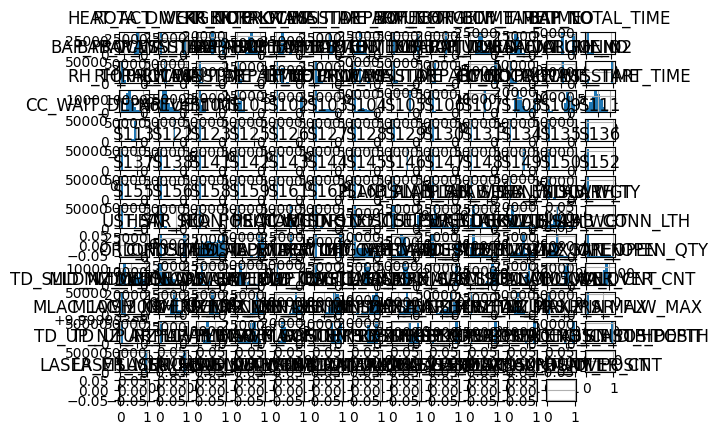

In [25]:
data_analysis.hist()

In [26]:
print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("Total de registros: \n{0}\n".format(len(data_analysis.index)))

Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

Total de registros: 
60847



In [27]:
#Excluindo linhas que não possuem referencia com defeito. Irrelevantes para analise dos resultados e modelo.
data_analysis.dropna(subset=['Defeitos'], inplace=True)

print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("Total de registros: \n{0}\n".format(len(data_analysis.index)))

Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

Total de registros: 
55631



In [28]:
data_analysis.isnull().sum()

PDA1417101V01             0
PDA1417101V02           150
PDA1417101V03           150
PDA1417101V04           150
PDA1417101V05           150
                      ...  
MLAC_50MM_OVER_CNT    55631
MLD_SURF_VORTEX_YN    55631
TCM_CUT_MODE          55631
SLAB_NO                   0
HEAT                      0
Length: 229, dtype: int64

##>>TRATAMENTO DE VALORES OMISSOS

###QUIMICOS

In [29]:
#ANALISANDO OCORRENCIAS DE VALORES OMISSOS DE COMPOSIÇÃO QUIMICA
print(data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V20'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V30'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V94'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V97'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V98'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas.  

Defeitos  PDA1417101V01
False     True             37281
          False             2162
True      True             15071
          False             1117
Name: PDA1417101V01, dtype: int64
Defeitos  PDA1417101V02
False     True             37939
          False             1378
          NaN                126
True      True             15602
          False              562
          NaN                 24
Name: PDA1417101V02, dtype: int64
Defeitos  PDA1417101V03
False     True             38719
          False              598
          NaN                126
True      True             15891
          False              273
          NaN                 24
Name: PDA1417101V03, dtype: int64
Defeitos  PDA1417101V04
False     True             38168
          False             1149
          NaN                126
True      True             15719
          False              445
          NaN                 24
Name: PDA1417101V04, dtype: int64
Defeitos  PDA1417101V05
False     True    

In [30]:
#TRATANDO VALORES OMISSOS DE COMPOSIÇÃO QUIMICA
data_analysis["PDA1417101V01"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V02"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V03"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V04"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V05"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V06"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V07"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V08"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V10"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V11"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V14"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V15"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V16"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V18"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V19"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V20"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V21"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V22"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V23"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V24"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V25"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V30"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V31"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V33"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V36"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V37"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V69"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V94"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V96"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V97"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V98"].fillna(value=True,inplace=True)

In [31]:
#ANALISANDO OCORRENCIAS DE VALORES OMISSOS DE COMPOSIÇÃO QUIMICA
print(data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V20'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V30'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V94'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V97'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V98'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas.  

Defeitos  PDA1417101V01
False     True             37281
          False             2162
True      True             15071
          False             1117
Name: PDA1417101V01, dtype: int64
Defeitos  PDA1417101V02
False     True             38065
          False             1378
True      True             15626
          False              562
Name: PDA1417101V02, dtype: int64
Defeitos  PDA1417101V03
False     True             38845
          False              598
True      True             15915
          False              273
Name: PDA1417101V03, dtype: int64
Defeitos  PDA1417101V04
False     True             38294
          False             1149
True      True             15743
          False              445
Name: PDA1417101V04, dtype: int64
Defeitos  PDA1417101V05
False     True             38615
          False              828
True      True             15798
          False              390
Name: PDA1417101V05, dtype: int64
Defeitos  PDA1417101V06
False     True            

###LINGOTAMENTO

In [32]:
# CC_STR_NO: Valores omissos referenciam as ocorrencias de placas objetivadas (Defeito=True), aplicando regra para limpeza desta informação
data_analysis.groupby('Defeitos')['cc_STR_NO'].value_counts(dropna=False)

Defeitos  cc_STR_NO
False     2.0          19922
          1.0          19521
True      1.0           7001
          2.0           6653
          NaN           2534
Name: cc_STR_NO, dtype: int64

In [33]:
#A 8ª posição da placa indica o veio de lingotamento, podendo mapear o veio corretamente
data_analysis['cc_STR_NO'] = pd.Categorical([cc_no[7] for cc_no in data_analysis['SLAB_NO'].astype(str)]).astype(int)
data_analysis['STR_NO'] = data_analysis['cc_STR_NO'].apply(lambda x: 2 if x>=5 else 1)

data_analysis.groupby('Defeitos')['STR_NO'].value_counts(dropna=False)

Defeitos  STR_NO
False     2         19922
          1         19521
True      1          8277
          2          7911
Name: STR_NO, dtype: int64

In [34]:
# SMPING_TY: Valores omissos referenciam as ocorrencias de placas objetivadas (Defeito=True), aplicando regra para limpeza desta informação. Placas amostradas fisicamente no processo
data_analysis.groupby('Defeitos')['SMPING_TY'].value_counts(dropna=False)

Defeitos  SMPING_TY
False     NaN          39101
          S              342
True      NaN          15942
          S              246
Name: SMPING_TY, dtype: int64

In [35]:
#aplicando tratamento de placas não amostradas
data_analysis["SMPING_TY"].fillna(value='N',inplace=True)

# SMPING_TY: Valores omissos referenciam as ocorrencias de placas objetivadas (Defeito=True), aplicando regra para limpeza desta informação. Placas amostradas fisicamente no processo
data_analysis.groupby('Defeitos')['SMPING_TY'].value_counts(dropna=False)

Defeitos  SMPING_TY
False     N            39101
          S              342
True      N            15942
          S              246
Name: SMPING_TY, dtype: int64

###VELOCIDADES DE LINGOTAMENTO

Total de registros nulos para CAST_MIN_SPD: 2632

 Distribuição dos resultados:


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

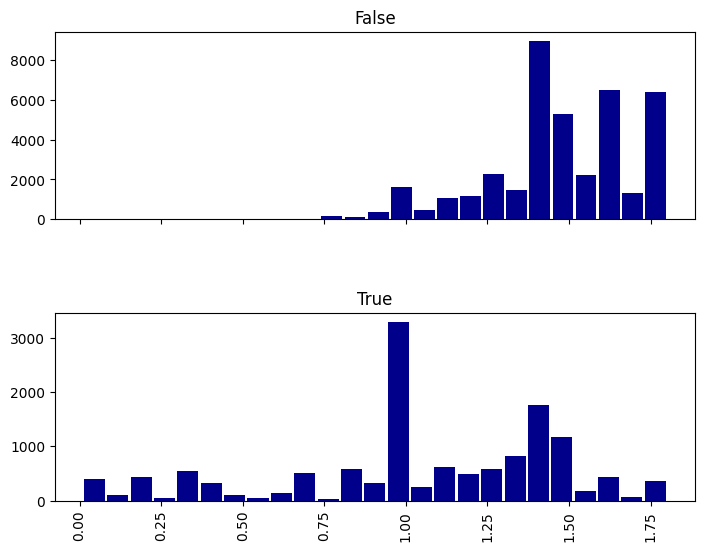

In [36]:
print("Total de registros nulos para CAST_MIN_SPD: {0}\n\n Distribuição dos resultados:".format(data_analysis.CAST_MIN_SPD.isna().sum()))

# CAST_MIN_SPD:Analisando histograma da variavel
data_analysis.hist(column='CAST_MIN_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

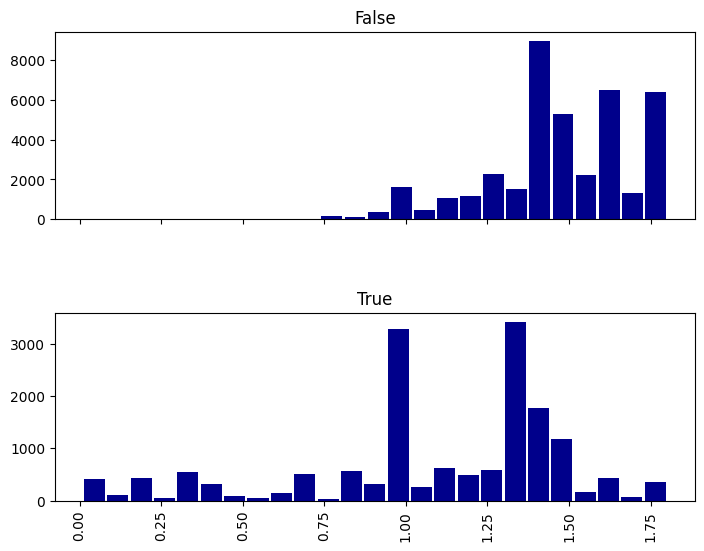

In [37]:
#aplicando a mediana das velocidades 
data_analysis["CAST_MIN_SPD"].fillna(value=data_analysis['CAST_MIN_SPD'].mean(),inplace=True)

# CAST_MIN_SPD:Analisando histograma da variavel
data_analysis.hist(column='CAST_MIN_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

Total de registros nulos para CAST_MAX_SPD: 2632

 Distribuição dos resultados:


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

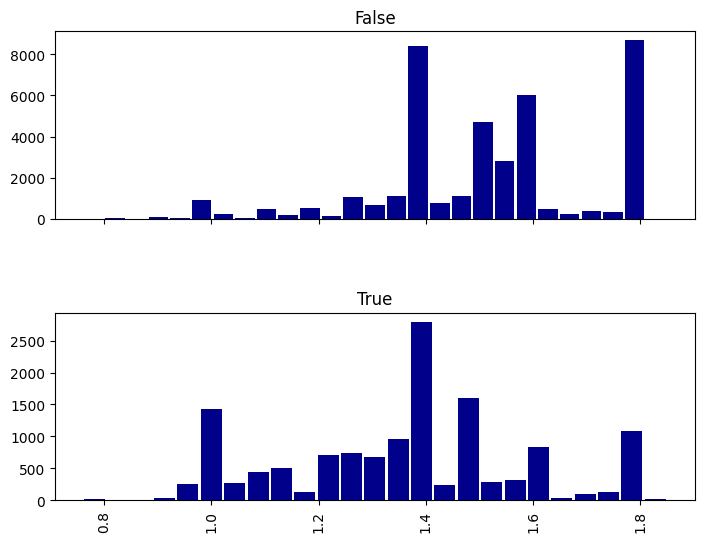

In [38]:
print("Total de registros nulos para CAST_MAX_SPD: {0}\n\n Distribuição dos resultados:".format(data_analysis.CAST_MAX_SPD.isna().sum()))

# CAST_MAX_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_MAX_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

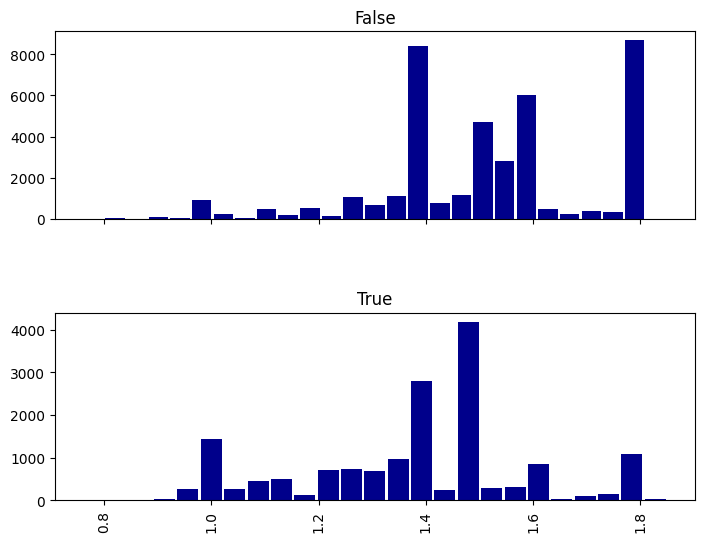

In [39]:
#aplicando a mediana das velocidades 
data_analysis["CAST_MAX_SPD"].fillna(value=data_analysis['CAST_MAX_SPD'].mean(),inplace=True)

# CAST_MAX_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_MAX_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

Total de registros nulos para CAST_AVG_SPD: 2632

 Distribuição dos resultados:


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

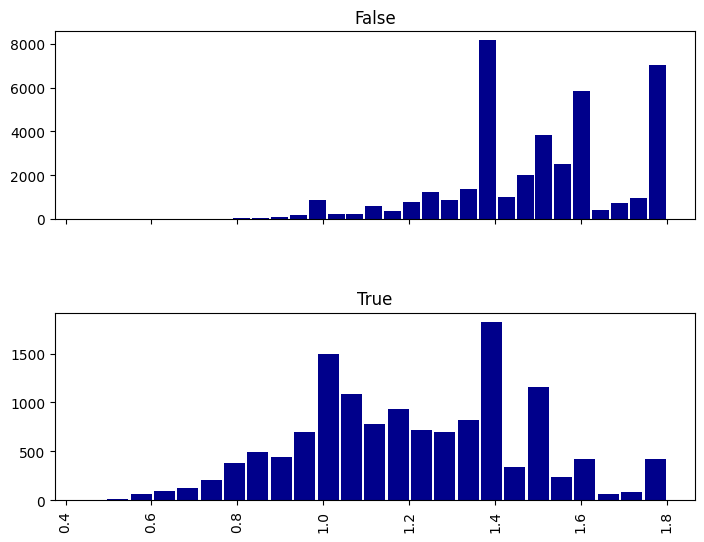

In [40]:
print("Total de registros nulos para CAST_AVG_SPD: {0}\n\n Distribuição dos resultados:".format(data_analysis.CAST_AVG_SPD.isna().sum()))

# CAST_AVG_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_AVG_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

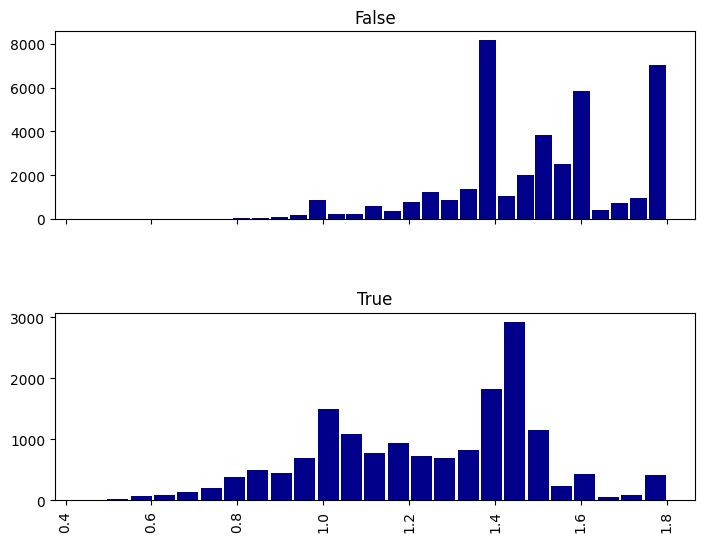

In [41]:
#aplicando a mediana das velocidades 
data_analysis["CAST_AVG_SPD"].fillna(value=data_analysis['CAST_AVG_SPD'].mean(),inplace=True)

# CAST_AVG_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_AVG_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

###RESULTADO LINGOTAMENTO

In [42]:
#nalise de parametros de lingotamento nulas
print("Total de registros nulos para TD_AVG_TEMP: {0}".format(data_analysis.TD_AVG_TEMP.isna().sum()))
print("Total de registros nulos para MLAC_3MM_OVER_CNT: {0}".format(data_analysis.MLAC_3MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para MLAC_5MM_OVER_CNT: {0}".format(data_analysis.MLAC_5MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para MLAC_10MM_OVER_CNT: {0}".format(data_analysis.MLAC_10MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para MLAC_20MM_OVER_CNT: {0}".format(data_analysis.MLAC_20MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para TD_UP_NZ_AR_FLW_MIN: {0}".format(data_analysis.TD_UP_NZ_AR_FLW_MIN.isna().sum()))
print("Total de registros nulos para TD_UP_NZ_AR_FLW_AVG: {0}".format(data_analysis.TD_UP_NZ_AR_FLW_AVG.isna().sum()))
print("Total de registros nulos para TD_UP_NZ_AR_FLW_MAX: {0}".format(data_analysis.TD_UP_NZ_AR_FLW_MAX.isna().sum()))
print("Total de registros nulos para SH_NZ_DIP_MAX_DEPTH: {0}".format(data_analysis.SH_NZ_DIP_MAX_DEPTH.isna().sum()))
print("Total de registros nulos para SH_NZ_DIP_MIN_DEPTH: {0}".format(data_analysis.SH_NZ_DIP_MIN_DEPTH.isna().sum()))
print("Total de registros nulos para SN_SETTLE_MIN_DEPTH: {0}".format(data_analysis.SN_SETTLE_MIN_DEPTH.isna().sum()))
print("Total de registros nulos para SN_SETTLE_MAX_DEPTH: {0}".format(data_analysis.SN_SETTLE_MAX_DEPTH.isna().sum()))
print("Total de registros nulos para MLD_TAPR_RGT_CHG_VAL: {0}".format(data_analysis.MLD_TAPR_RGT_CHG_VAL.isna().sum()))
print("Total de registros nulos para MLD_TAPR_LFT_CHG_VAL: {0}".format(data_analysis.MLD_TAPR_LFT_CHG_VAL.isna().sum()))
print("Total de registros nulos para TD_STEEL_WGT: {0}".format(data_analysis.TD_STEEL_WGT.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_PRS_MIN: {0}".format(data_analysis.SH_NZ_AR_PRS_MIN.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_PRS_MAX: {0}".format(data_analysis.SH_NZ_AR_PRS_MAX.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_FLW_MIN: {0}".format(data_analysis.SH_NZ_AR_FLW_MIN.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_FLW_MAX: {0}".format(data_analysis.SH_NZ_AR_FLW_MAX.isna().sum()))
print("Total de registros nulos para RGT_MD_TAPR_RATE: {0}".format(data_analysis.RGT_MD_TAPR_RATE.isna().sum()))
print("Total de registros nulos para LFT_MD_TAPR_RATE: {0}".format(data_analysis.LFT_MD_TAPR_RATE.isna().sum()))
print("Total de registros nulos para MLAC_SCAN_TOT_CNT: {0}".format(data_analysis.MLAC_SCAN_TOT_CNT.isna().sum()))
print("Total de registros nulos para SH_NZ_DIP_AVG_DEPTH: {0}".format(data_analysis.SH_NZ_DIP_AVG_DEPTH.isna().sum()))
print("Total de registros nulos para TD_SLID_NZ_MAX_OPEN: {0}".format(data_analysis.TD_SLID_NZ_MAX_OPEN.isna().sum()))
print("Total de registros nulos para TD_SLID_NZ_MIN_OPEN: {0}".format(data_analysis.TD_SLID_NZ_MIN_OPEN.isna().sum()))
print("Total de registros nulos para SN_SETTLE_AVG_DEPTH: {0}".format(data_analysis.SN_SETTLE_AVG_DEPTH.isna().sum()))
print("Total de registros nulos para TD_SLID_GATE_OPEN_QTY: {0}".format(data_analysis.TD_SLID_GATE_OPEN_QTY.isna().sum()))
print("Total de registros nulos para CAST_IN_CAST_SPD_CHG_VAL: {0}".format(data_analysis.CAST_IN_CAST_SPD_CHG_VAL.isna().sum()))
print("Total de registros nulos para MLD_WIDE_OS_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_WIDE_OS_CW_TEMP_DIFF.isna().sum()))
print("Total de registros nulos para TD_SLID_NZ_OPEN_VAR_RATE: {0}".format(data_analysis.TD_SLID_NZ_OPEN_VAR_RATE.isna().sum()))
print("Total de registros nulos para MLD_WIDE_IS_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_WIDE_IS_CW_TEMP_DIFF.isna().sum()))
print("Total de registros nulos para MLD_NARW_RGT_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_NARW_RGT_CW_TEMP_DIFF.isna().sum()))
print("Total de registros nulos para MLD_NARW_LFT_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_NARW_LFT_CW_TEMP_DIFF.isna().sum()))



Total de registros nulos para TD_AVG_TEMP: 2601
Total de registros nulos para MLAC_3MM_OVER_CNT: 2601
Total de registros nulos para MLAC_5MM_OVER_CNT: 2601
Total de registros nulos para MLAC_10MM_OVER_CNT: 2601
Total de registros nulos para MLAC_20MM_OVER_CNT: 2601
Total de registros nulos para TD_UP_NZ_AR_FLW_MIN: 2601
Total de registros nulos para TD_UP_NZ_AR_FLW_AVG: 2601
Total de registros nulos para TD_UP_NZ_AR_FLW_MAX: 2601
Total de registros nulos para SH_NZ_DIP_MAX_DEPTH: 2601
Total de registros nulos para SH_NZ_DIP_MIN_DEPTH: 2601
Total de registros nulos para SN_SETTLE_MIN_DEPTH: 2601
Total de registros nulos para SN_SETTLE_MAX_DEPTH: 2601
Total de registros nulos para MLD_TAPR_RGT_CHG_VAL: 2601
Total de registros nulos para MLD_TAPR_LFT_CHG_VAL: 2601
Total de registros nulos para TD_STEEL_WGT: 2632
Total de registros nulos para SH_NZ_AR_PRS_MIN: 2601
Total de registros nulos para SH_NZ_AR_PRS_MAX: 2601
Total de registros nulos para SH_NZ_AR_FLW_MIN: 2601
Total de registros n

In [43]:
data_analysis["TD_UP_NZ_AR_FLW_MIN"].fillna(value=data_analysis['TD_UP_NZ_AR_FLW_MIN'].mean(),inplace=True)   
data_analysis["TD_UP_NZ_AR_FLW_AVG"].fillna(value=data_analysis['TD_UP_NZ_AR_FLW_AVG'].mean(),inplace=True)
data_analysis["TD_UP_NZ_AR_FLW_MAX"].fillna(value=data_analysis['TD_UP_NZ_AR_FLW_MAX'].mean(),inplace=True)
data_analysis["SH_NZ_DIP_MAX_DEPTH"].fillna(value=data_analysis['SH_NZ_DIP_MAX_DEPTH'].mean(),inplace=True)
data_analysis["SH_NZ_DIP_MIN_DEPTH"].fillna(value=data_analysis['SH_NZ_DIP_MIN_DEPTH'].mean(),inplace=True)
data_analysis["SN_SETTLE_MIN_DEPTH"].fillna(value=data_analysis['SN_SETTLE_MIN_DEPTH'].mean(),inplace=True)
data_analysis["SN_SETTLE_MAX_DEPTH"].fillna(value=data_analysis['SN_SETTLE_MAX_DEPTH'].mean(),inplace=True)
data_analysis["MLAC_3MM_OVER_CNT"].fillna(value=data_analysis['MLAC_3MM_OVER_CNT'].mean(),inplace=True)
data_analysis["MLAC_5MM_OVER_CNT"].fillna(value=data_analysis['MLAC_5MM_OVER_CNT'].mean(),inplace=True)
data_analysis["MLAC_10MM_OVER_CNT"].fillna(value=data_analysis['MLAC_10MM_OVER_CNT'].mean(),inplace=True)
data_analysis["MLAC_20MM_OVER_CNT"].fillna(value=data_analysis['MLAC_20MM_OVER_CNT'].mean(),inplace=True)
data_analysis["TD_AVG_TEMP"].fillna(value=data_analysis['TD_AVG_TEMP'].mean(),inplace=True)
data_analysis["MLD_TAPR_RGT_CHG_VAL"].fillna(value=data_analysis['MLD_TAPR_RGT_CHG_VAL'].mean(),inplace=True)
data_analysis["MLD_TAPR_LFT_CHG_VAL"].fillna(value=data_analysis['MLD_TAPR_LFT_CHG_VAL'].mean(),inplace=True)
data_analysis["SH_NZ_AR_PRS_MIN"].fillna(value=data_analysis['SH_NZ_AR_PRS_MIN'].mean(),inplace=True)
data_analysis["SH_NZ_AR_PRS_MAX"].fillna(value=data_analysis['SH_NZ_AR_PRS_MAX'].mean(),inplace=True)
data_analysis["SN_SETTLE_AVG_DEPTH"].fillna(value=data_analysis['SN_SETTLE_AVG_DEPTH'].mean(),inplace=True)
data_analysis["SH_NZ_AR_FLW_MIN"].fillna(value=data_analysis['SH_NZ_AR_FLW_MIN'].mean(),inplace=True)
data_analysis["SH_NZ_AR_FLW_MAX"].fillna(value=data_analysis['SH_NZ_AR_FLW_MAX'].mean(),inplace=True)
data_analysis["SH_NZ_DIP_AVG_DEPTH"].fillna(value=data_analysis['SH_NZ_DIP_AVG_DEPTH'].mean(),inplace=True)
data_analysis["CAST_IN_CAST_SPD_CHG_VAL"].fillna(value=data_analysis['CAST_IN_CAST_SPD_CHG_VAL'].mean(),inplace=True)
data_analysis["MLAC_SCAN_TOT_CNT"].fillna(value=data_analysis['MLAC_SCAN_TOT_CNT'].mean(),inplace=True)
data_analysis["MLD_NARW_RGT_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["MLD_WIDE_OS_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_WIDE_OS_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["MLD_NARW_LFT_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_NARW_LFT_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["TD_SLID_NZ_OPEN_VAR_RATE"].fillna(value=data_analysis['TD_SLID_NZ_OPEN_VAR_RATE'].mean(),inplace=True)
data_analysis["MLD_WIDE_IS_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_WIDE_IS_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["TD_SLID_NZ_MAX_OPEN"].fillna(value=data_analysis['TD_SLID_NZ_MAX_OPEN'].mean(),inplace=True)
data_analysis["TD_SLID_NZ_MIN_OPEN"].fillna(value=data_analysis['TD_SLID_NZ_MIN_OPEN'].mean(),inplace=True)
data_analysis["TD_SLID_GATE_OPEN_QTY"].fillna(value=data_analysis['TD_SLID_GATE_OPEN_QTY'].mean(),inplace=True)
data_analysis["RGT_MD_TAPR_RATE"].fillna(value=data_analysis['RGT_MD_TAPR_RATE'].mean(),inplace=True)
data_analysis["LFT_MD_TAPR_RATE"].fillna(value=data_analysis['LFT_MD_TAPR_RATE'].mean(),inplace=True)
data_analysis["TD_STEEL_WGT"].fillna(value=data_analysis['TD_STEEL_WGT'].mean(),inplace=True)
data_analysis["CAST_IN_LD_STEEL_WGT"].fillna(value=data_analysis['CAST_IN_LD_STEEL_WGT'].mean(),inplace=True)
data_analysis["MLD_OSCILL_GAP"].fillna(value=data_analysis['MLD_OSCILL_GAP'].mean(),inplace=True) 

In [44]:
print("Total de registros nulos para PLAN_CUT_SLAB_NO: {0}".format(data_analysis.PLAN_CUT_SLAB_NO.isna().sum()))
print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("Total de registros: \n{0}\n".format(len(data_analysis.index)))

print(data_analysis.groupby('Defeitos')['CUT_SLAB_THK'].value_counts(dropna=False))

Total de registros nulos para PLAN_CUT_SLAB_NO: 2534
Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

Total de registros: 
55631

Defeitos  CUT_SLAB_THK
False     220.0           26606
          250.0           12837
True      250.0            6838
          220.0            6816
          NaN              2534
Name: CUT_SLAB_THK, dtype: int64


In [45]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_THK'].value_counts(dropna=False))
data_analysis["CUT_SLAB_THK"].fillna(value=220,inplace=True)

Defeitos  CUT_SLAB_THK
False     220.0           26606
          250.0           12837
True      250.0            6838
          220.0            6816
          NaN              2534
Name: CUT_SLAB_THK, dtype: int64


In [46]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_WTH'].value_counts(dropna=False))
data_analysis["CUT_SLAB_WTH"].fillna(value=data_analysis["CUT_SLAB_WTH"].mean(),inplace=True)

Defeitos  CUT_SLAB_WTH
False     1250.0          4675
          1255.0          3812
          1550.0          2539
          1251.0          2412
          1195.0          1586
                          ... 
True      2187.0             1
          2189.0             1
          2196.0             1
          2209.0             1
          2224.0             1
Name: CUT_SLAB_WTH, Length: 905, dtype: int64


In [47]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_LTH'].value_counts(dropna=False))
data_analysis["CUT_SLAB_LTH"].fillna(value=data_analysis["CUT_SLAB_LTH"].mean(),inplace=True)

Defeitos  CUT_SLAB_LTH
False     10308.0         679
          10309.0         623
          10307.0         581
          10310.0         574
          10306.0         560
                         ... 
True      12472.0           1
          12483.0           1
          12497.0           1
          12500.0           1
          12502.0           1
Name: CUT_SLAB_LTH, Length: 4433, dtype: int64


In [48]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_WGT'].value_counts(dropna=False))
data_analysis["CUT_SLAB_WGT"].fillna(value=data_analysis["CUT_SLAB_WGT"].mean(),inplace=True)

Defeitos  CUT_SLAB_WGT
False     22.198          252
          22.203          230
          22.263          204
          22.205          203
          24.729          194
                         ... 
True      43.972            1
          44.784            1
          45.340            1
          48.899            1
          48.932            1
Name: CUT_SLAB_WGT, Length: 9988, dtype: int64


##>>CODIFICAÇÃO

In [49]:
le = LabelEncoder()

data_analysis['cod_steel_grade'] = le.fit_transform(data_analysis['TGT_STEEL_GRD'])
data_analysis['cod_route'] = le.fit_transform(data_analysis['SECOND_RFN_CD'])
data_analysis['cod_posit'] = le.fit_transform(data_analysis['SLAB_CUT_POSIT_CD'])
data_analysis['cod_taper'] = le.fit_transform(data_analysis['CC_TAPER_TY'])
data_analysis['cod_spec'] = le.fit_transform(data_analysis['SPEC_CD'])
data_analysis['cod_plan_wth_change'] = le.fit_transform(data_analysis['PLAN_WTH_CHANGE_YN'])  
data_analysis['cod_sampling'] = le.fit_transform(data_analysis['SMPING_TY'])  
data_analysis['cod_posit_cut'] = le.fit_transform(data_analysis['SLAB_CUT_POSIT_CD']) 

#utilizando a mesma codificação para rotas planejaas e reais
le_route = LabelEncoder()
data_analysis['cod_passed_route'] = le_route.fit_transform(data_analysis['PASS_PROC_ROUTE'].str.slice(start=2, stop=99)) 
data_analysis['cod_plan_route'] = le_route.transform(data_analysis['PLAN_PROC_ROUTE'])

data_analysis['PLAN_SECOND_RFN_CD'] = data_analysis['PLAN_SECOND_RFN_CD'].astype(str) #forçando formato de dados str devido a origem da informação conter int/str como códificação
data_analysis['cod_plan_2ndroute'] = le.fit_transform(data_analysis['PLAN_SECOND_RFN_CD'])
 
data_analysis['BAP_PROCESSO_PADRAO'] = data_analysis['BAP_PROCESSO_PADRAO'].astype(str) #forçando formato de dados str devido a origem da informação conter int/str como códificação
data_analysis['cod_bap_process'] = le.fit_transform(data_analysis['BAP_PROCESSO_PADRAO']) 

##>>ENRIQUECIMENTO

In [50]:
##Criando indicadores para analise de rotas de produção e equipamentos utilizados
data_analysis['ACT_EQUIP_ROUTE_RH'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("RH"), True, False)
data_analysis['ACT_EQUIP_ROUTE_LF'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("LF"), True, False)
data_analysis['PLN_EQUIP_ROUTE_RH'] = np.where(data_analysis['PLAN_PROC_ROUTE'].str.contains("RH"), True, False)
data_analysis['PLN_EQUIP_ROUTE_LF'] = np.where(data_analysis['PLAN_PROC_ROUTE'].str.contains("LF"), True, False)
data_analysis['ACT_DOUBLE_EQUIP_ROUTE_RH'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("RHRH"), True, False)
data_analysis['ACT_DOUBLE_EQUIP_ROUTE_LF'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("LFLF"), True, False)

In [51]:
#analisando pelo código se houve devio da rota
data_analysis['DESVIO_RH'] = np.where(data_analysis['ACT_EQUIP_ROUTE_RH'] == data_analysis['PLN_EQUIP_ROUTE_RH'], False, True)
data_analysis['DESVIO_LF'] = np.where(data_analysis['ACT_EQUIP_ROUTE_LF'] == data_analysis['PLN_EQUIP_ROUTE_LF'], False, True)
data_analysis['DESVIO_ROTA'] = np.where(data_analysis['cod_passed_route'] == data_analysis['cod_plan_route'], False, True)

In [52]:
data_analysis['MISTURA'] = np.where(pd.isnull(data_analysis['MIXD_SLAB_HEAT_NO']), False, True)#Criando indicador de existencia de mistura de aços para as placas

In [53]:
#CRIANDO NOVAS CARACTERISTICS dimensionais
data_analysis['TAPER_REDUCAO'] = (data_analysis['CUT_SLAB_STA_WTH'] - data_analysis['CUT_SLAB_END_WTH'])
data_analysis['GAP_ESPESS_PLAN'] = (data_analysis['CUT_SLAB_THK'] - data_analysis['PLAN_SLAB_THK'])
data_analysis['GAP_PESO_PLAN'] = (data_analysis['CUT_SLAB_WGT'] - data_analysis['PLAN_SLAB_WGT'])
data_analysis['GAP_LARGU_CABECA'] = (data_analysis['CUT_SLAB_STA_WTH'] - data_analysis['PLAN_SLAB_STA_WTH']) 
data_analysis['GAP_LARGU_CAUDA'] = (data_analysis['CUT_SLAB_END_WTH'] - data_analysis['PLAN_SLAB_END_WTH']) 
data_analysis['GAP_LARGURA_PLAN'] = (data_analysis['CUT_SLAB_WTH'] - data_analysis['PLAN_SLAB_WTH']) 

data_analysis.head()

PDA1417101V01  PDA1417101V02  PDA1417101V03  PDA1417101V04  PDA1417101V05  \
0           True           True           True           True           True   
1           True           True           True           True           True   
2           True           True           True           True           True   
3           True           True           True           True           True   
4           True           True           True           True           True   

   PDA1417101V06  PDA1417101V07  PDA1417101V08  PDA1417101V10  PDA1417101V11  \
0           True           True           True           True           True   
1           True           True           True           True           True   
2           True           True           True           True           True   
3           True           True           True           True           True   
4           True           True           True           True           True   

   PDA1417101V14  PDA1417101V15  PDA1417101V16  PDA1417101V18  PDA1417101V19  \
0           True           True           True           True           True   
1           True           True           True           True           True   
2           True           True           True           True           True   
3           True           True           True           True           True   
4           True           True           True           True           True   

   PDA1417101V20  PDA1417101V21  PDA1417101V22  PDA1417101V23  PDA1417101V24  \
0           True           True           True           True           True   
1           True           True           True           True           True   
2           True           True           True           True           True   
3           True           True           True           True           True   
4           True           True           True           True           True   

   PDA1417101V25  PDA1417101V30  PDA1417101V31  PDA1417101V33  PDA1417101V36  \
0           True           True           True           True           True   
1           True           True           True           True           True   
2           True           True           True           True           True   
3           True           True           True           True           True   
4           True           True           True           True           True   

   PDA1417101V37  PDA1417101V69  PDA1417101V94  PDA1417101V96  PDA1417101V97  \
0           True           True           True           True           True   
1           True           True           True           True           True   
2           True           True           True           True           True   
3           True           True           True           True           True   
4           True           True           True           True           True   

   PDA1417101V98 Defeitos TGT_STEEL_GRD PASS_PROC_ROUTE PLAN_PROC_ROUTE  \
0           True    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
1           True    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
2           True    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
3           True    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   
4           True    False   W04018RAXX1    PRKRDCEBRHLC      KRDCEBRHLC   

  SECOND_RFN_CD  HEAT_ACT_WGT  ROTA_DIVERGENTE  KR_NO  KR_TOTAL_TIME  \
0            2A         342.8              0.0    1.0           47.0   
1            2A         342.8              0.0    1.0           47.0   
2            2A         342.6              0.0    2.0           34.0   
3            2A         342.6              0.0    2.0           34.0   
4            2A         342.6              0.0    2.0           34.0   

   KR_PROCESS_TIME  KR_WAIT_START_TIME  KR_WAIT_DEPARTUE_TIME  BOF_NO  \
0             32.0                 7.0                    8.0     2.0   
1             32.0                 7.0                    8.0     2.0   
2             

In [54]:
print("Total de registros nulos para GAP_LARGU_CAUDA: {0}".format(data_analysis.GAP_LARGU_CAUDA.isna().sum()))
data_analysis["GAP_LARGU_CAUDA"].fillna(value=data_analysis['GAP_LARGU_CAUDA'].mean(),inplace=True)

Total de registros nulos para GAP_LARGU_CAUDA: 2534


In [55]:
print("Total de registros nulos para GAP_LARGU_CABECA: {0}".format(data_analysis.GAP_LARGU_CABECA.isna().sum()))
data_analysis["GAP_LARGU_CABECA"].fillna(value=data_analysis['GAP_LARGU_CABECA'].mean(),inplace=True)

Total de registros nulos para GAP_LARGU_CABECA: 2534


In [56]:
data_analysis.head(25)

PDA1417101V01  PDA1417101V02  PDA1417101V03  PDA1417101V04  PDA1417101V05  \
0            True           True           True           True           True   
1            True           True           True           True           True   
2            True           True           True           True           True   
3            True           True           True           True           True   
4            True           True           True           True           True   
5            True           True           True           True           True   
6            True           True           True           True           True   
7            True           True           True           True           True   
8            True           True           True           True           True   
9            True           True           True           True           True   
10           True           True           True           True           True   
11           True           True           True           True           True   
12           True           True           True           True           True   
13           True           True           True           True           True   
14           True           True           True           True           True   
15           True           True           True           True           True   
16           True           True           True           True           True   
17           True           True           True           True           True   
18           True           True           True           True           True   
19           True           True           True           True           True   
20           True           True           True           True           True   
21           True           True           True           True           True   
22           True           True           True           True           True   
23           True           True           True           True           True   
24           True           True           True           True           True   

    PDA1417101V06  PDA1417101V07  PDA1417101V08  PDA1417101V10  PDA1417101V11  \
0            True           True           True           True           True   
1            True           True           True           True           True   
2            True           True           True           True           True   
3            True           True           True           True           True   
4            True           True           True           True           True   
5            True           True           True           True           True   
6            True           True           True           True           True   
7            True           True           True           True           True   
8            True           True           True           True           True   
9            True           True           True           True           True   
10           True           True           True           True           True   
11           True           True           True           True           True   
12           True           True           True           True           True   
13           True           True           True           True           True   
14           True           True           True           True           True   
15           True           True           True           True           True   
16           True           True           True           True           True   
17           True           True           True           True           True   
18           True           True           True           True           True   
19           True           True           True           True           True   
20           True           True           True           True           True   
21           True           True           True           True           True   
22           True           True  

#>ANALISE DE DADOS

In [57]:
#ANALISE PEFIL DE DEFEITOS
print("Formatação de dados após consolidação: {0}".format(data_analysis.shape))
print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("% de Placas com Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()/data_analysis.Defeitos.count()*100))

Formatação de dados após consolidação: (55631, 257)
Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

% de Placas com Defeitos: 
False    70.901116
True     29.098884
Name: Defeitos, dtype: float64



In [58]:
data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55631 entries, 0 to 55632
Columns: 257 entries, PDA1417101V01 to GAP_LARGURA_PLAN
dtypes: bool(41), float64(172), int64(14), object(30)
memory usage: 94.3+ MB


In [59]:
data_analysis.describe(include='all')

PDA1417101V01 PDA1417101V02 PDA1417101V03 PDA1417101V04 PDA1417101V05  \
count          55631         55631         55631         55631         55631   
unique             2             2             2             2             2   
top             True          True          True          True          True   
freq           52352         53691         54760         54037         54413   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V06 PDA1417101V07 PDA1417101V08 PDA1417101V10 PDA1417101V11  \
count          55631         55631         55631         55631         55631   
unique             2             2             2             2             2   
top             True          True          True          True          True   
freq           55015         48386         55197         54988         55184   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V14 PDA1417101V15 PDA1417101V16 PDA1417101V18 PDA1417101V19  \
count          55631         55631         55631         55631         55631   
unique             2             2             2             2             2   
top             True          True          True          True          True   
freq           55184         54767         55184         55155         55004   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V20 PDA1417101V21 PDA1417101V22 PDA1417101V23 PDA1417101V24  \
count          55631         55631         55631         55631         55631   
unique             1             2             2             2             2   
top             True          True          True          True          True   
freq           55631         55267         55218         55448         55499   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V25 PDA1417101V30 PDA1417101V31 PDA1417101V33 PDA1417101V36  \
count          55631         55631         55631         55631         55631   
uni

##ANALISE DE CARACTERISTICAS RELEVANTES PARA DEFEITOS

####ANALISE DISTRIBUIÇÃO COMPOSIÇÃO QUIMICA

In [60]:
data_analysis.describe(include='all') 	

PDA1417101V01 PDA1417101V02 PDA1417101V03 PDA1417101V04 PDA1417101V05  \
count          55631         55631         55631         55631         55631   
unique             2             2             2             2             2   
top             True          True          True          True          True   
freq           52352         53691         54760         54037         54413   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V06 PDA1417101V07 PDA1417101V08 PDA1417101V10 PDA1417101V11  \
count          55631         55631         55631         55631         55631   
unique             2             2             2             2             2   
top             True          True          True          True          True   
freq           55015         48386         55197         54988         55184   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V14 PDA1417101V15 PDA1417101V16 PDA1417101V18 PDA1417101V19  \
count          55631         55631         55631         55631         55631   
unique             2             2             2             2             2   
top             True          True          True          True          True   
freq           55184         54767         55184         55155         55004   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V20 PDA1417101V21 PDA1417101V22 PDA1417101V23 PDA1417101V24  \
count          55631         55631         55631         55631         55631   
unique             1             2             2             2             2   
top             True          True          True          True          True   
freq           55631         55267         55218         55448         55499   
mean             NaN           NaN           NaN           NaN           NaN   
std              NaN           NaN           NaN           NaN           NaN   
min              NaN           NaN           NaN           NaN           NaN   
25%              NaN           NaN           NaN           NaN           NaN   
50%              NaN           NaN           NaN           NaN           NaN   
75%              NaN           NaN           NaN           NaN           NaN   
max              NaN           NaN           NaN           NaN           NaN   

       PDA1417101V25 PDA1417101V30 PDA1417101V31 PDA1417101V33 PDA1417101V36  \
count          55631         55631         55631         55631         55631   
uni

In [61]:
correlacao_quimica = pd.DataFrame()

correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V01', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V02', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V03', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V04', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V05', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V06', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V07', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V08', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V10', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V11', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V14', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V15', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V16', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V18', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V19', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V21', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V22', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V23', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V24', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V25', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V31', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V33', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V36', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V37', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V69', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )

correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V01', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V02', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V03', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V04', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V05', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V06', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V07', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V08', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V10', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V11', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V14', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V15', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V16', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V18', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V19', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V21', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V22', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V23', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V24', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V25', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V31', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V33', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V36', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V37', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V69', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V96', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )

In [62]:
print("Distrbuição defeitos por PDA1417101V97: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V97'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V98: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V98'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V20: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V20'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V30: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V30'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V94: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V94'].value_counts(dropna=False)))

correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V97', 'Relevancia Defeitos Falha': 0}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V98', 'Relevancia Defeitos Falha': 0}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V20', 'Relevancia Defeitos Falha': 0}, ignore_index=True ) 
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V30', 'Relevancia Defeitos Falha': 0}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V94', 'Relevancia Defeitos Falha': 0}, ignore_index=True )

Distrbuição defeitos por PDA1417101V97: 
Defeitos  PDA1417101V97
False     True             39443
True      True             16188
Name: PDA1417101V97, dtype: int64
Distrbuição defeitos por PDA1417101V98: 
Defeitos  PDA1417101V98
False     True             39443
True      True             16188
Name: PDA1417101V98, dtype: int64
Distrbuição defeitos por PDA1417101V20: 
Defeitos  PDA1417101V20
False     True             39443
True      True             16188
Name: PDA1417101V20, dtype: int64
Distrbuição defeitos por PDA1417101V30: 
Defeitos  PDA1417101V30
False     True             39443
True      True             16188
Name: PDA1417101V30, dtype: int64
Distrbuição defeitos por PDA1417101V94: 
Defeitos  PDA1417101V94
False     True             39443
True      True             16188
Name: PDA1417101V94, dtype: int64


<Axes: title={'center': 'Falhas de Composição Quimica por Ocorrencias de Defeitos'}, xlabel='Elementos'>

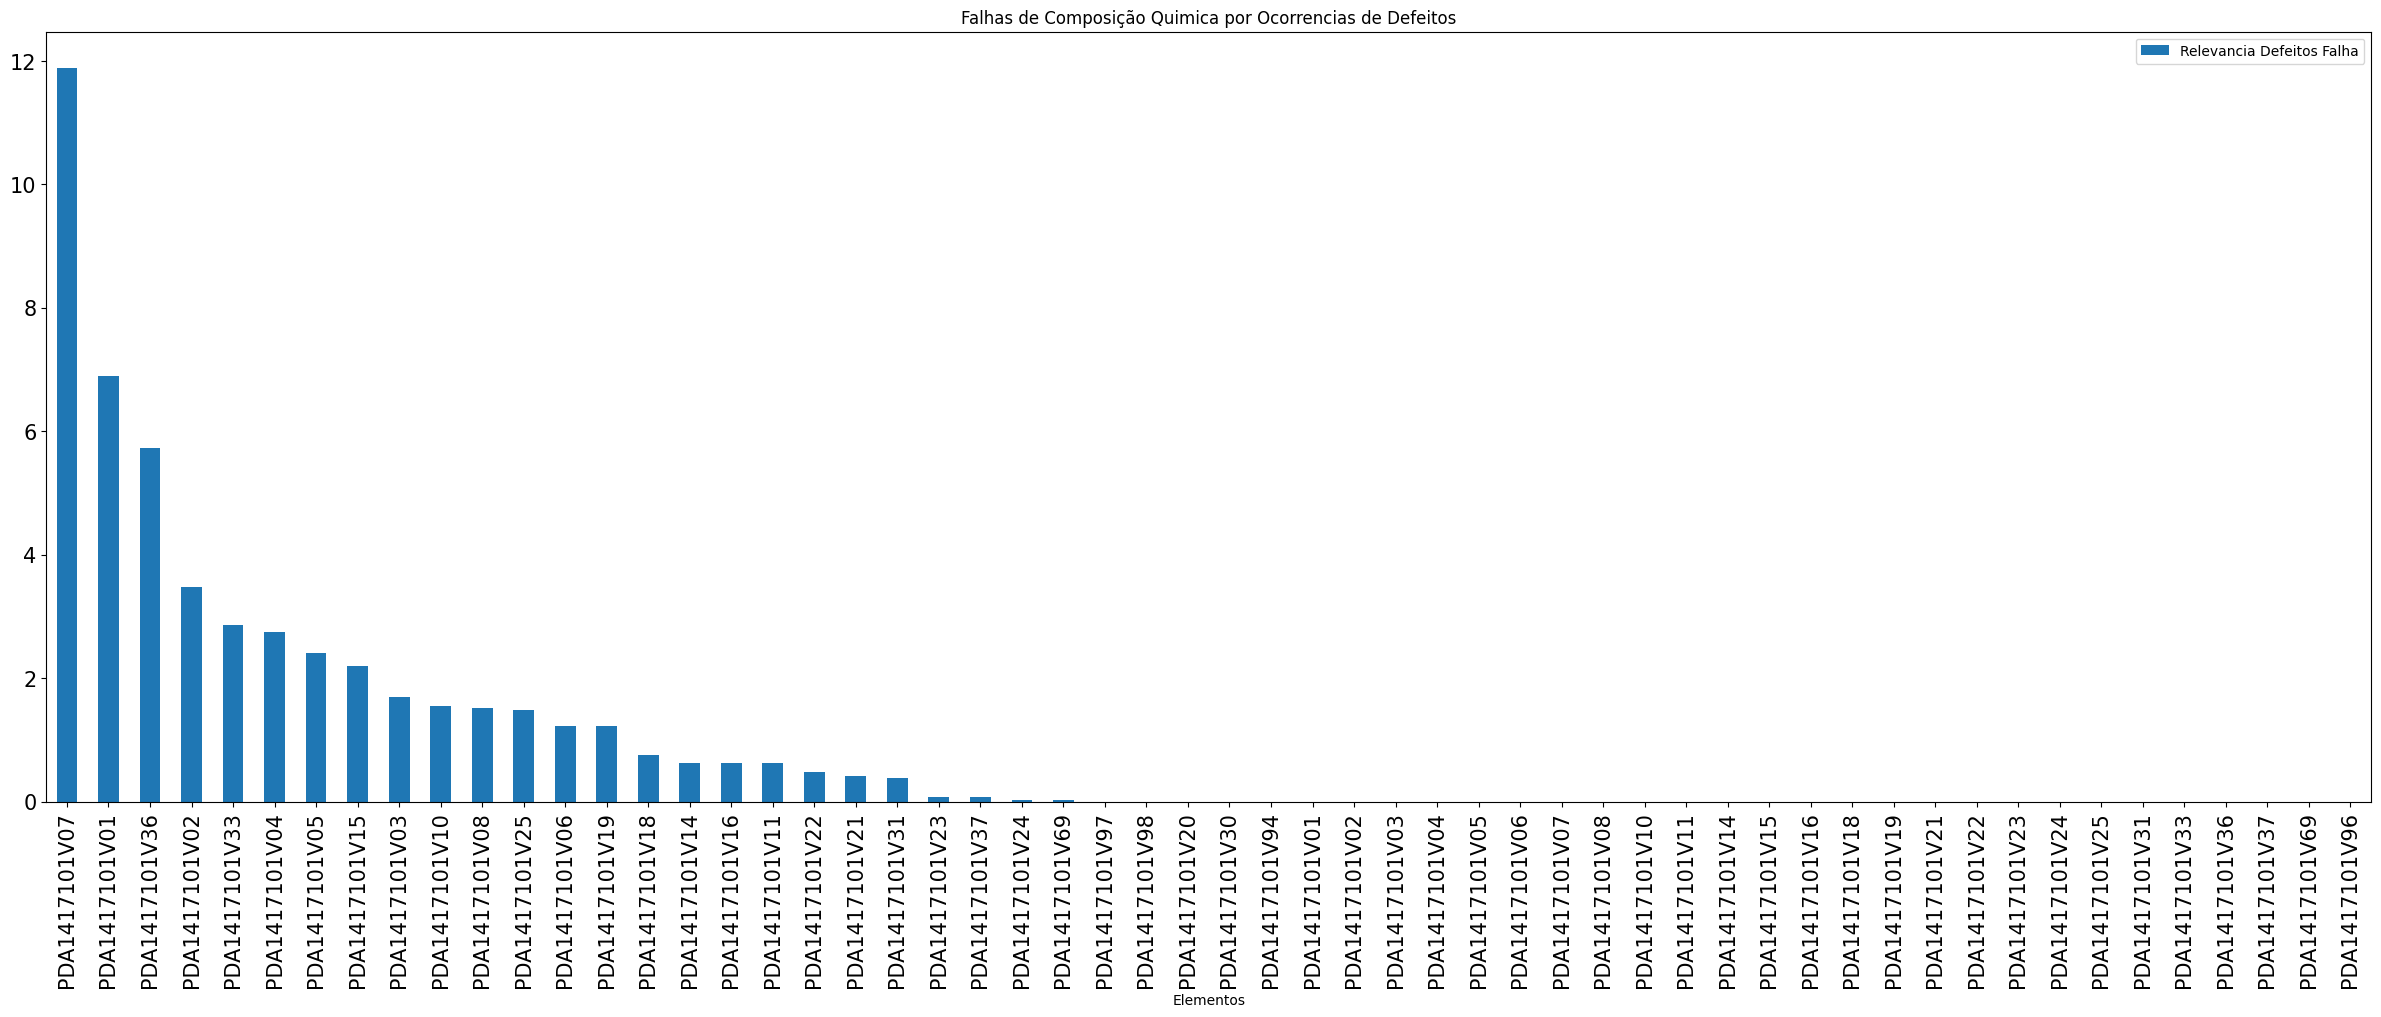

In [63]:
correlacao_quimica.sort_values(by = 'Relevancia Defeitos Falha', ascending=False, inplace=True)
correlacao_quimica.plot(kind='bar',x='Elemento',y=('Relevancia Defeitos Falha') , title='Falhas de Composição Quimica por Ocorrencias de Defeitos', figsize = (30, 10), xlabel="Elementos", fontsize=15)

<Axes: title={'center': 'Falhas de Composição Quimica por Ocorrencias de Defeitos'}, xlabel='Elementos'>

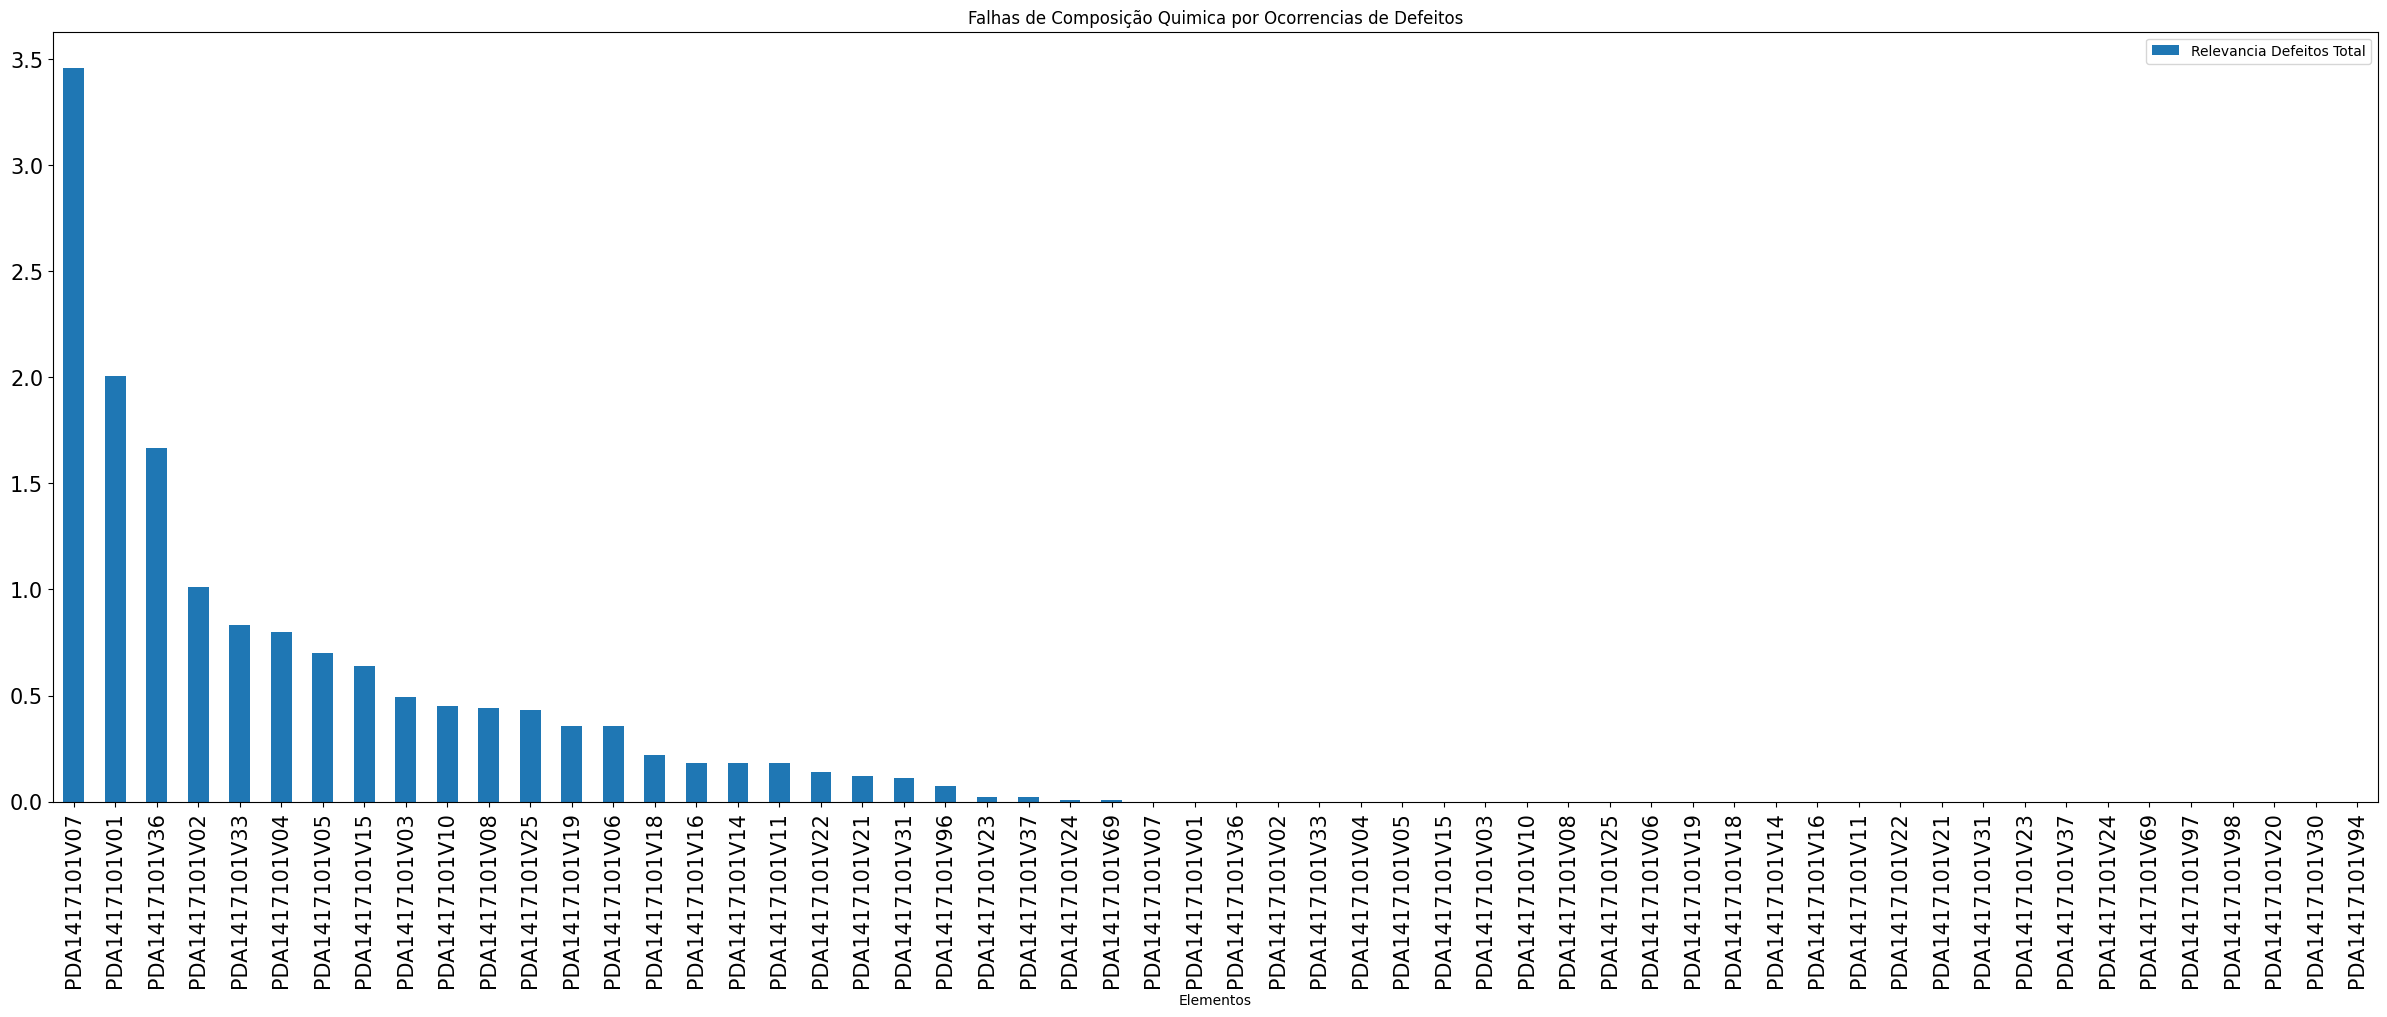

In [64]:
correlacao_quimica.sort_values(by = 'Relevancia Defeitos Total', ascending=False, inplace=True)
correlacao_quimica.plot(kind='bar',x='Elemento',y=('Relevancia Defeitos Total') , title='Falhas de Composição Quimica por Ocorrencias de Defeitos', figsize = (30, 10), xlabel="Elementos", fontsize=15)

####ANALISE CARACTERISTICAS DIMENSIONAIS

Formatação das variaveis: 
count    55631.000000
mean        -0.663299
std          4.411277
min        -30.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: GAP_ESPESS_PLAN, dtype: float64



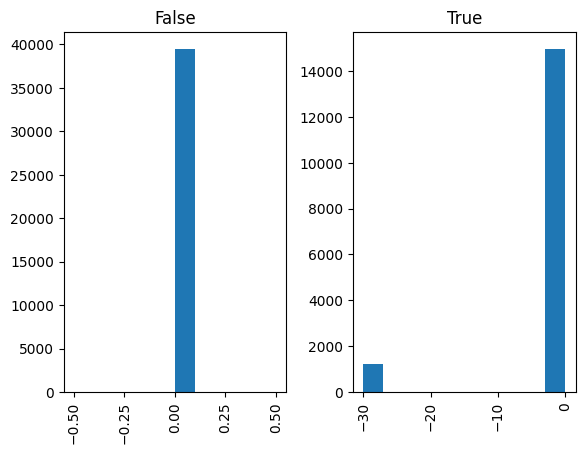

In [65]:
data_analysis.hist(column='GAP_ESPESS_PLAN', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_ESPESS_PLAN'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean        -0.393560
std          2.638343
min        -17.454000
25%         -0.069000
50%          0.010000
75%          0.027000
max         24.501000
Name: GAP_PESO_PLAN, dtype: float64



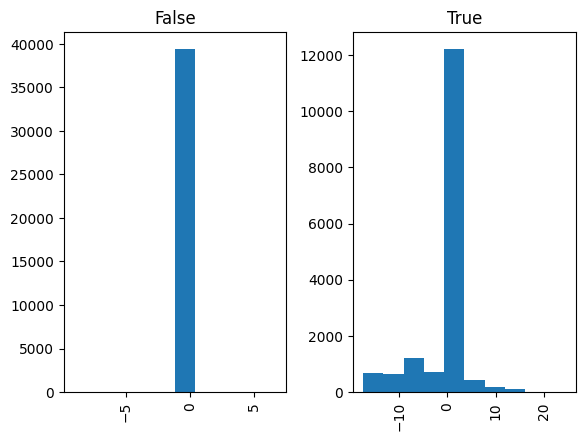

In [66]:
data_analysis.hist(column='GAP_PESO_PLAN', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_PESO_PLAN'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean       -10.298918
std        133.942281
min       -841.528843
25%          2.000000
50%         12.000000
75%         18.000000
max        462.000000
Name: GAP_LARGURA_PLAN, dtype: float64



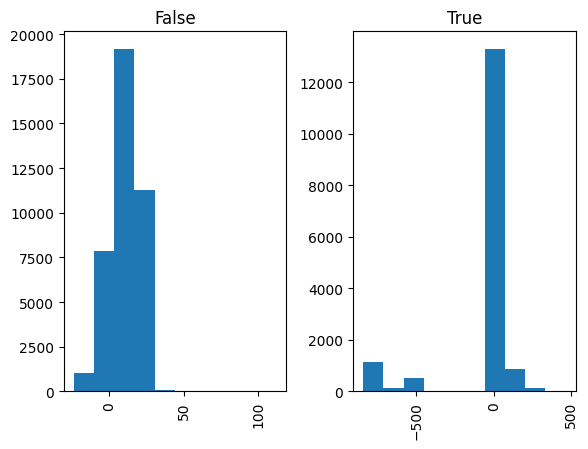

In [67]:
data_analysis.hist(column='GAP_LARGURA_PLAN', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_LARGURA_PLAN'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean        11.379777
std         15.776222
min       -285.000000
25%          3.000000
50%         12.000000
75%         18.000000
max        462.000000
Name: GAP_LARGU_CABECA, dtype: float64



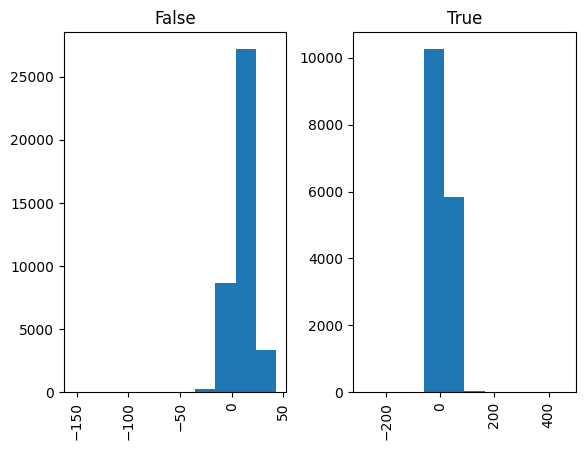

In [68]:
data_analysis.hist(column='GAP_LARGU_CABECA', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_LARGU_CABECA'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean        11.510292
std         16.058677
min       -285.000000
25%          3.000000
50%         12.000000
75%         18.000000
max        462.000000
Name: GAP_LARGU_CAUDA, dtype: float64



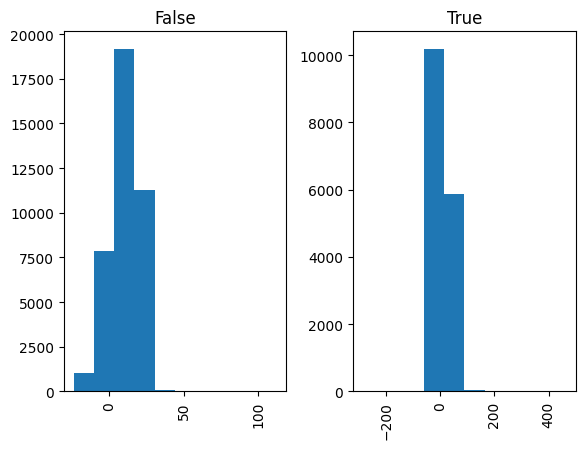

In [69]:
data_analysis.hist(column='GAP_LARGU_CAUDA', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_LARGU_CAUDA'].describe(include='all')))

####ANALISE DE EQUIPAMENTOS

Defeitos  KR_NO
False     1.0      22236
          2.0      17069
          0.0        138
True      1.0       9326
          2.0       6815
          0.0         47
Name: KR_NO, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         1.426003
std          0.501179
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: KR_NO, dtype: float64



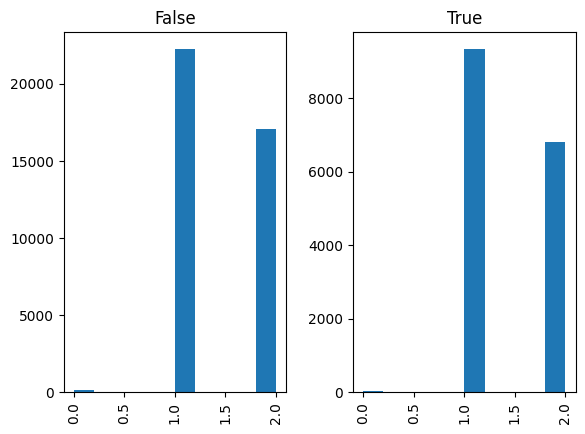

In [70]:
print(data_analysis.groupby('Defeitos')['KR_NO'].value_counts(dropna=False))
data_analysis.hist(column='KR_NO', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_NO'].describe(include='all')))

Defeitos  BOF_NO
False     1.0       21593
          2.0       17850
True      2.0        9241
          1.0        6947
Name: BOF_NO, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         1.486977
std          0.499835
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: BOF_NO, dtype: float64



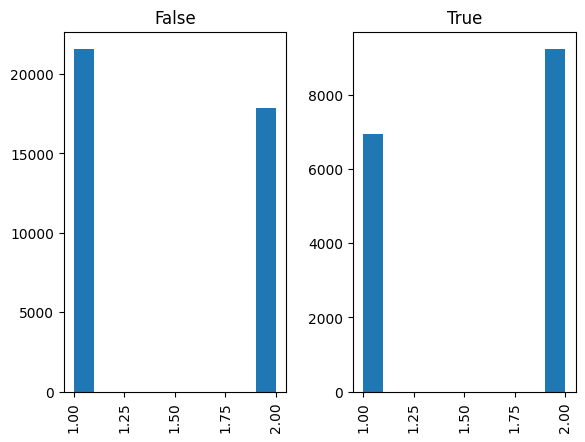

In [71]:
print(data_analysis.groupby('Defeitos')['BOF_NO'].value_counts(dropna=False))
data_analysis.hist(column='BOF_NO', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BOF_NO'].describe(include='all')))

Defeitos  BAP_NO
False     1.0       21522
          2.0       17803
          0.0         118
True      2.0        9225
          1.0        6937
          0.0          26
Name: BAP_NO, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         1.483256
std          0.504877
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: BAP_NO, dtype: float64



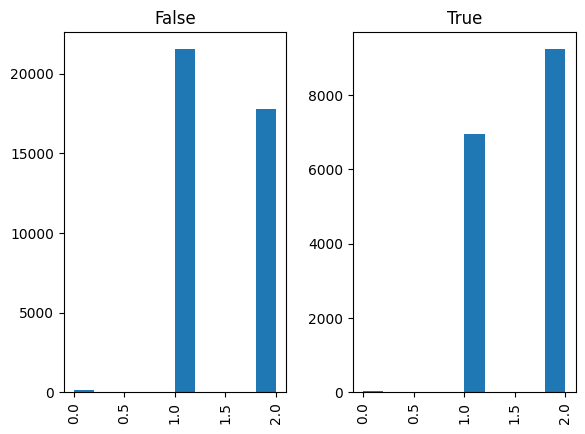

In [72]:
print(data_analysis.groupby('Defeitos')['BAP_NO'].value_counts(dropna=False))
data_analysis.hist(column='BAP_NO', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_NO'].describe(include='all')))

####ANALISE DE EVENTOS DE QUALIDADE

Defeitos  NoEvent
False     0.0        39443
True      0.0        16188
Name: NoEvent, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: NoEvent, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

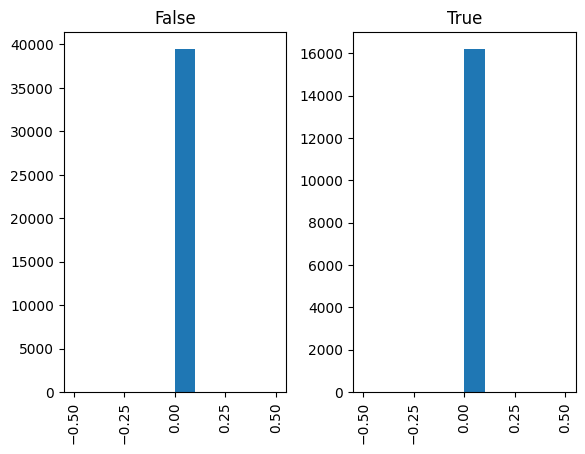

In [73]:
print(data_analysis.groupby('Defeitos')['NoEvent'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['NoEvent'].describe(include='all')))

data_analysis.hist(column='NoEvent', by='Defeitos')

Defeitos  S100
False     0.0     39441
          1.0         2
True      0.0     15574
          1.0       499
          2.0       108
          3.0         5
          4.0         1
          5.0         1
Name: S100, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.013320
std          0.134685
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: S100, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

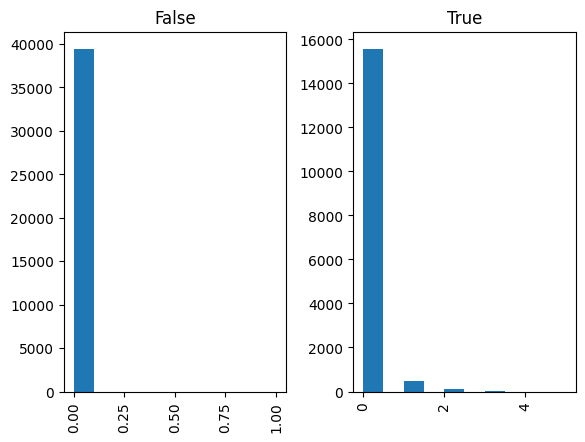

In [74]:
print(data_analysis.groupby('Defeitos')['S100'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S100'].describe(include='all')))

data_analysis['S100'].describe(include='all')
data_analysis.hist(column='S100', by='Defeitos')

Defeitos  S101
False     0.0     39443
True      0.0     15563
          1.0       579
          2.0        43
          3.0         2
          4.0         1
Name: S101, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.012134
std          0.118169
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S101, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

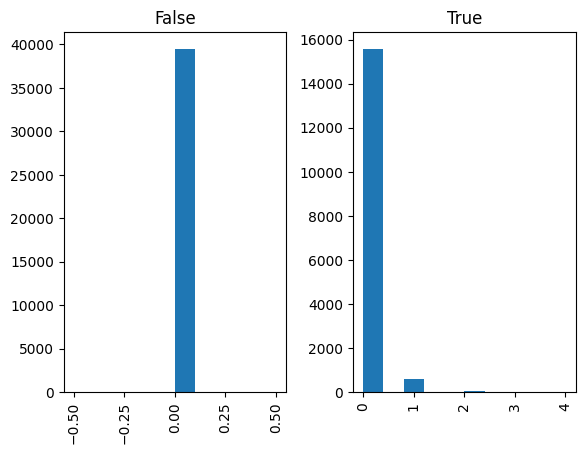

In [75]:
print(data_analysis.groupby('Defeitos')['S101'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S101'].describe(include='all')))

data_analysis['S101'].describe(include='all')
data_analysis.hist(column='S101', by='Defeitos')

Defeitos  S102
False     0.0     39441
          1.0         2
True      0.0     15749
          1.0       393
          2.0        42
          3.0         4
Name: S102, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.008826
std          0.103391
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: S102, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

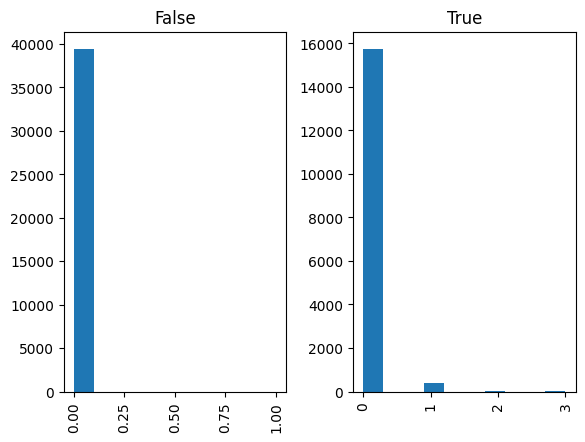

In [76]:
print(data_analysis.groupby('Defeitos')['S102'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S102'].describe(include='all')))

data_analysis['S102'].describe(include='all')
data_analysis.hist(column='S102', by='Defeitos')

Defeitos  S103
False     0.0     39443
True      0.0     15854
          1.0       258
          2.0        74
          3.0         1
          4.0         1
Name: S103, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.007424
std          0.101749
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S103, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

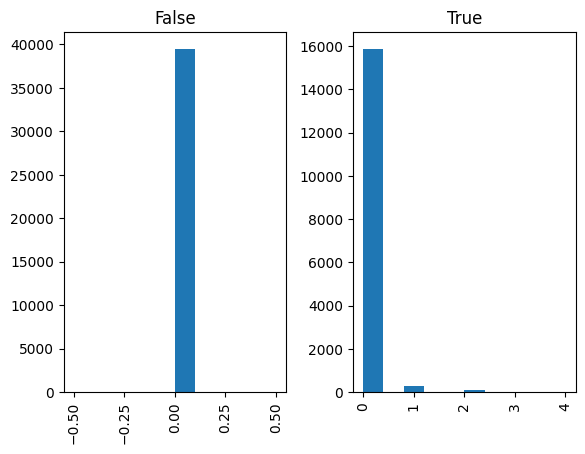

In [77]:
print(data_analysis.groupby('Defeitos')['S103'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S103'].describe(include='all')))

data_analysis['S103'].describe(include='all')
data_analysis.hist(column='S103', by='Defeitos')

Defeitos  S104
False     0.0     39382
          1.0        61
True      0.0     16155
          1.0        33
Name: S104, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.001690
std          0.041072
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S104, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

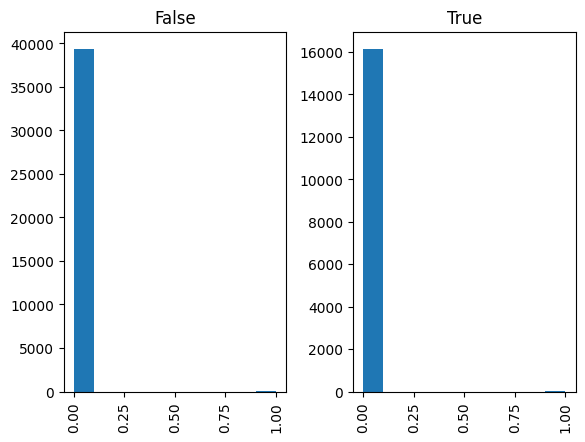

In [78]:
print(data_analysis.groupby('Defeitos')['S104'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S104'].describe(include='all')))

data_analysis['S104'].describe(include='all')
data_analysis.hist(column='S104', by='Defeitos')

Defeitos  S105
False     0.0     39440
          1.0         3
True      0.0     16157
          1.0        29
          2.0         2
Name: S105, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000647
std          0.026807
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S105, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

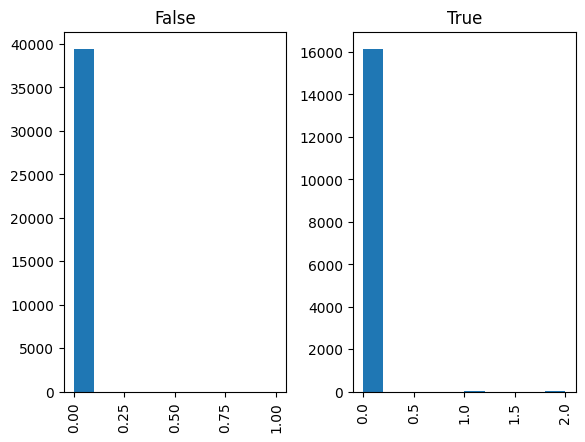

In [79]:
print(data_analysis.groupby('Defeitos')['S105'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S105'].describe(include='all')))

data_analysis['S105'].describe(include='all')
data_analysis.hist(column='S105', by='Defeitos')

Defeitos  S106
False     0.0     39441
          1.0         2
True      0.0     16175
          1.0        13
Name: S106, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000270
std          0.016418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S106, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

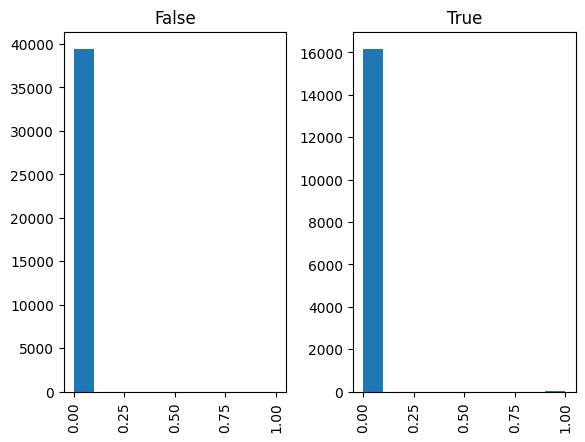

In [80]:
print(data_analysis.groupby('Defeitos')['S106'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S106'].describe(include='all')))

data_analysis['S106'].describe(include='all')
data_analysis.hist(column='S106', by='Defeitos')

Defeitos  S107
False     0.0     39442
          1.0         1
True      0.0     16186
          2.0         2
Name: S107, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000090
std          0.012719
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S107, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

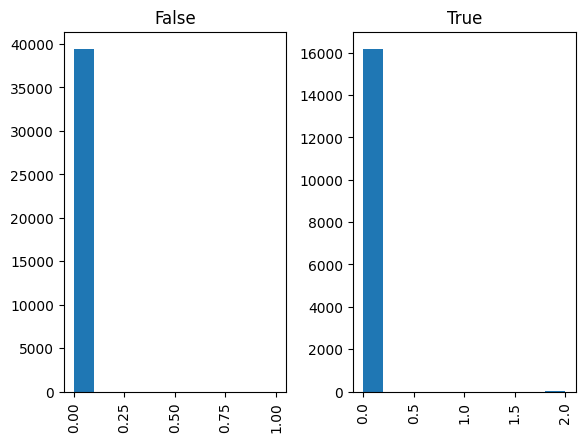

In [81]:
print(data_analysis.groupby('Defeitos')['S107'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S107'].describe(include='all')))

data_analysis['S107'].describe(include='all')
data_analysis.hist(column='S107', by='Defeitos')

Defeitos  S108
False     0.0     39443
True      0.0     16187
          1.0         1
Name: S108, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S108, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

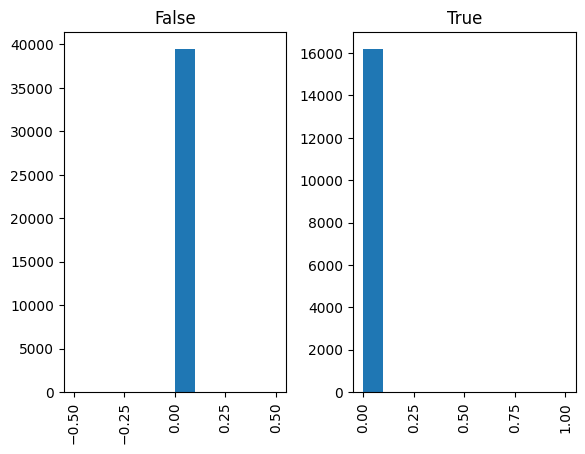

In [82]:
print(data_analysis.groupby('Defeitos')['S108'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S108'].describe(include='all')))

data_analysis['S108'].describe(include='all')
data_analysis.hist(column='S108', by='Defeitos')

Defeitos  S109
False     0.0     39443
True      0.0     16186
          1.0         1
          2.0         1
Name: S109, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000054
std          0.009480
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S109, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

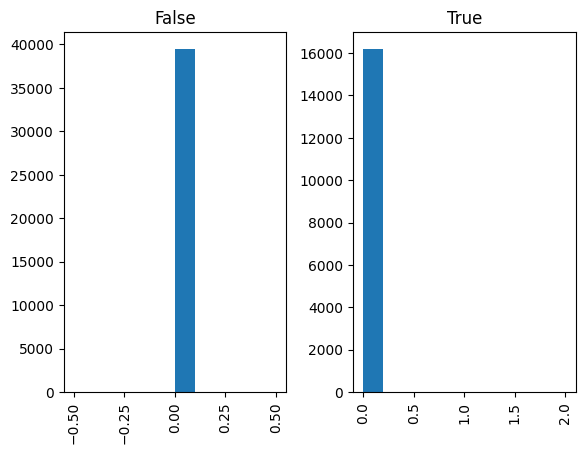

In [83]:
print(data_analysis.groupby('Defeitos')['S109'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S109'].describe(include='all')))

data_analysis['S109'].describe(include='all')
data_analysis.hist(column='S109', by='Defeitos')

Defeitos  S111
False     0.0     39388
          1.0        54
          2.0         1
True      0.0     15836
          1.0       298
          2.0        48
          3.0         3
          4.0         2
          5.0         1
Name: S111, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.008484
std          0.106249
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: S111, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

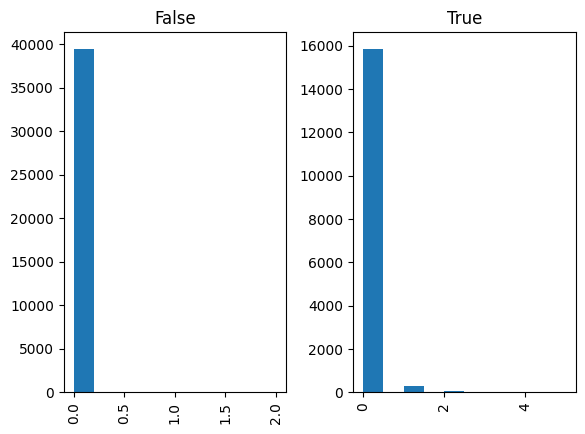

In [84]:
print(data_analysis.groupby('Defeitos')['S111'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S111'].describe(include='all')))

data_analysis['S111'].describe(include='all')
data_analysis.hist(column='S111', by='Defeitos')

Defeitos  S113
False     0.0     39442
          1.0         1
True      0.0     15552
          1.0       469
          2.0       156
          3.0         8
          4.0         3
Name: S113, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.014704
std          0.146992
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S113, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

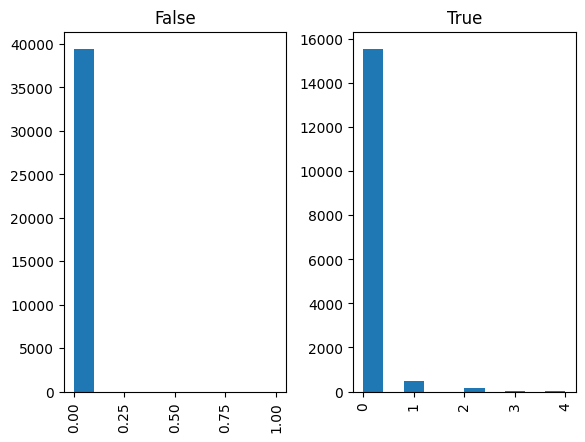

In [85]:
print(data_analysis.groupby('Defeitos')['S113'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S113'].describe(include='all')))

data_analysis['S113'].describe(include='all')
data_analysis.hist(column='S113', by='Defeitos')

Defeitos  S122
False     0.0     39442
          1.0         1
True      0.0     14399
          1.0      1775
          2.0        14
Name: S122, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.032428
std          0.178550
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S122, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

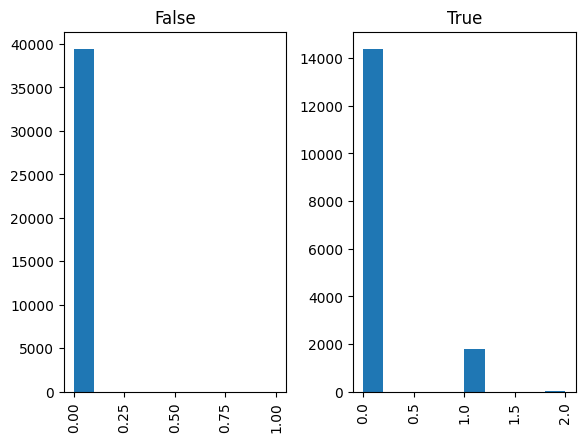

In [86]:
print(data_analysis.groupby('Defeitos')['S122'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S122'].describe(include='all')))

data_analysis['S122'].describe(include='all')
data_analysis.hist(column='S122', by='Defeitos')

Defeitos  S123
False     0.0     39443
True      0.0     16156
          1.0        24
          2.0         8
Name: S123, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000719
std          0.031720
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S123, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

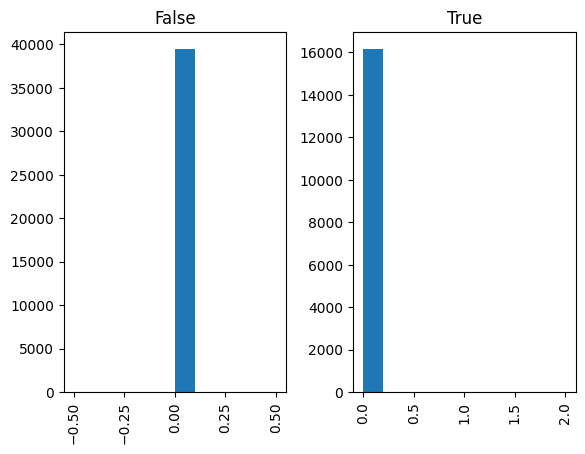

In [87]:
print(data_analysis.groupby('Defeitos')['S123'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S123'].describe(include='all')))

data_analysis['S123'].describe(include='all')
data_analysis.hist(column='S123', by='Defeitos')

Defeitos  S125
False     0.0     39443
True      0.0     16133
          1.0        55
Name: S125, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000989
std          0.031428
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S125, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

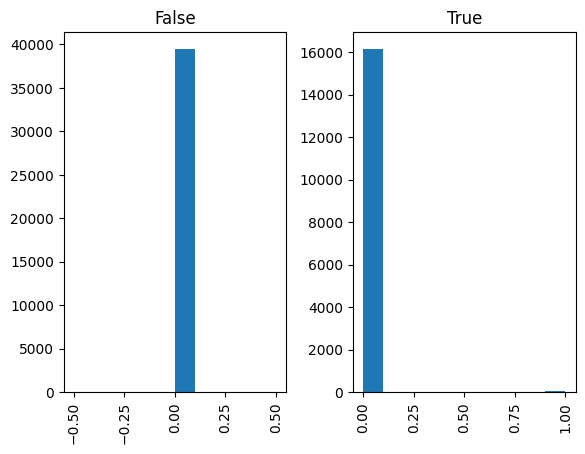

In [88]:
print(data_analysis.groupby('Defeitos')['S125'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S125'].describe(include='all')))

data_analysis['S125'].describe(include='all')
data_analysis.hist(column='S125', by='Defeitos')

Defeitos  S126
False     0.0     39443
True      0.0     16096
          1.0        77
          2.0        15
Name: S126, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.001923
std          0.049588
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S126, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

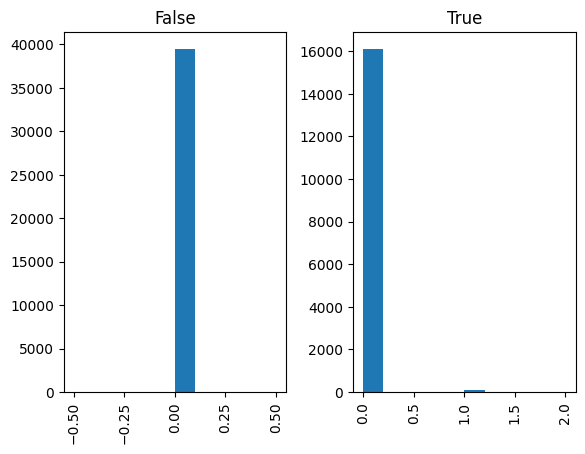

In [89]:
print(data_analysis.groupby('Defeitos')['S126'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S126'].describe(include='all')))

data_analysis['S126'].describe(include='all')
data_analysis.hist(column='S126', by='Defeitos')

Defeitos  S127
False     0.0     39443
True      0.0     15824
          1.0       302
          2.0        60
          3.0         1
          4.0         1
Name: S127, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.007712
std          0.100662
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S127, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

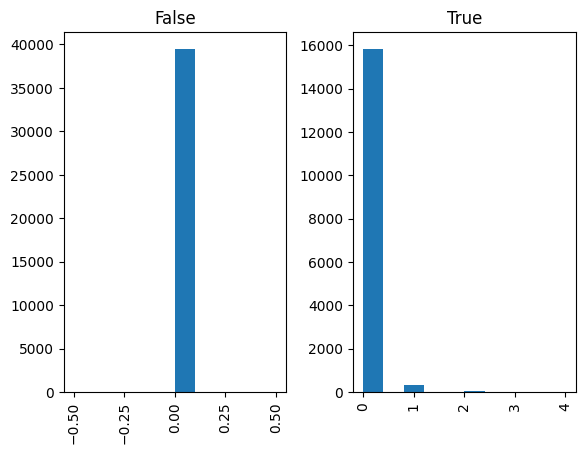

In [90]:
print(data_analysis.groupby('Defeitos')['S127'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S127'].describe(include='all')))

data_analysis['S127'].describe(include='all')
data_analysis.hist(column='S127', by='Defeitos')

Defeitos  S128
False     0.0     39442
          1.0         1
True      0.0     14446
          1.0      1432
          2.0       296
          3.0        10
          4.0         4
Name: S128, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.037227
std          0.220058
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S128, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

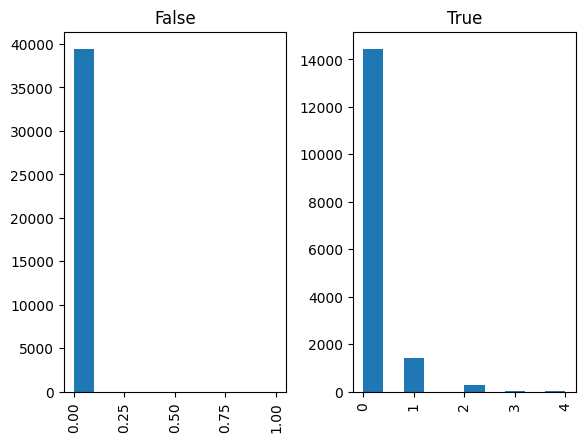

In [91]:
print(data_analysis.groupby('Defeitos')['S128'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S128'].describe(include='all')))

data_analysis['S128'].describe(include='all')
data_analysis.hist(column='S128', by='Defeitos')

Defeitos  S129
False     0.0     39443
True      0.0     16188
Name: S129, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: S129, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

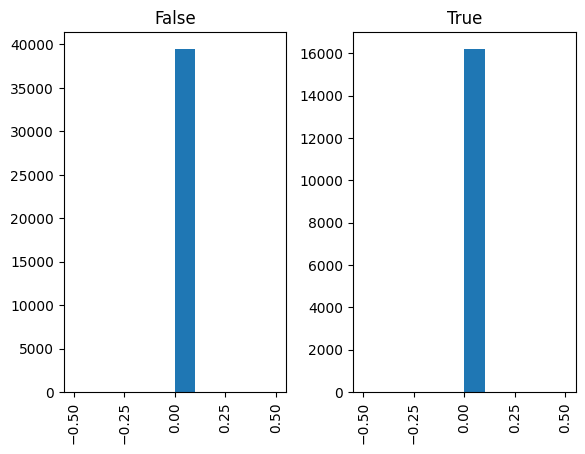

In [92]:
print(data_analysis.groupby('Defeitos')['S129'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S129'].describe(include='all')))

data_analysis['S129'].describe(include='all')
data_analysis.hist(column='S129', by='Defeitos')

Defeitos  S130
False     0.0     39432
          1.0        11
True      0.0     16181
          1.0         7
Name: S130, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000324
std          0.017985
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S130, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

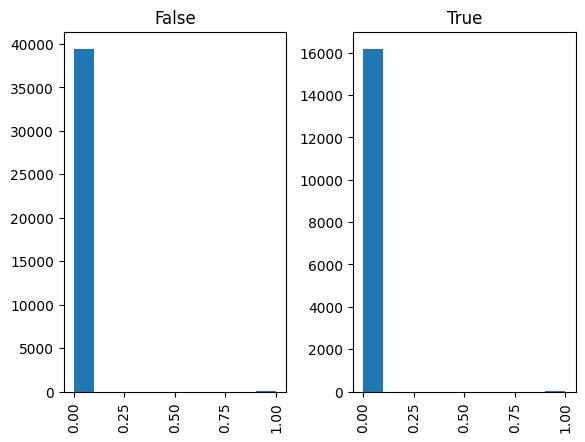

In [93]:
print(data_analysis.groupby('Defeitos')['S130'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S130'].describe(include='all')))

data_analysis['S130'].describe(include='all')
data_analysis.hist(column='S130', by='Defeitos')

Defeitos  S131
False     0.0     39443
True      0.0     16185
          1.0         3
Name: S131, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000054
std          0.007343
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S131, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

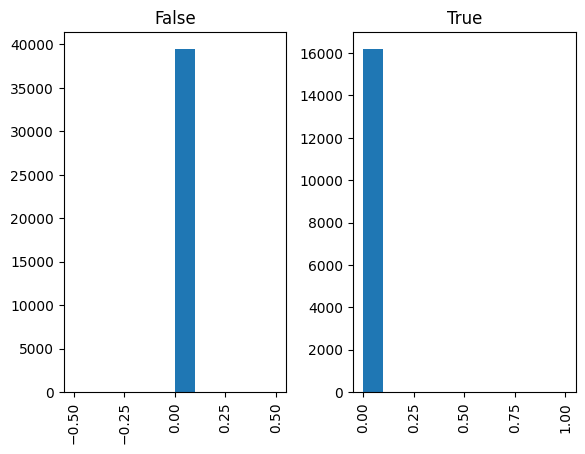

In [94]:
print(data_analysis.groupby('Defeitos')['S131'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S131'].describe(include='all')))

data_analysis['S131'].describe(include='all')
data_analysis.hist(column='S131', by='Defeitos')

Defeitos  S134
False     0.0     39443
True      0.0     16188
Name: S134, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: S134, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

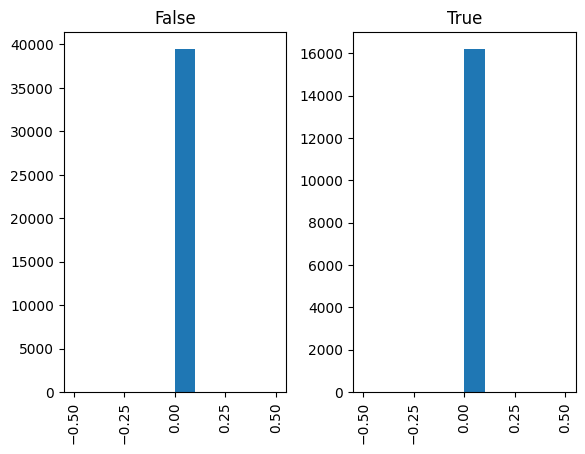

In [95]:
print(data_analysis.groupby('Defeitos')['S134'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S134'].describe(include='all')))

data_analysis['S134'].describe(include='all')
data_analysis.hist(column='S134', by='Defeitos')

Defeitos  S135
False     0.0     39443
True      0.0     16172
          1.0        16
Name: S135, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000288
std          0.016957
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S135, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

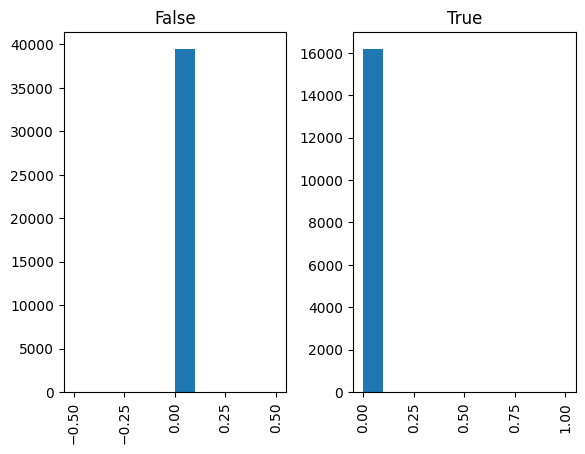

In [96]:
print(data_analysis.groupby('Defeitos')['S135'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S135'].describe(include='all')))

data_analysis['S135'].describe(include='all')
data_analysis.hist(column='S135', by='Defeitos')

Defeitos  S136
False     0.0     39441
          1.0         2
True      0.0     16139
          1.0        46
          2.0         3
Name: S136, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000971
std          0.032827
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S136, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

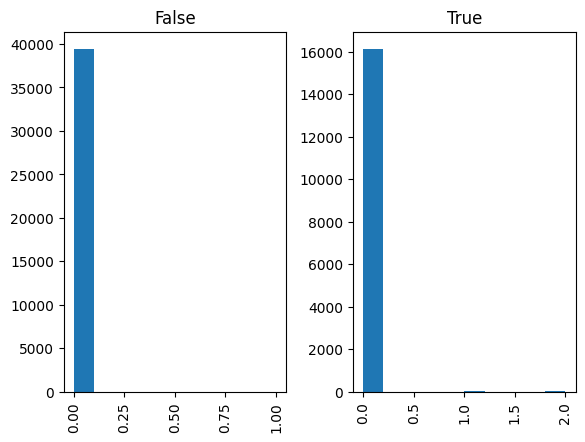

In [97]:
print(data_analysis.groupby('Defeitos')['S136'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S136'].describe(include='all')))

data_analysis['S136'].describe(include='all')
data_analysis.hist(column='S136', by='Defeitos')

Defeitos  S137
False     0.0     39441
          1.0         2
True      0.0     16183
          1.0         5
Name: S137, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000126
std          0.011217
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S137, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

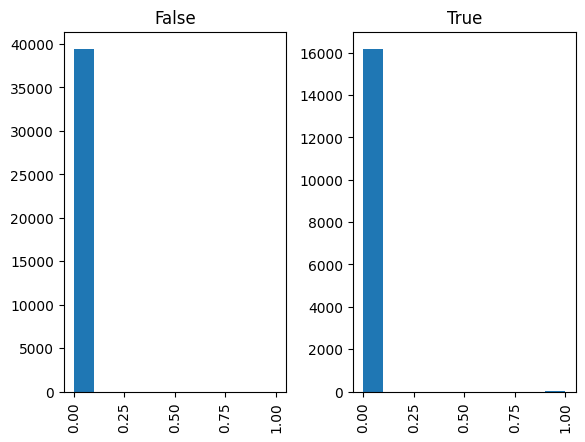

In [98]:
print(data_analysis.groupby('Defeitos')['S137'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S137'].describe(include='all')))

data_analysis['S137'].describe(include='all')
data_analysis.hist(column='S137', by='Defeitos')

Defeitos  S138
False     0.0     39443
True      0.0     16186
          1.0         2
Name: S138, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000036
std          0.005996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S138, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

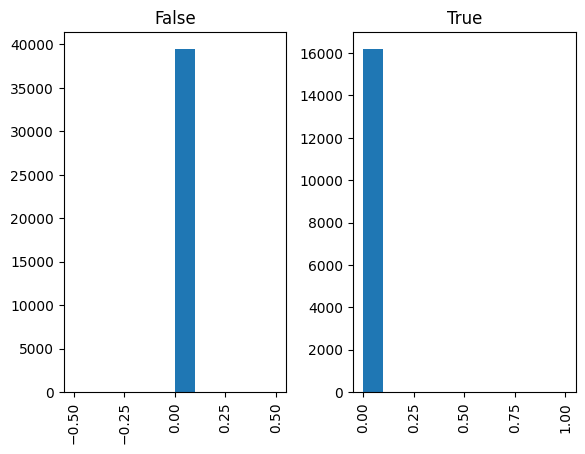

In [99]:
print(data_analysis.groupby('Defeitos')['S138'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S138'].describe(include='all')))

data_analysis['S138'].describe(include='all')
data_analysis.hist(column='S138', by='Defeitos')

Defeitos  S141
False     0.0     39443
True      0.0     16187
          1.0         1
Name: S141, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S141, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

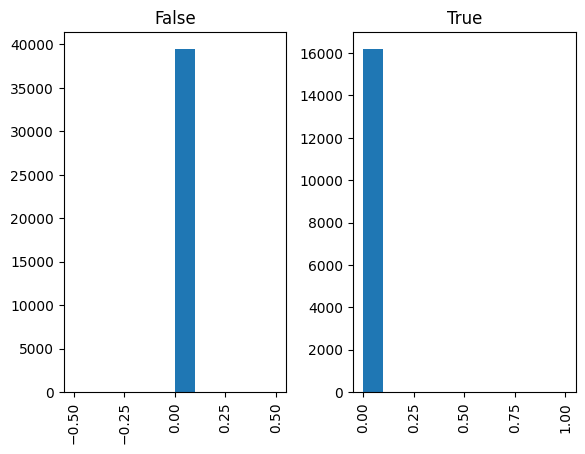

In [100]:
print(data_analysis.groupby('Defeitos')['S141'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S141'].describe(include='all')))

data_analysis['S141'].describe(include='all')
data_analysis.hist(column='S141', by='Defeitos')

Defeitos  S142
False     0.0     39443
True      0.0     16186
          1.0         2
Name: S142, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000036
std          0.005996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S142, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

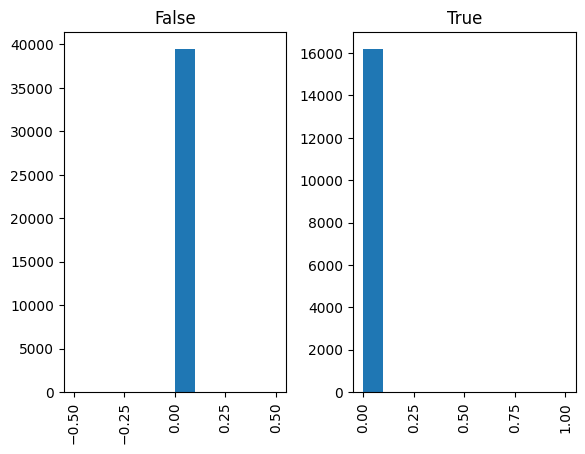

In [101]:
print(data_analysis.groupby('Defeitos')['S142'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S142'].describe(include='all')))

data_analysis['S142'].describe(include='all')
data_analysis.hist(column='S142', by='Defeitos')

Defeitos  S143
False     0.0     39443
True      0.0     16186
          1.0         2
Name: S143, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000036
std          0.005996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S143, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

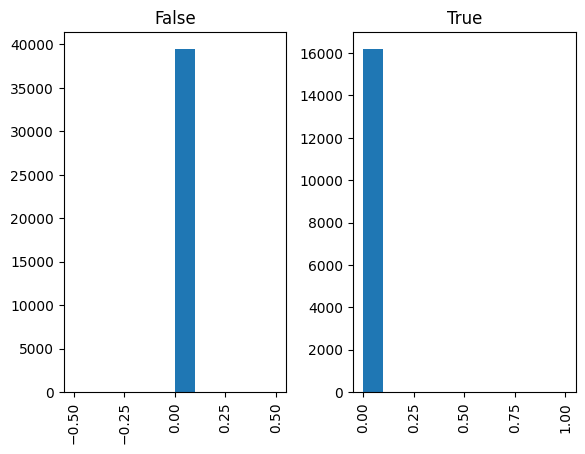

In [102]:
print(data_analysis.groupby('Defeitos')['S143'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S143'].describe(include='all')))

data_analysis['S143'].describe(include='all')
data_analysis.hist(column='S143', by='Defeitos')

Defeitos  S144
False     0.0     39442
          1.0         1
True      0.0     16188
Name: S144, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S144, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

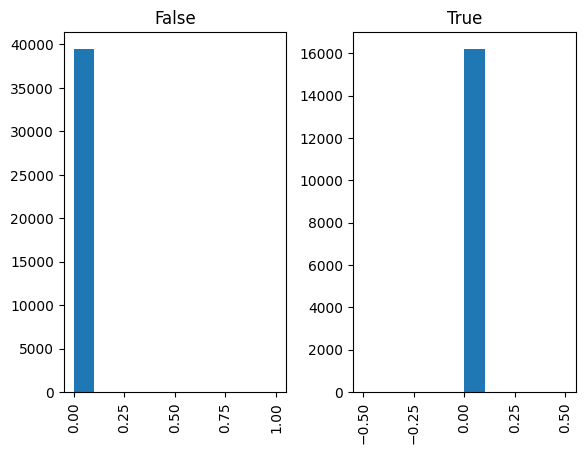

In [103]:
print(data_analysis.groupby('Defeitos')['S144'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S144'].describe(include='all')))

data_analysis['S144'].describe(include='all')
data_analysis.hist(column='S144', by='Defeitos')

Defeitos  S145
False     0.0     39432
          1.0        11
True      0.0     16106
          1.0        67
          2.0        15
Name: S145, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.001941
std          0.049769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S145, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

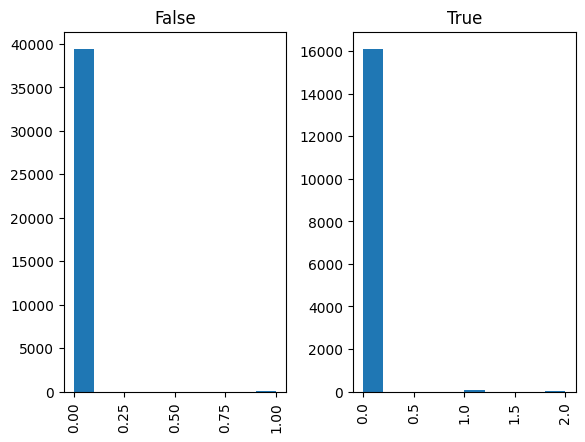

In [104]:
print(data_analysis.groupby('Defeitos')['S145'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S145'].describe(include='all')))

data_analysis['S145'].describe(include='all')
data_analysis.hist(column='S145', by='Defeitos')

Defeitos  S146
False     0.0     39433
          1.0        10
True      0.0     16160
          1.0        27
          2.0         1
Name: S146, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000701
std          0.027139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S146, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

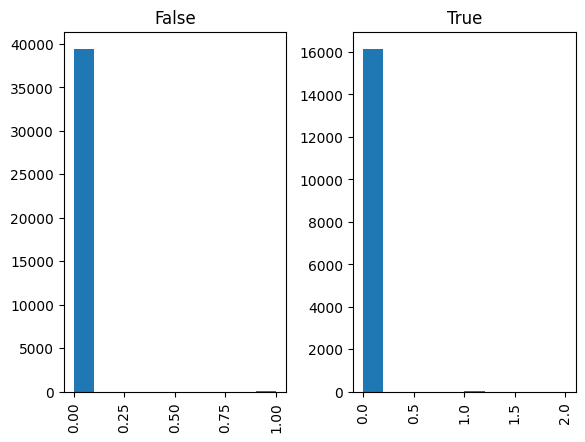

In [105]:
print(data_analysis.groupby('Defeitos')['S146'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S146'].describe(include='all')))

data_analysis['S146'].describe(include='all')
data_analysis.hist(column='S146', by='Defeitos')

Defeitos  S147
False     0.0     39443
True      0.0     16061
          1.0        84
          2.0        38
          3.0         4
          4.0         1
Name: S147, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.003164
std          0.071882
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S147, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

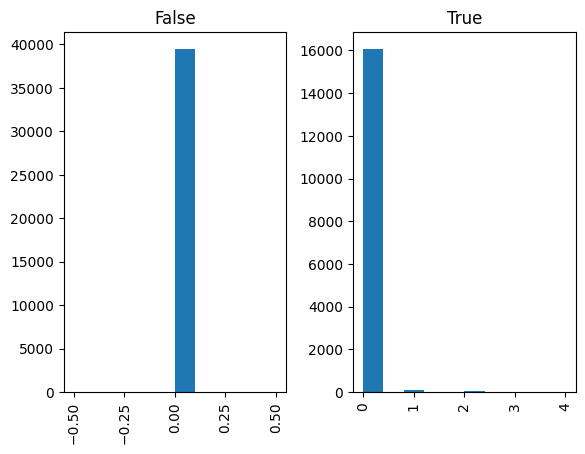

In [106]:
print(data_analysis.groupby('Defeitos')['S147'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S147'].describe(include='all')))

data_analysis['S147'].describe(include='all')
data_analysis.hist(column='S147', by='Defeitos')

Defeitos  S148
False     0.0     39443
True      0.0     15962
          1.0       160
          2.0        63
          3.0         2
          4.0         1
Name: S148, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.005321
std          0.089381
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S148, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

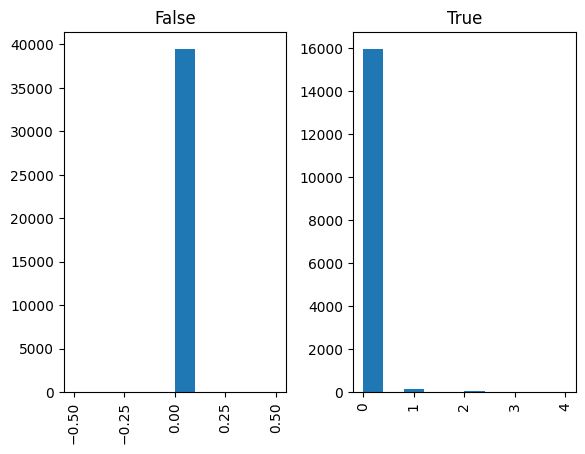

In [107]:
print(data_analysis.groupby('Defeitos')['S148'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S148'].describe(include='all')))

data_analysis['S148'].describe(include='all')
data_analysis.hist(column='S148', by='Defeitos')

Defeitos  S149
False     0.0     39443
True      0.0     15839
          1.0       345
          2.0         4
Name: S149, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.006345
std          0.080306
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S149, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

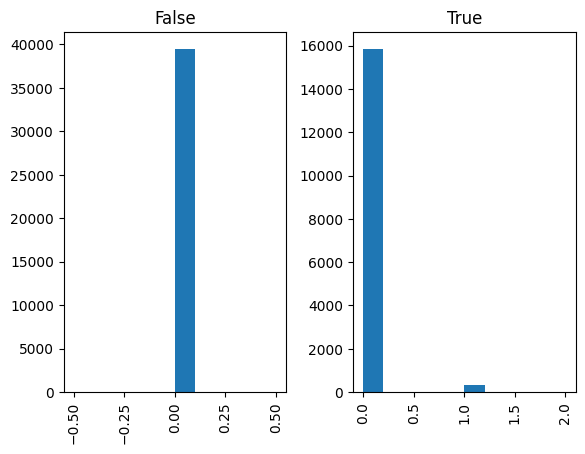

In [108]:
print(data_analysis.groupby('Defeitos')['S149'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S149'].describe(include='all')))

data_analysis['S149'].describe(include='all')
data_analysis.hist(column='S149', by='Defeitos')

Defeitos  S150
False     0.0     39321
          1.0       122
True      0.0     12307
          1.0      3574
          2.0       292
          3.0         8
          4.0         6
          5.0         1
Name: S150, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.077888
std          0.291269
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: S150, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

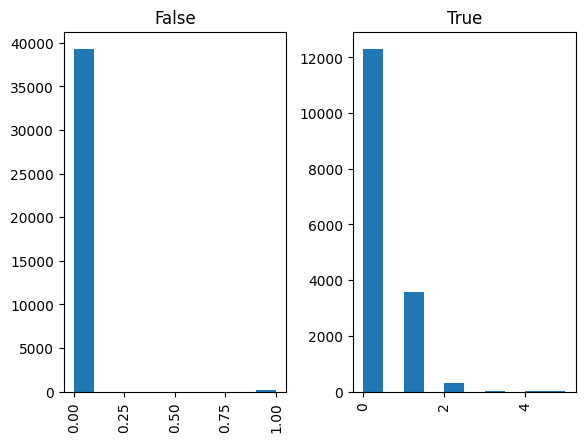

In [109]:
print(data_analysis.groupby('Defeitos')['S150'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S150'].describe(include='all')))

data_analysis['S150'].describe(include='all')
data_analysis.hist(column='S150', by='Defeitos')

Defeitos  S152
False     0.0     39443
True      0.0     16187
          1.0         1
Name: S152, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S152, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

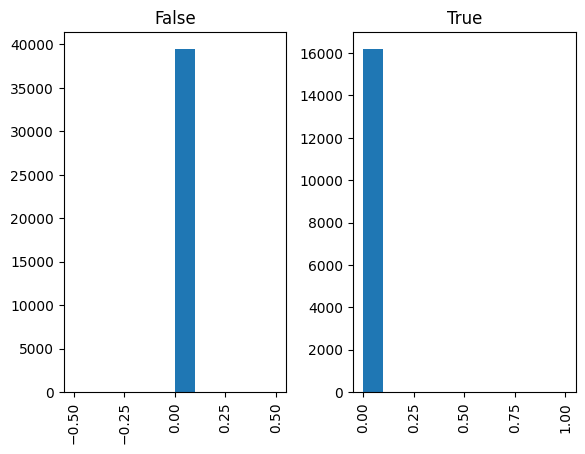

In [110]:
print(data_analysis.groupby('Defeitos')['S152'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S152'].describe(include='all')))

data_analysis['S152'].describe(include='all')
data_analysis.hist(column='S152', by='Defeitos')

Defeitos  S155
False     0.0     39443
True      0.0     15858
          1.0       327
          2.0         3
Name: S155, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.005986
std          0.077833
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S155, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

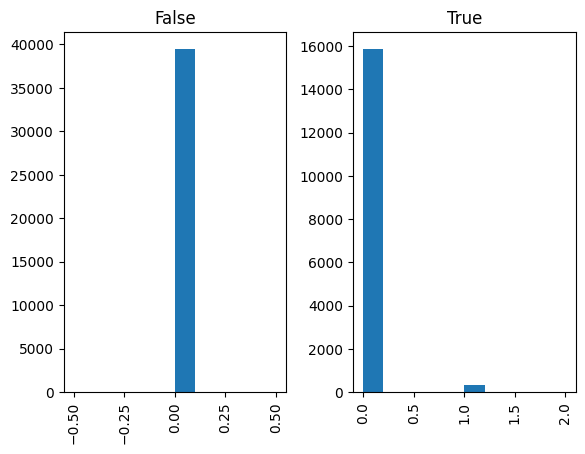

In [111]:
print(data_analysis.groupby('Defeitos')['S155'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S155'].describe(include='all')))

data_analysis['S155'].describe(include='all')
data_analysis.hist(column='S155', by='Defeitos')

Defeitos  S156
False     0.0     37455
          1.0      1988
True      0.0     14059
          1.0      2113
          2.0        11
          4.0         4
          3.0         1
Name: S156, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.074455
std          0.265101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S156, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

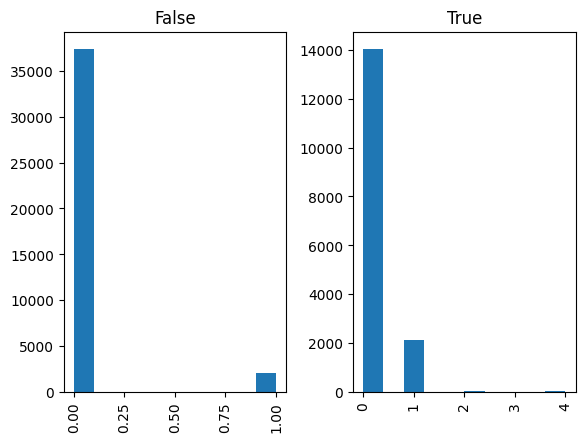

In [112]:
print(data_analysis.groupby('Defeitos')['S156'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S156'].describe(include='all')))

data_analysis['S156'].describe(include='all')
data_analysis.hist(column='S156', by='Defeitos')

Defeitos  S158
False     0.0     39443
True      0.0     16165
          1.0        21
          2.0         2
Name: S158, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000449
std          0.022828
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S158, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

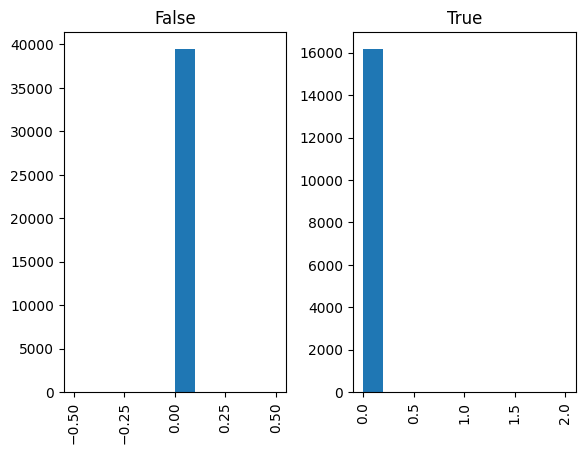

In [113]:
print(data_analysis.groupby('Defeitos')['S158'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S158'].describe(include='all')))

data_analysis['S158'].describe(include='all')
data_analysis.hist(column='S158', by='Defeitos')

Defeitos  S159
False     0.0     39442
          1.0         1
True      0.0     16140
          1.0        48
Name: S159, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000881
std          0.029666
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S159, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

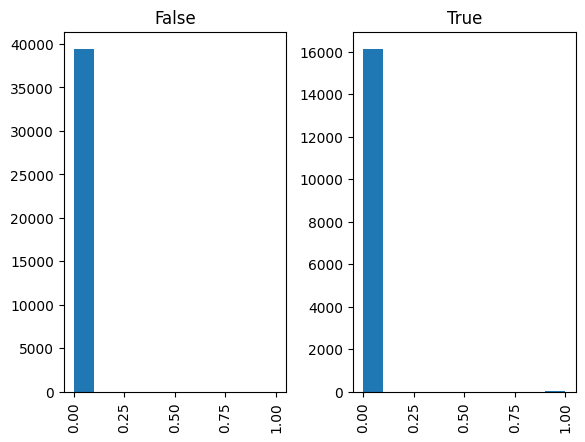

In [114]:
print(data_analysis.groupby('Defeitos')['S159'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S159'].describe(include='all')))

data_analysis['S159'].describe(include='all')
data_analysis.hist(column='S159', by='Defeitos')

Defeitos  S161
False     0.0     39443
True      0.0     16188
Name: S161, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: S161, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

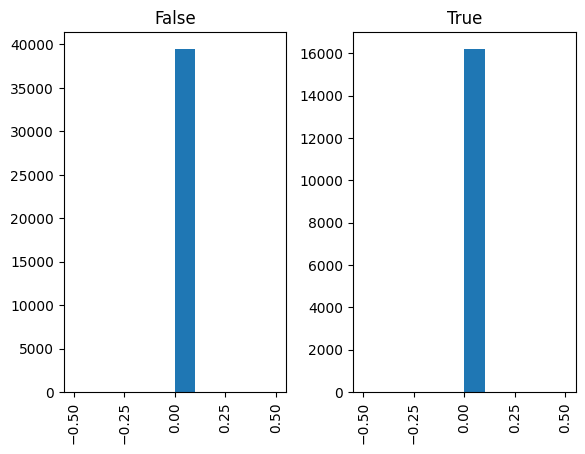

In [115]:
print(data_analysis.groupby('Defeitos')['S161'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S161'].describe(include='all')))

data_analysis['S161'].describe(include='all')
data_analysis.hist(column='S161', by='Defeitos')

Defeitos  S162
False     0.0     39441
          1.0         2
True      0.0     15099
          1.0       931
          2.0       148
          3.0         7
          4.0         2
          5.0         1
Name: S162, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.022703
std          0.170455
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: S162, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

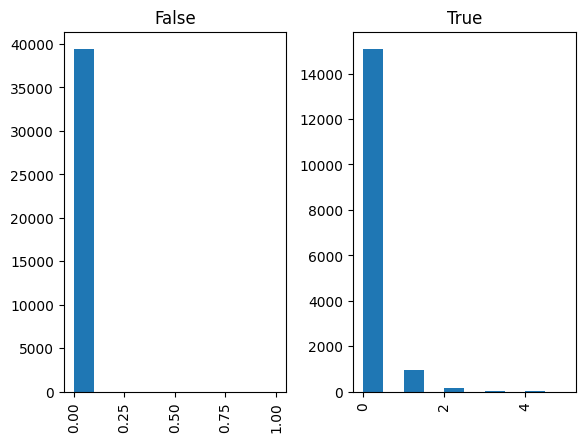

In [116]:
print(data_analysis.groupby('Defeitos')['S162'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S162'].describe(include='all')))

data_analysis['S162'].describe(include='all')
data_analysis.hist(column='S162', by='Defeitos')

Defeitos  S163
False     0.0     39443
True      0.0     16184
          2.0         3
          4.0         1
Name: S163, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000180
std          0.022434
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S163, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

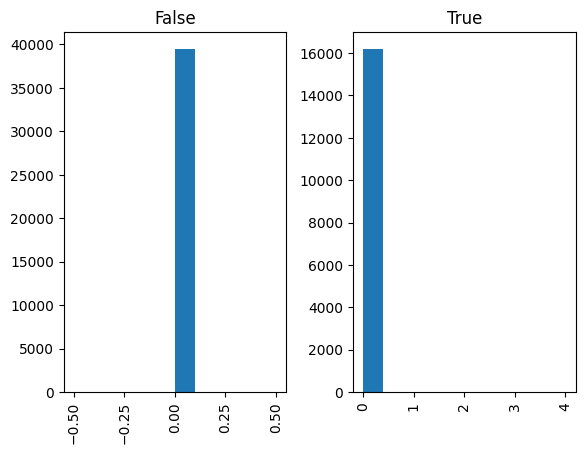

In [117]:
print(data_analysis.groupby('Defeitos')['S163'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S163'].describe(include='all')))

data_analysis['S163'].describe(include='all')
data_analysis.hist(column='S163', by='Defeitos')

####ANALISE DE TEMPOS

#####KR


Formatação das variaveis: 
count    55631.000000
mean        31.518200
std          6.934243
min          0.000000
25%         28.000000
50%         31.000000
75%         34.000000
max         59.000000
Name: KR_TOTAL_TIME, dtype: float64



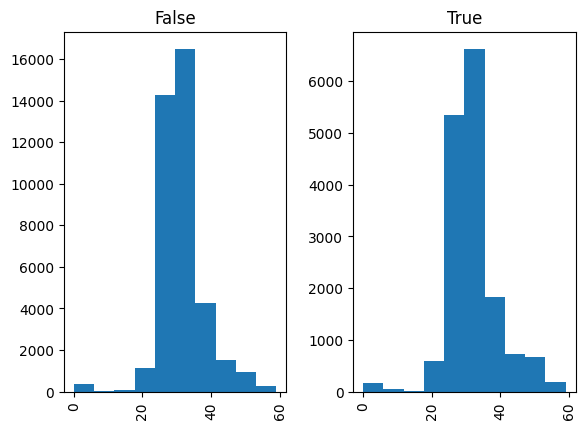

In [118]:
data_analysis.hist(column='KR_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        14.276626
std          5.561265
min          0.000000
25%         12.000000
50%         13.000000
75%         15.000000
max         58.000000
Name: KR_PROCESS_TIME, dtype: float64



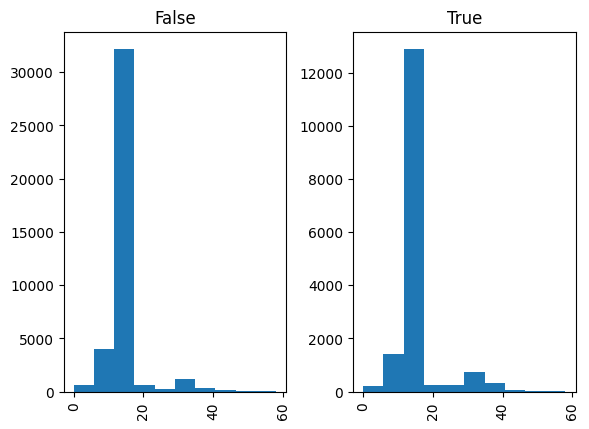

In [119]:
data_analysis.hist(column='KR_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         6.614909
std          3.461416
min        -45.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         43.000000
Name: KR_WAIT_START_TIME, dtype: float64



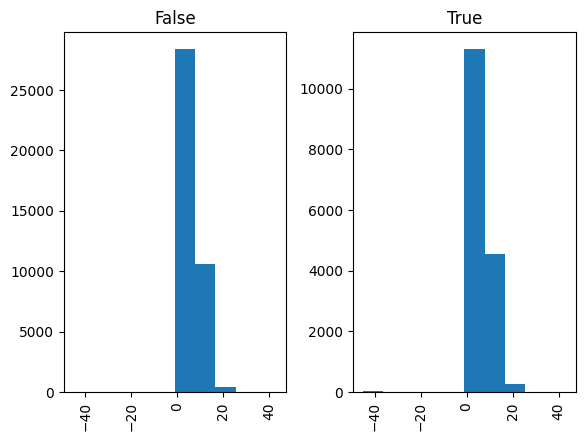

In [120]:
data_analysis.hist(column='KR_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         9.806726
std          3.905844
min          0.000000
25%          8.000000
50%          9.000000
75%         11.000000
max         44.000000
Name: KR_WAIT_DEPARTUE_TIME, dtype: float64



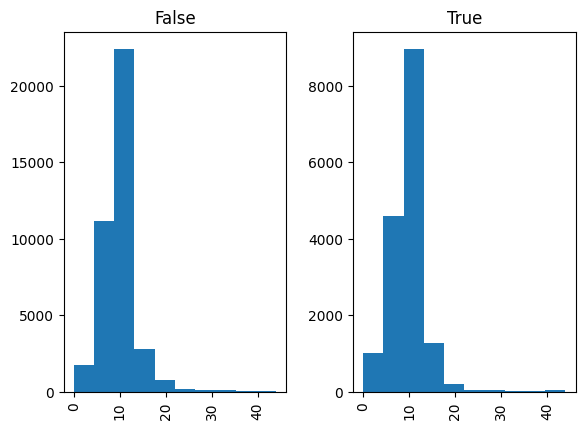

In [121]:
data_analysis.hist(column='KR_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_WAIT_DEPARTUE_TIME'].describe(include='all')))

#####BOF


Formatação das variaveis: 
count    55631.000000
mean        22.384534
std          4.995148
min          0.000000
25%         20.000000
50%         22.000000
75%         24.000000
max         54.000000
Name: BOF_BLW_TIME, dtype: float64



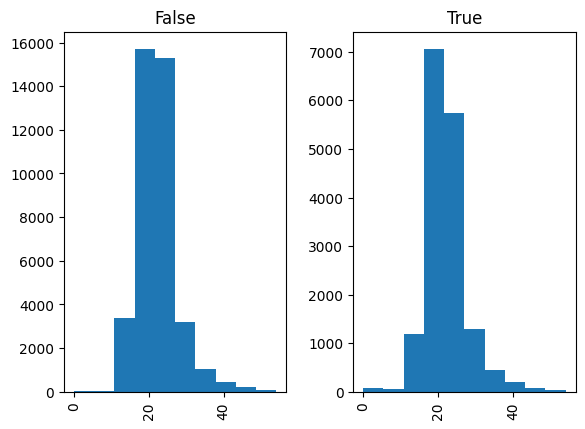

In [122]:
data_analysis.hist(column='BOF_BLW_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BOF_BLW_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         6.489889
std          1.931508
min          0.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         21.000000
Name: BOF_TAP_TIME, dtype: float64



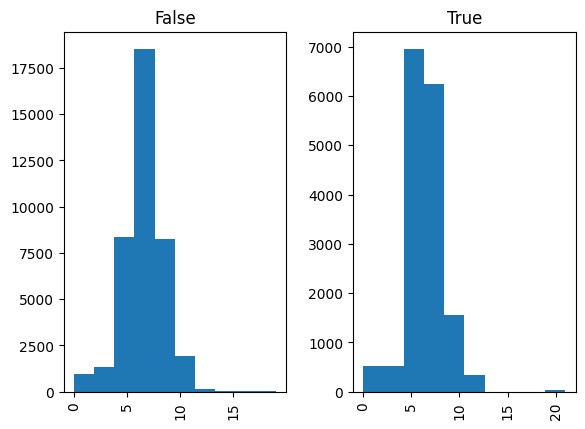

In [123]:
data_analysis.hist(column='BOF_TAP_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BOF_TAP_TIME'].describe(include='all')))

#####BAP


Formatação das variaveis: 
count    55631.000000
mean         4.018191
std          3.989960
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         55.000000
Name: BAP_TOTAL_TIME, dtype: float64



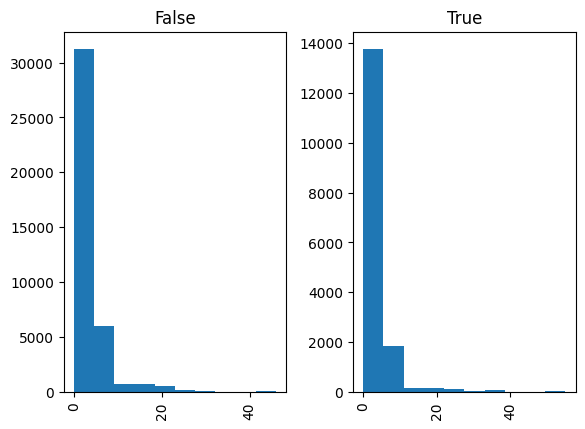

In [124]:
data_analysis.hist(column='BAP_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.290054
std          2.484160
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: BAP_PROCESS_TIME, dtype: float64



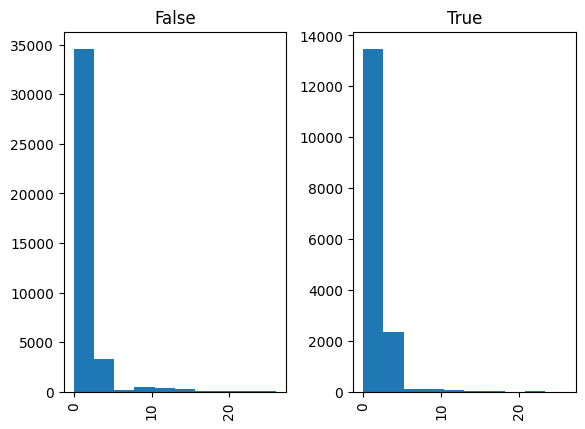

In [125]:
data_analysis.hist(column='BAP_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.110909
std          0.775892
min         -6.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: BAP_WAIT_START_TIME, dtype: float64



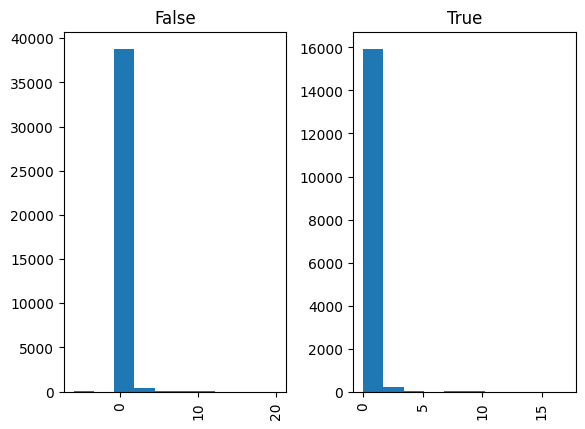

In [126]:
data_analysis.hist(column='BAP_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.277795
std          2.711236
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: BAP_WAIT_DEPARTUE_TIME, dtype: float64



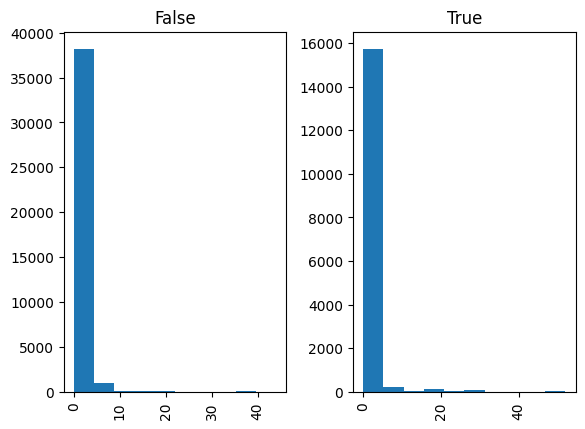

In [127]:
data_analysis.hist(column='BAP_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_WAIT_DEPARTUE_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.643177
std          2.577600
min          0.000000
25%          0.000000
50%          1.200000
75%          2.000000
max         26.100000
Name: BAP_RSLT_TIME, dtype: float64



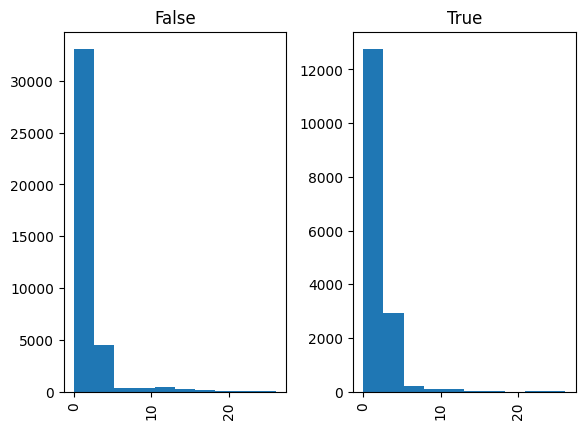

In [128]:
data_analysis.hist(column='BAP_RSLT_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_RSLT_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.946249
std          1.439946
min          0.000000
25%          0.000000
50%          0.000000
75%          1.800000
max         15.100000
Name: BAP_TOP_BB_TOT_DUR, dtype: float64



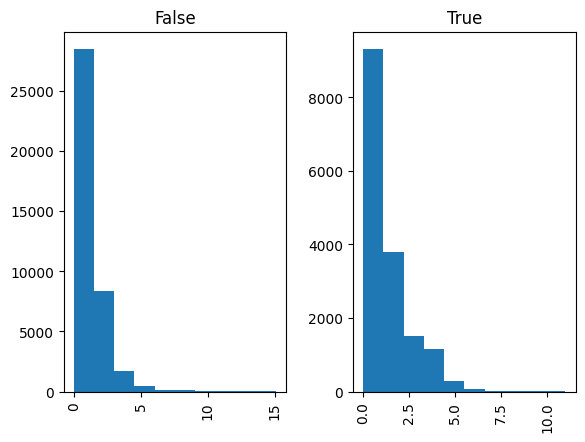

In [129]:
data_analysis.hist(column='BAP_TOP_BB_TOT_DUR', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_TOP_BB_TOT_DUR'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.758365
std          1.336745
min          0.000000
25%          0.000000
50%          0.000000
75%          1.100000
max         21.300000
Name: BAP_BTM_BB_TOT_DUR, dtype: float64



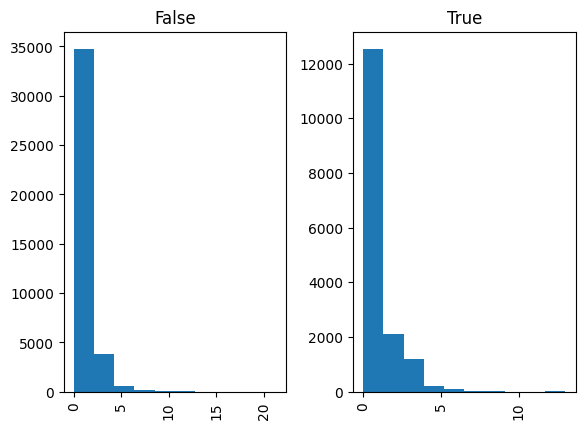

In [130]:
data_analysis.hist(column='BAP_BTM_BB_TOT_DUR', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_BTM_BB_TOT_DUR'].describe(include='all')))

#####RH


Formatação das variaveis: 
count    55631.000000
mean        17.977495
std         10.200353
min          0.000000
25%         15.000000
50%         18.000000
75%         23.000000
max         59.000000
Name: RH_TOTAL_TIME, dtype: float64



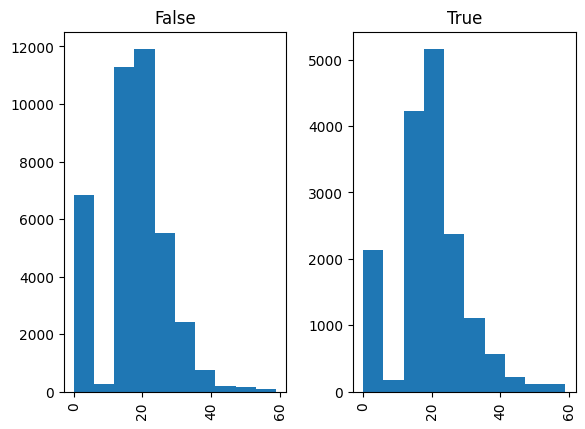

In [131]:
data_analysis.hist(column='RH_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        12.277489
std          8.585736
min          0.000000
25%          8.000000
50%         11.000000
75%         16.000000
max         55.000000
Name: RH_PROCESS_TIME, dtype: float64



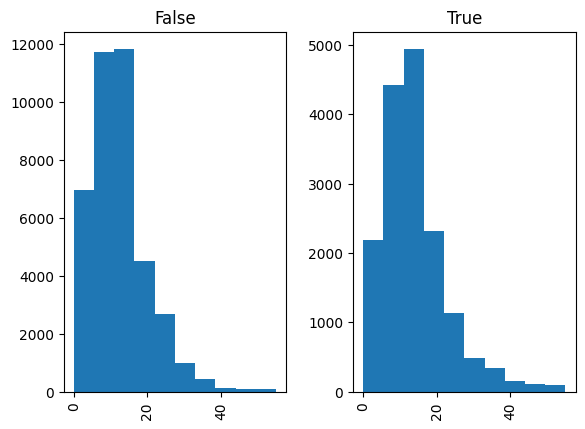

In [132]:
data_analysis.hist(column='RH_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.280311
std          1.115260
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: RH_WAIT_START_TIME, dtype: float64



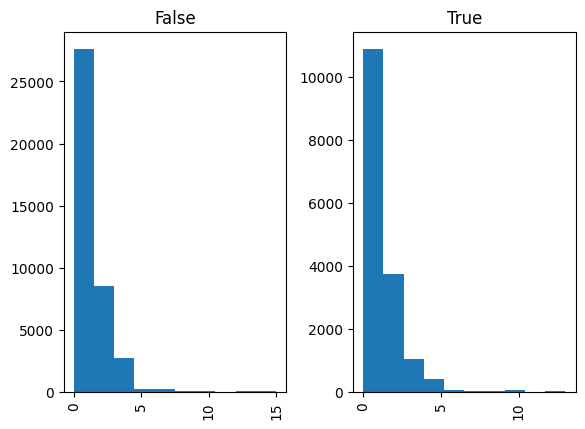

In [133]:
data_analysis.hist(column='RH_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         3.673276
std          2.808782
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         41.000000
Name: RH_WAIT_DEPARTUE_TIME, dtype: float64



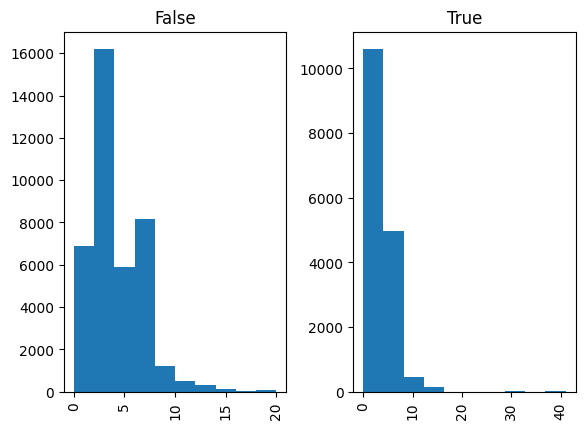

In [134]:
data_analysis.hist(column='RH_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_WAIT_DEPARTUE_TIME'].describe(include='all')))

#####LF


Formatação das variaveis: 
count    55631.000000
mean        11.268340
std         14.970506
min          0.000000
25%          0.000000
50%          0.000000
75%         24.000000
max         59.000000
Name: LF_TOTAL_TIME, dtype: float64



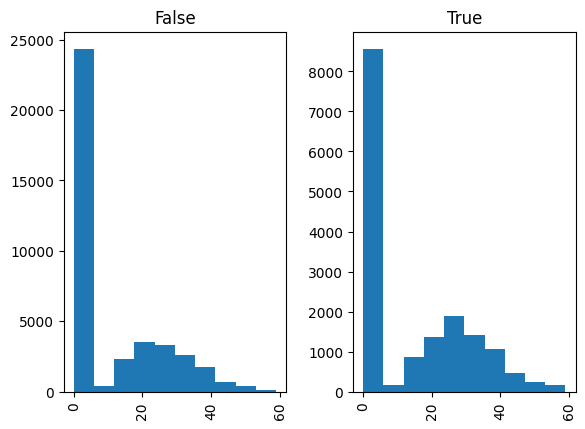

In [135]:
data_analysis.hist(column='LF_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        10.393468
std         14.034236
min          0.000000
25%          0.000000
50%          0.000000
75%         21.000000
max         59.000000
Name: LF_PROCESS_TIME, dtype: float64



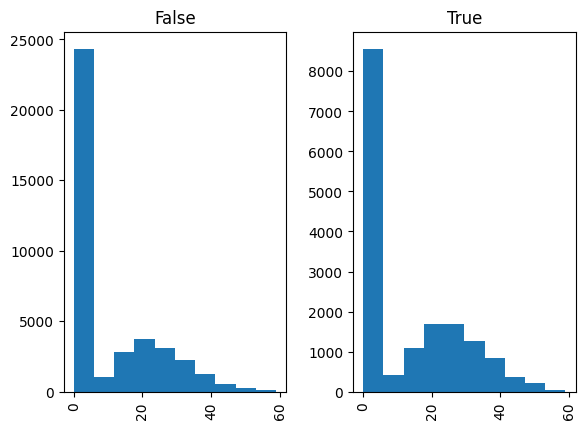

In [136]:
data_analysis.hist(column='LF_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.060632
std          0.881272
min        -35.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         23.000000
Name: LF_WAIT_START_TIME, dtype: float64



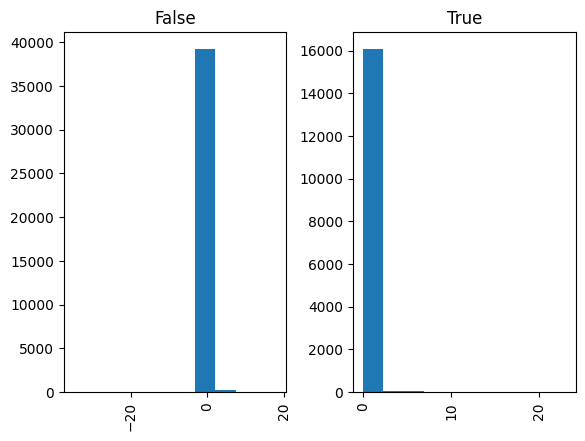

In [137]:
data_analysis.hist(column='LF_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.696213
std          1.827497
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         49.000000
Name: LF_WAIT_DEPARTUE_TIME, dtype: float64



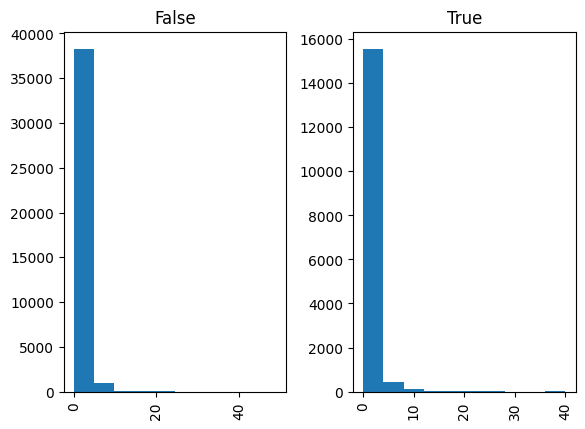

In [138]:
data_analysis.hist(column='LF_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_WAIT_DEPARTUE_TIME'].describe(include='all')))

#####CC


Formatação das variaveis: 
count    55631.000000
mean        19.512646
std         20.109376
min        -22.000000
25%          4.000000
50%         11.000000
75%         27.000000
max         59.000000
Name: CC_TOTAL_TIME, dtype: float64



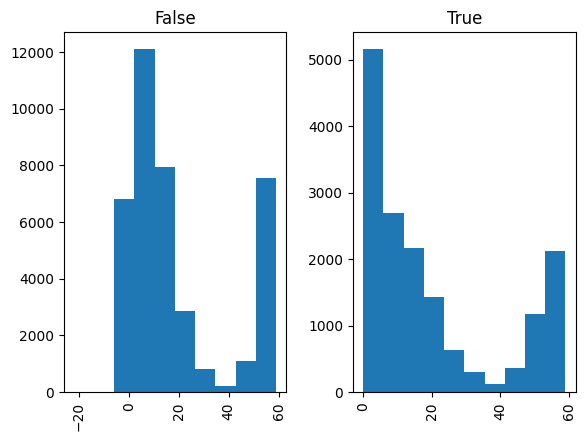

In [139]:
data_analysis.hist(column='CC_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        44.609390
std         11.510459
min          0.000000
25%         42.000000
50%         46.000000
75%         51.000000
max         59.000000
Name: CC_PROCESS_TIME, dtype: float64



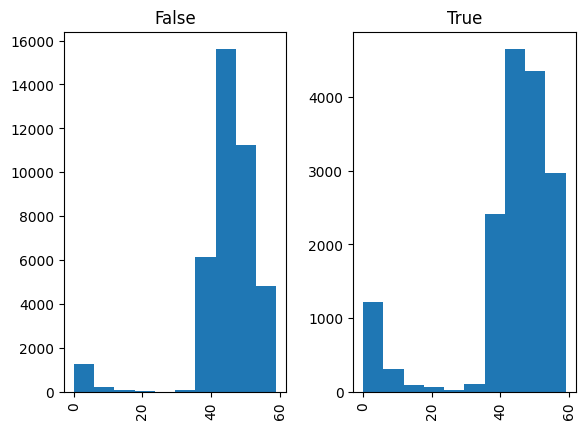

In [140]:
data_analysis.hist(column='CC_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        22.562798
std          8.387585
min          3.000000
25%         16.000000
50%         23.000000
75%         29.000000
max         56.000000
Name: CC_WAIT_START_TIME, dtype: float64



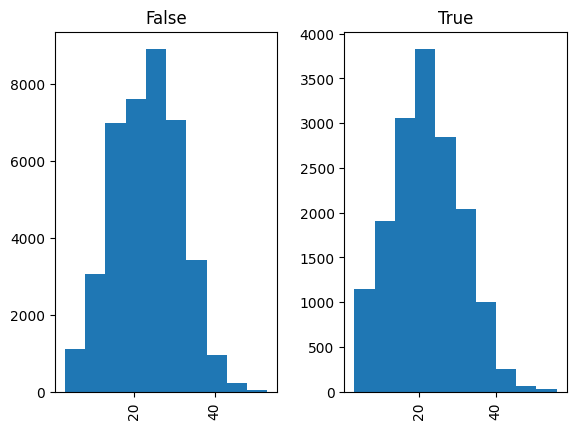

In [141]:
data_analysis.hist(column='CC_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        -3.694073
std          5.132090
min        -54.000000
25%         -4.000000
50%         -3.000000
75%         -2.000000
max         40.000000
Name: CC_WAIT_DEPARTUE_TIME, dtype: float64



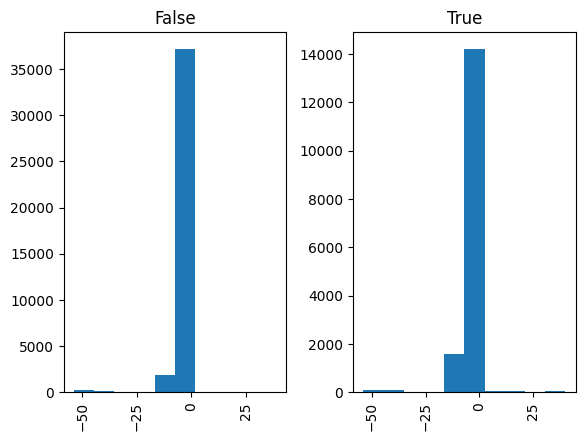

In [142]:
data_analysis.hist(column='CC_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_WAIT_DEPARTUE_TIME'].describe(include='all')))

####ANALISE DE ROTAS

In [143]:
print("Ocorrencia do evento sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do evento sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True].sum())*100))

print(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['DESVIO_RH'].describe(include='all')))

Ocorrencia do evento sob defeitos: 30.308%
Não Ocorrencia do evento sob defeitos: 69.692%

Ocorrencia do eventos sob o total: 4.316%

Defeitos  DESVIO_RH
False     False        33922
          True          5521
True      False        13787
          True          2401
Name: DESVIO_RH, dtype: int64

Formatação das variaveis: 
count     55631
unique        2
top       False
freq      47709
Name: DESVIO_RH, dtype: object



In [144]:
print("Ocorrencia do evento sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do evento sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True].sum())*100))

print(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['DESVIO_LF'].describe(include='all')))

Ocorrencia do evento sob defeitos: 30.056%
Não Ocorrencia do evento sob defeitos: 69.944%

Ocorrencia do eventos sob o total: 7.863%

Defeitos  DESVIO_LF
False     False        29264
          True         10179
True      False        11814
          True          4374
Name: DESVIO_LF, dtype: int64

Formatação das variaveis: 
count     55631
unique        2
top       False
freq      41078
Name: DESVIO_LF, dtype: object



In [145]:
print("Ocorrencia do eventos sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do eventos sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True].sum())*100))
print(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['ACT_DOUBLE_EQUIP_ROUTE_RH'].describe(include='all')))


Ocorrencia do eventos sob defeitos: 26.531%
Não Ocorrencia do eventos sob defeitos: 73.469%

Ocorrencia do eventos sob o total: 0.047%

Defeitos  ACT_DOUBLE_EQUIP_ROUTE_RH
False     False                        39371
          True                            72
True      False                        16162
          True                            26
Name: ACT_DOUBLE_EQUIP_ROUTE_RH, dtype: int64

Formatação das variaveis: 
count     55631
unique        2
top       False
freq      55533
Name: ACT_DOUBLE_EQUIP_ROUTE_RH, dtype: object



In [146]:
print("Ocorrencia do eventos sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do eventos sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True].sum())*100))
print(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['ACT_DOUBLE_EQUIP_ROUTE_LF'].describe(include='all')))

Ocorrencia do eventos sob defeitos: 43.680%
Não Ocorrencia do eventos sob defeitos: 56.320%

Ocorrencia do eventos sob o total: 0.491%

Defeitos  ACT_DOUBLE_EQUIP_ROUTE_LF
False     False                        39091
          True                           352
True      False                        15915
          True                           273
Name: ACT_DOUBLE_EQUIP_ROUTE_LF, dtype: int64

Formatação das variaveis: 
count     55631
unique        2
top       False
freq      55006
Name: ACT_DOUBLE_EQUIP_ROUTE_LF, dtype: object



In [147]:

print("Ocorrencia do eventos sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do eventos sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True].sum())*100))

print(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['DESVIO_ROTA'].describe(include='all')))

Ocorrencia do eventos sob defeitos: 30.534%
Não Ocorrencia do eventos sob defeitos: 69.466%

Ocorrencia do eventos sob o total: 11.884%

Defeitos  DESVIO_ROTA
False     False          24403
          True           15040
True      False           9577
          True            6611
Name: DESVIO_ROTA, dtype: int64

Formatação das variaveis: 
count     55631
unique        2
top       False
freq      33980
Name: DESVIO_ROTA, dtype: object



####ANALISE DE PLANEJAMENTO


Formatação das variaveis: 
count    55631.000000
mean         0.548840
std          0.287643
min          0.020000
25%          0.300000
50%          0.560000
75%          0.800000
max          1.000000
Name: HEAT_SEQ_POSITION, dtype: float64



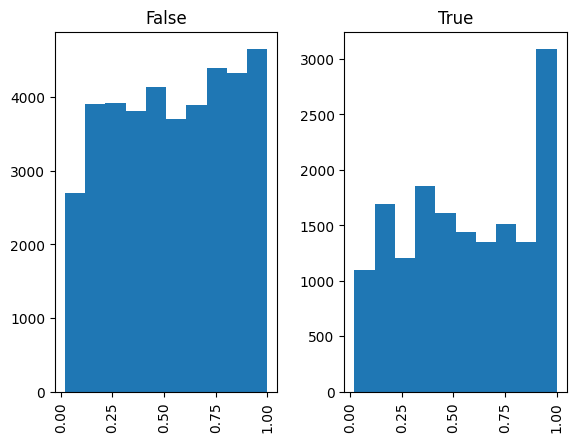

In [148]:
data_analysis.hist(column='HEAT_SEQ_POSITION', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['HEAT_SEQ_POSITION'].describe(include='all')))


Formatação das variaveis: 
count    55631.00000
mean         7.68647
std          1.76806
min          0.00000
25%          7.00000
50%          8.00000
75%          8.00000
max         11.00000
Name: cod_posit_cut, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

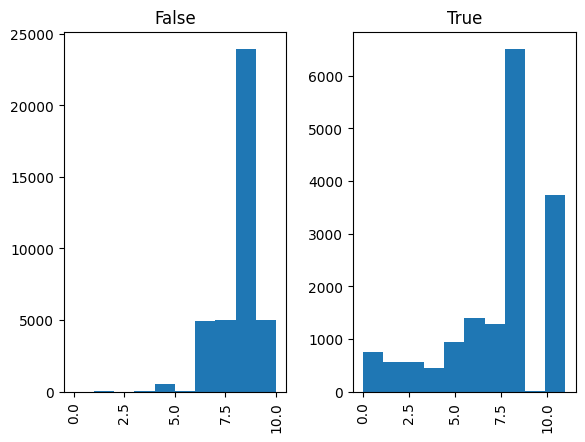

In [149]:
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['cod_posit_cut'].describe(include='all')))
data_analysis.hist(column='cod_posit_cut', by='Defeitos')

####ANALISE DE RESULTADOS

Formatação das variaveis: 
count    55631.000000
mean       345.040396
std          5.092337
min        286.300000
25%        342.000000
50%        345.820000
75%        348.600000
max        378.800000
Name: HEAT_ACT_WGT, dtype: float64



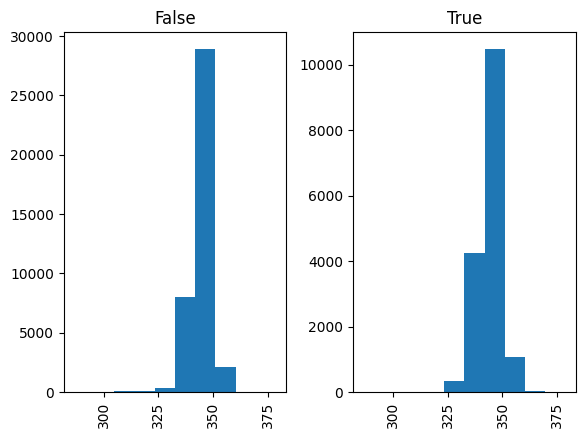

In [150]:
data_analysis.hist(column='HEAT_ACT_WGT', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['HEAT_ACT_WGT'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         3.853032
std          1.064202
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          7.000000
Name: cod_bap_process, dtype: float64



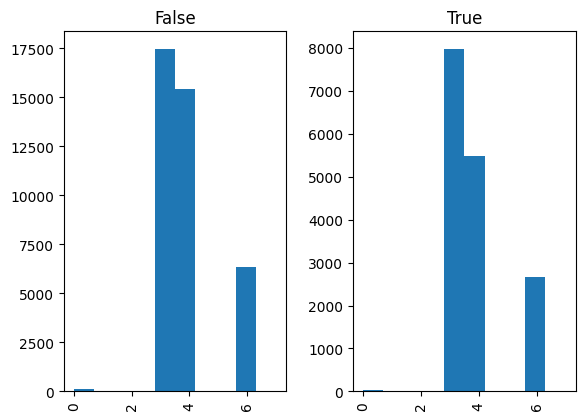

In [151]:
data_analysis.hist(column='cod_bap_process', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['cod_bap_process'].describe(include='all')))

Formatação das variaveis: 
count    53097.000000
mean         1.223045
std         15.753987
min        -63.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        206.000000
Name: TAPER_REDUCAO, dtype: float64



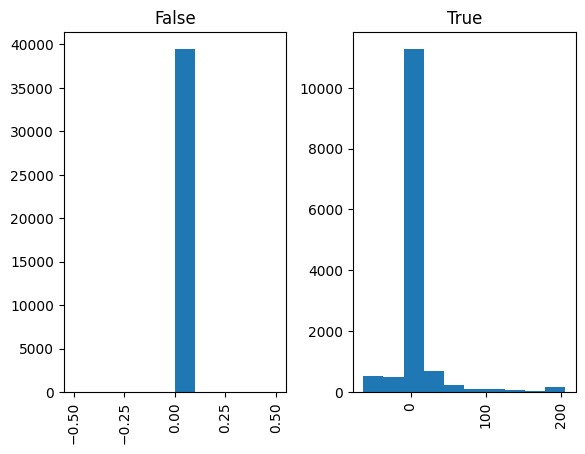

In [152]:
data_analysis.hist(column='TAPER_REDUCAO', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TAPER_REDUCAO'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean         0.148802
std          0.466652
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: cod_taper, dtype: float64



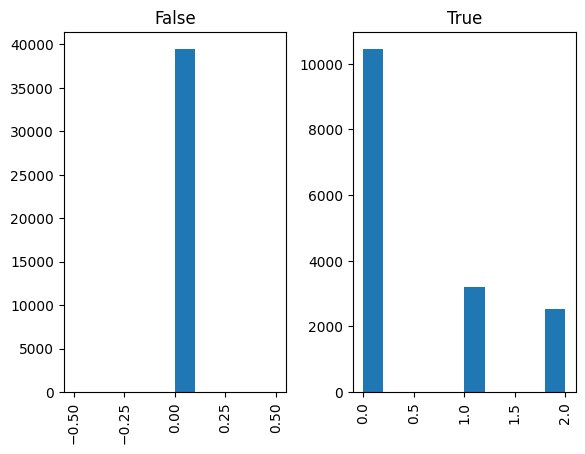

In [153]:
data_analysis.hist(column='cod_taper', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['cod_taper'].describe(include='all')))

Formatação das variaveis: 
count    53030.000000
mean        25.168037
std          5.018406
min          2.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         60.000000
Name: TD_STEEL_SUPERH_DGR, dtype: float64



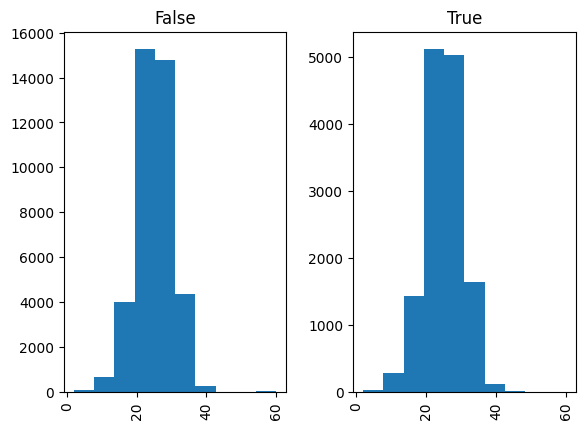

In [154]:
data_analysis.hist(column='TD_STEEL_SUPERH_DGR', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_STEEL_SUPERH_DGR'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean      1548.366434
std         36.745947
min          0.000000
25%       1544.000000
50%       1549.000000
75%       1555.000000
max       1618.000000
Name: TD_AVG_TEMP, dtype: float64



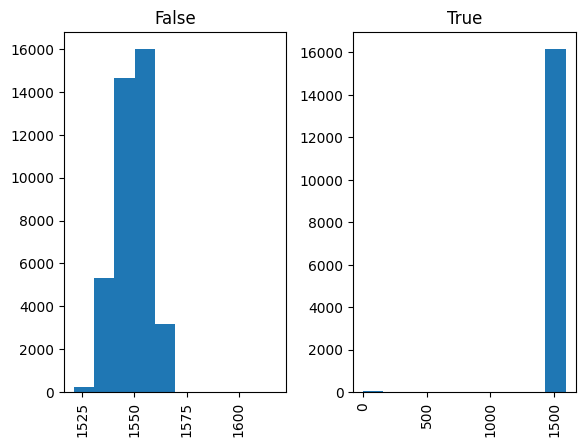

In [155]:
data_analysis.hist(column='TD_AVG_TEMP', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_AVG_TEMP'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean        61.454688
std          9.572418
min          0.000000
25%         61.454688
50%         65.000000
75%         66.000000
max         73.000000
Name: TD_STEEL_WGT, dtype: float64



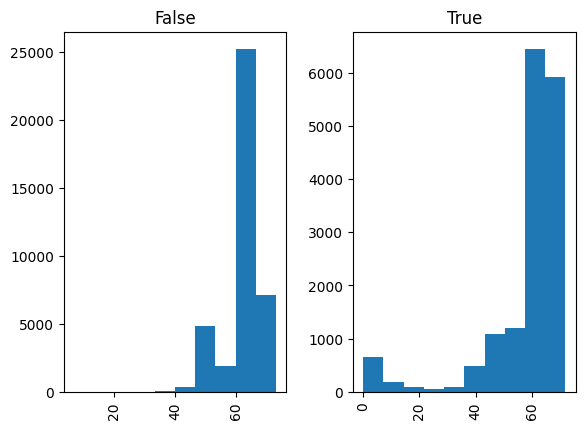

In [156]:
data_analysis.hist(column='TD_STEEL_WGT', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_STEEL_WGT'].describe(include='all')))

Formatação das variaveis: 
count    55631.000000
mean         1.367664
std          0.333251
min          0.010000
25%          1.250000
50%          1.400000
75%          1.600000
max          1.800000
Name: CAST_MIN_SPD, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

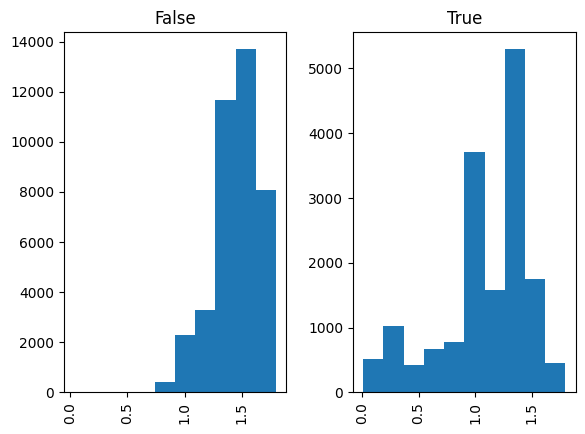

In [157]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_MIN_SPD'].describe(include='all')))
data_analysis.hist(column='CAST_MIN_SPD', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         1.482648
std          0.214098
min          0.760000
25%          1.400000
50%          1.500000
75%          1.600000
max          1.850000
Name: CAST_MAX_SPD, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

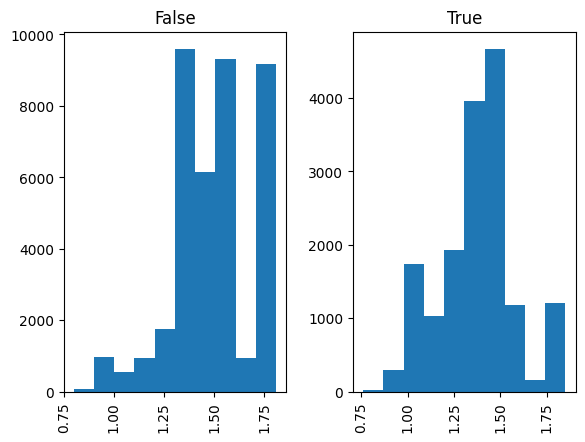

In [158]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_MAX_SPD'].describe(include='all')))
data_analysis.hist(column='CAST_MAX_SPD', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         1.427671
std          0.248585
min          0.440000
25%          1.320000
50%          1.427671
75%          1.600000
max          1.800000
Name: CAST_AVG_SPD, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

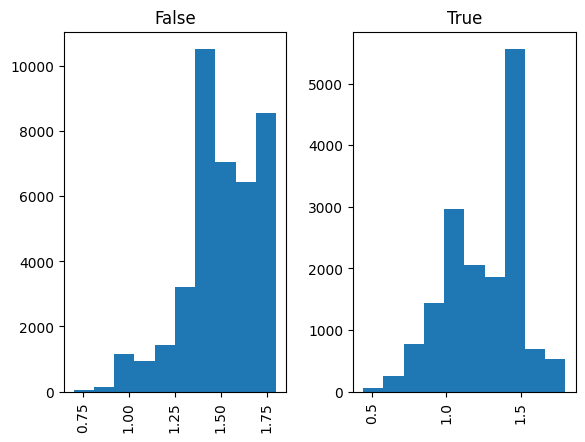

In [159]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_AVG_SPD'].describe(include='all')))
data_analysis.hist(column='CAST_AVG_SPD', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         7.754108
std          0.944817
min          2.800000
25%          7.400000
50%          7.754108
75%          8.400000
max          9.200000
Name: MLD_OSCILL_GAP, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

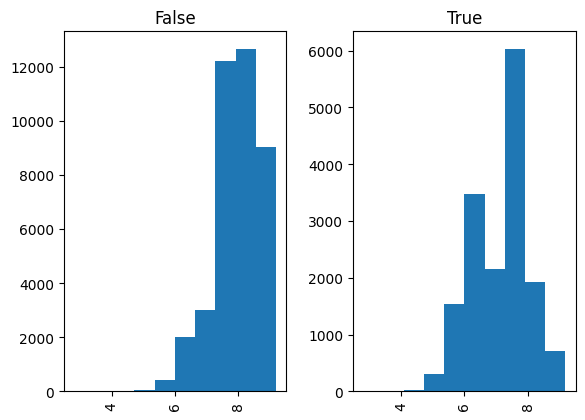

In [160]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_OSCILL_GAP'].describe(include='all')))
data_analysis.hist(column='MLD_OSCILL_GAP', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         0.202574
std          0.881682
min          0.000000
25%          0.000000
50%          0.000000
75%          0.240000
max         10.860000
Name: CAST_IN_CAST_SPD_CHG_VAL, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

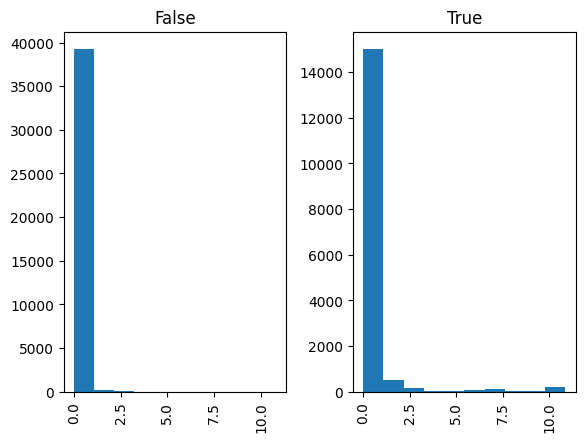

In [161]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_IN_CAST_SPD_CHG_VAL'].describe(include='all')))
data_analysis.hist(column='CAST_IN_CAST_SPD_CHG_VAL', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         0.463662
std          0.608353
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: BAP_TOP_BB_TOT_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

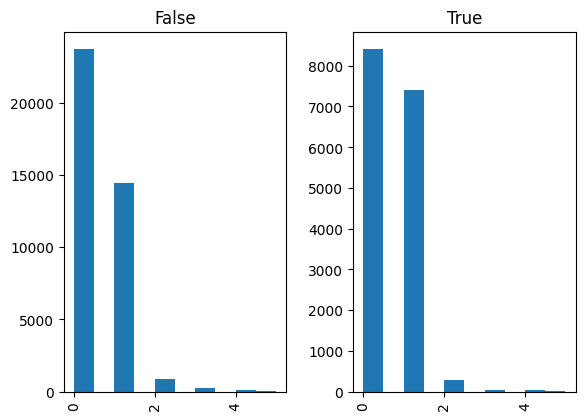

In [162]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_TOP_BB_TOT_CNT'].describe(include='all')))
data_analysis.hist(column='BAP_TOP_BB_TOT_CNT', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         0.457407
std          0.560630
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: BAP_BTM_BB_TOT_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

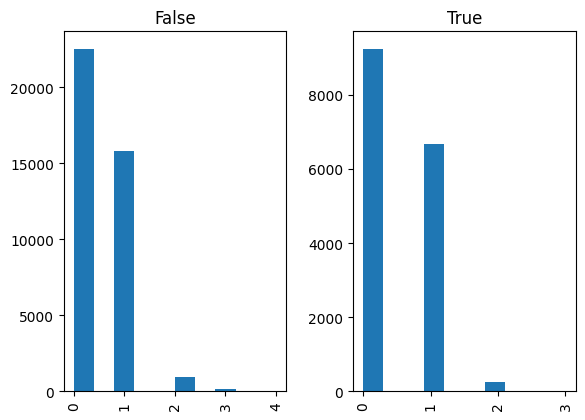

In [163]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_BTM_BB_TOT_CNT'].describe(include='all')))
data_analysis.hist(column='BAP_BTM_BB_TOT_CNT', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean      1525.082760
std        717.728696
min          0.000000
25%       1604.000000
50%       1617.000000
75%       1628.000000
max       9999.000000
Name: BAP_TEMPERATURA_SAIDA, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

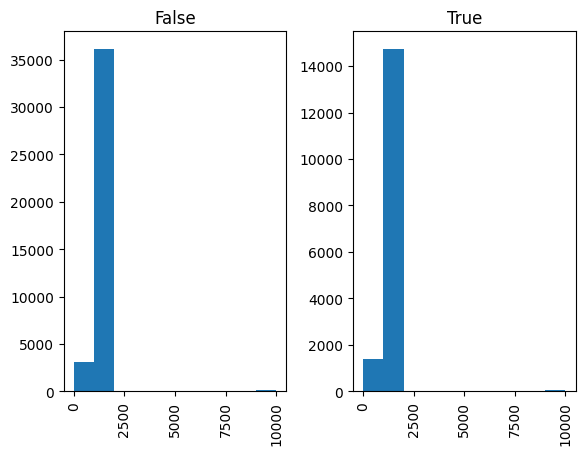

In [164]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_TEMPERATURA_SAIDA'].describe(include='all')))
data_analysis.hist(column='BAP_TEMPERATURA_SAIDA', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         0.996531
std          0.058799
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: BAP_PI_USED_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

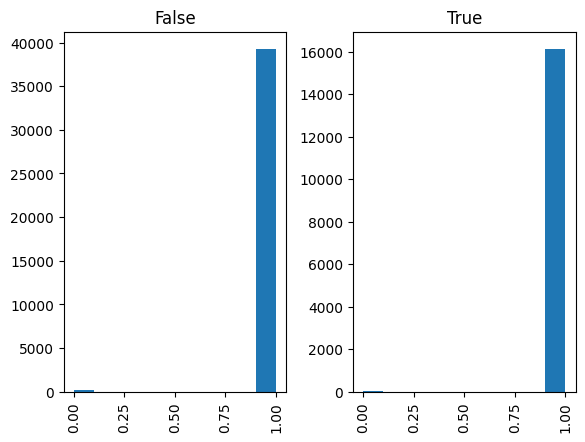

In [165]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_PI_USED_CNT'].describe(include='all')))
data_analysis.hist(column='BAP_PI_USED_CNT', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         3.607126
std          4.161596
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         53.000000
Name: BAP_VOLUME_ARGONIO, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

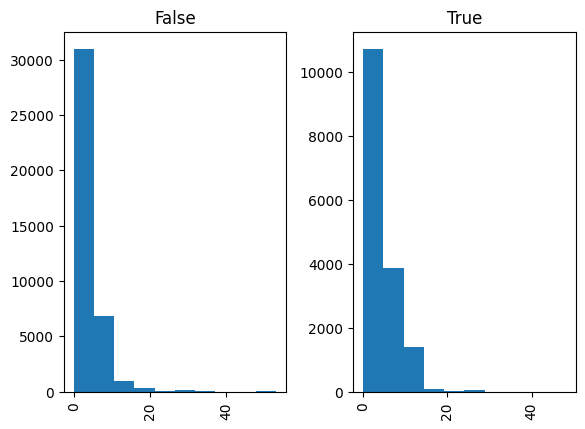

In [166]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_VOLUME_ARGONIO'].describe(include='all')))
data_analysis.hist(column='BAP_VOLUME_ARGONIO', by='Defeitos')

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: BAP_VOLUME_N2, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

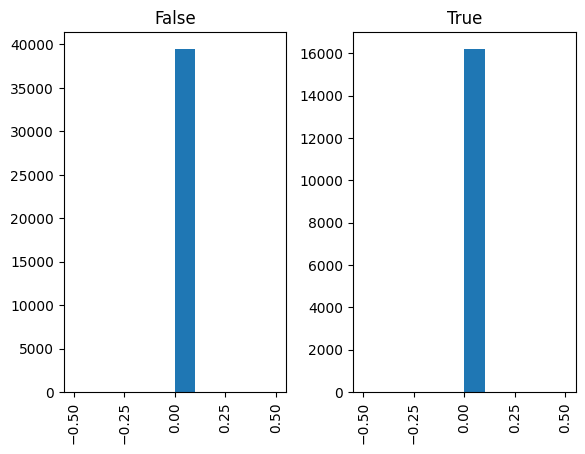

In [167]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_VOLUME_N2'].describe(include='all')))
data_analysis.hist(column='BAP_VOLUME_N2', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean       115.580385
std         85.647113
min          0.000000
25%         34.400000
50%        115.580385
75%        186.000000
max        344.200000
Name: CAST_IN_LD_STEEL_WGT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

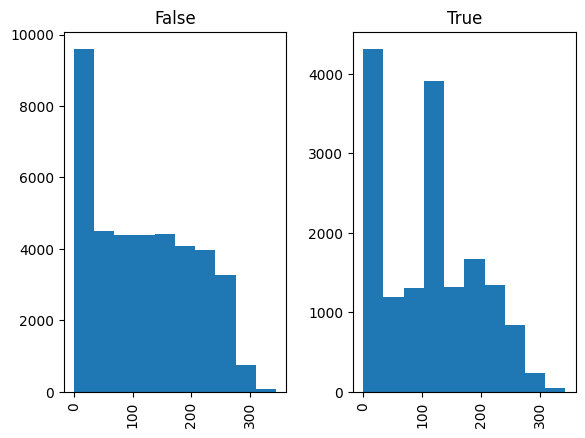

In [168]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_IN_LD_STEEL_WGT'].describe(include='all')))
data_analysis.hist(column='CAST_IN_LD_STEEL_WGT', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         1.736979
std          8.129450
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.000000
Name: MLD_TAPR_RGT_CHG_VAL, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

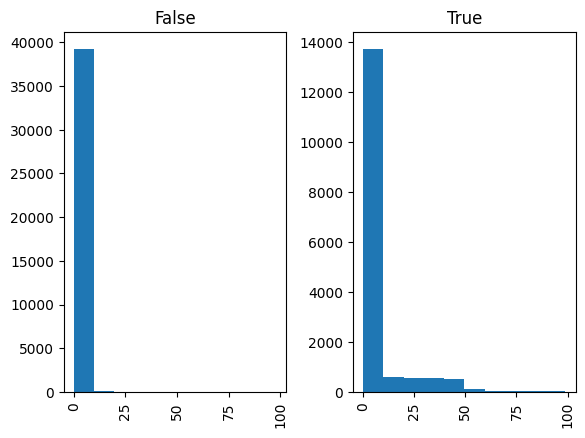

In [169]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_TAPR_RGT_CHG_VAL'].describe(include='all')))
data_analysis.hist(column='MLD_TAPR_RGT_CHG_VAL', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         1.736979
std          8.129450
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.000000
Name: MLD_TAPR_LFT_CHG_VAL, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

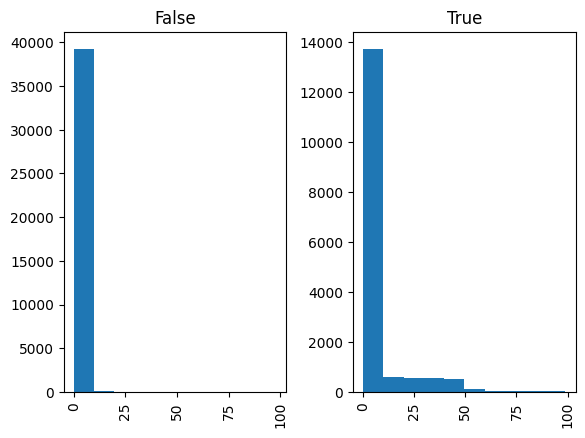

In [170]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_TAPR_LFT_CHG_VAL'].describe(include='all')))
data_analysis.hist(column='MLD_TAPR_LFT_CHG_VAL', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         1.138285
std          0.095368
min          0.000000
25%          1.090000
50%          1.138285
75%          1.190000
max          2.290000
Name: RGT_MD_TAPR_RATE, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

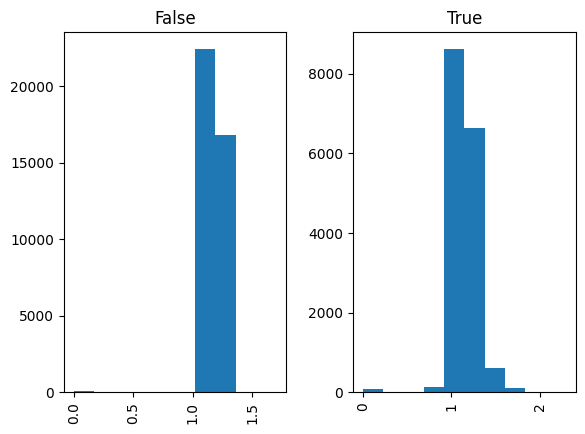

In [171]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['RGT_MD_TAPR_RATE'].describe(include='all')))
data_analysis.hist(column='RGT_MD_TAPR_RATE', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         1.137168
std          0.095193
min          0.000000
25%          1.090000
50%          1.137168
75%          1.190000
max          2.280000
Name: LFT_MD_TAPR_RATE, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

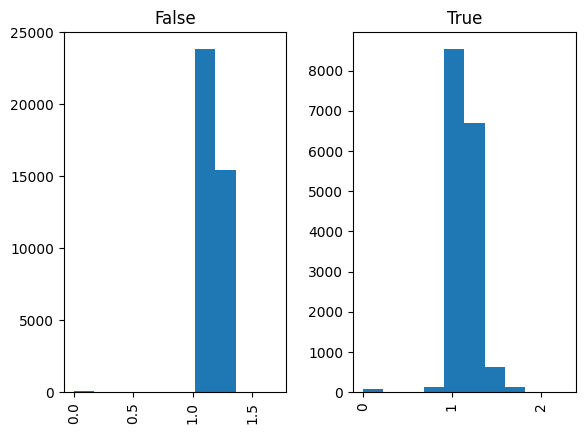

In [172]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['LFT_MD_TAPR_RATE'].describe(include='all')))
data_analysis.hist(column='LFT_MD_TAPR_RATE', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean        85.622497
std          6.799808
min          0.000000
25%         82.000000
50%         86.000000
75%         89.000000
max        120.000000
Name: TD_SLID_NZ_MAX_OPEN, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

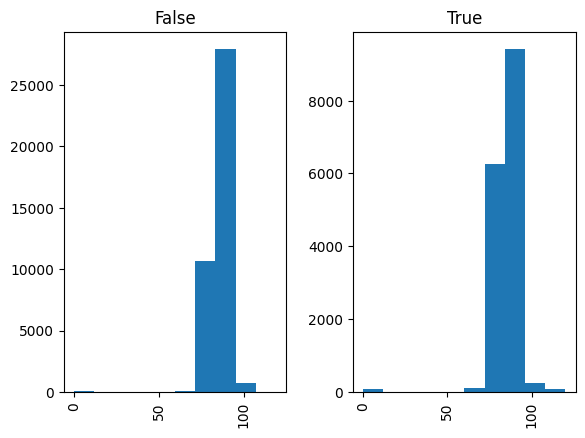

In [173]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_NZ_MAX_OPEN'].describe(include='all')))
data_analysis.hist(column='TD_SLID_NZ_MAX_OPEN', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean        81.575335
std          9.893556
min          0.000000
25%         79.000000
50%         83.000000
75%         87.000000
max        119.000000
Name: TD_SLID_NZ_MIN_OPEN, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

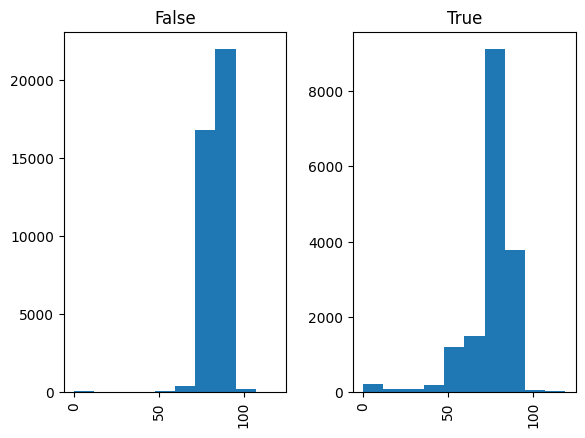

In [174]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_NZ_MIN_OPEN'].describe(include='all')))
data_analysis.hist(column='TD_SLID_NZ_MIN_OPEN', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean        83.310466
std          7.656964
min          0.000000
25%         80.000000
50%         84.000000
75%         88.000000
max        119.000000
Name: TD_SLID_GATE_OPEN_QTY, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

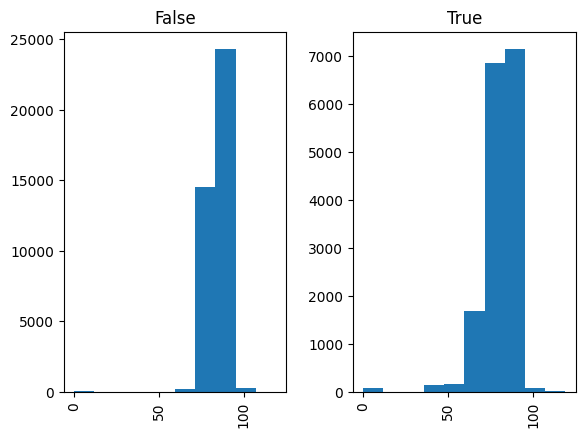

In [175]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_GATE_OPEN_QTY'].describe(include='all')))
data_analysis.hist(column='TD_SLID_GATE_OPEN_QTY', by='Defeitos')

Formatação das variaveis: 
count    55631.000000
mean         0.044251
std          0.084649
min          0.000000
25%          0.010000
50%          0.020000
75%          0.040000
max          0.990000
Name: TD_SLID_NZ_OPEN_VAR_RATE, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

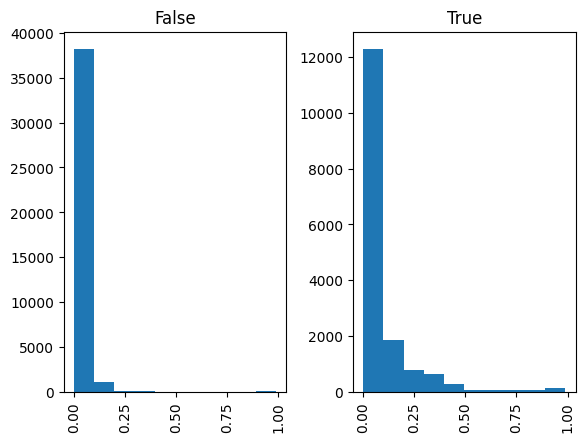

In [176]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_NZ_OPEN_VAR_RATE'].describe(include='all')))
data_analysis.hist(column='TD_SLID_NZ_OPEN_VAR_RATE', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         4.873873
std          0.835016
min          0.000000
25%          4.400000
50%          4.873873
75%          5.300000
max          8.500000
Name: MLD_WIDE_IS_CW_TEMP_DIFF, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

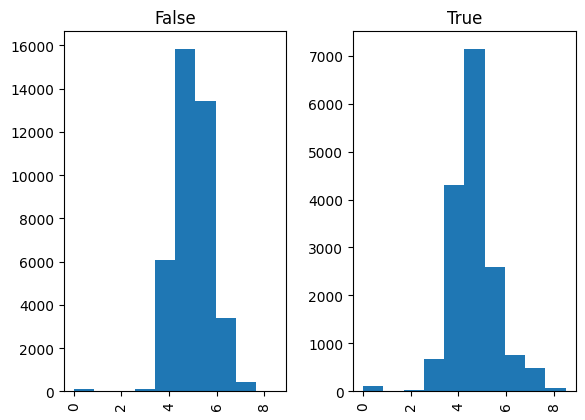

In [177]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_WIDE_IS_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_WIDE_IS_CW_TEMP_DIFF', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         7.566121
std          1.050891
min          0.000000
25%          7.100000
50%          7.566121
75%          8.100000
max         10.000000
Name: MLD_NARW_LFT_CW_TEMP_DIFF, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

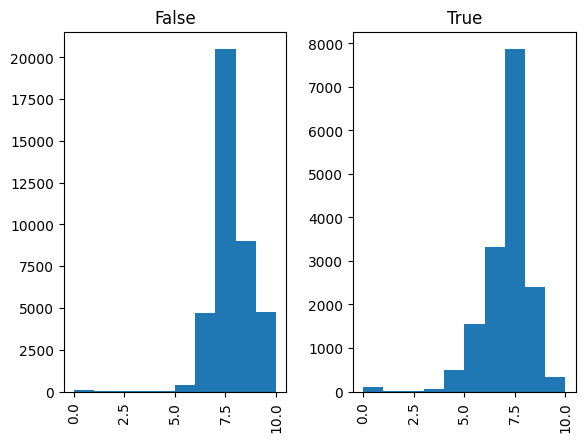

In [178]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_NARW_LFT_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_NARW_LFT_CW_TEMP_DIFF', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         4.806889
std          0.803520
min          0.000000
25%          4.300000
50%          4.800000
75%          5.200000
max          8.600000
Name: MLD_WIDE_OS_CW_TEMP_DIFF, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

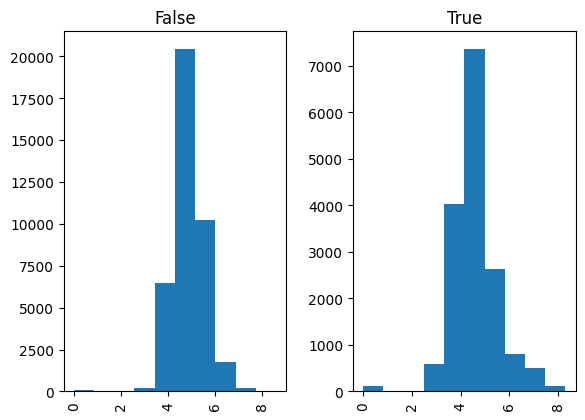

In [179]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_WIDE_OS_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_WIDE_OS_CW_TEMP_DIFF', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         7.478810
std          1.046692
min          0.000000
25%          7.000000
50%          7.478810
75%          8.000000
max         10.000000
Name: MLD_NARW_RGT_CW_TEMP_DIFF, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

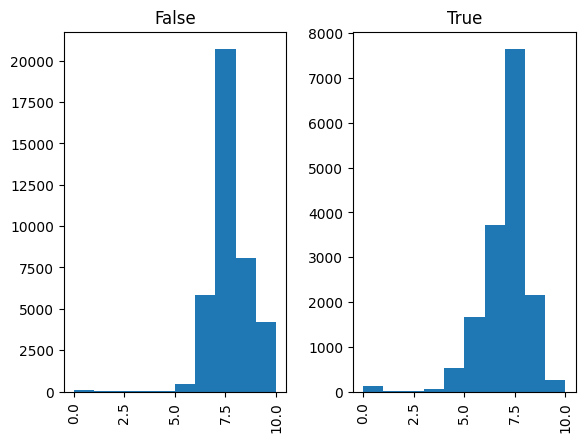

In [180]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_NARW_RGT_CW_TEMP_DIFF', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       237.454724
std         53.727040
min          0.000000
25%        205.000000
50%        225.000000
75%        262.000000
max        670.000000
Name: MLAC_SCAN_TOT_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

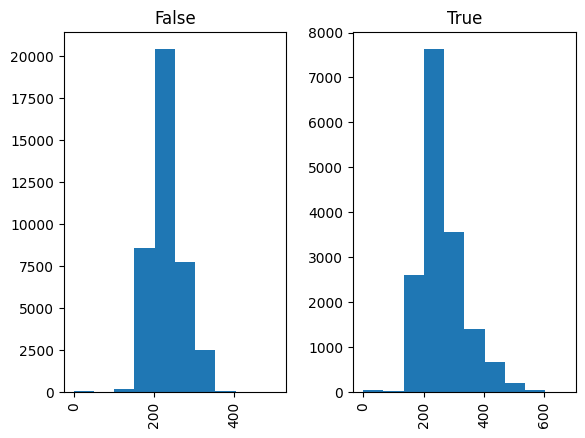

In [181]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_SCAN_TOT_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_SCAN_TOT_CNT', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         9.511390
std         70.249373
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max       1607.000000
Name: MLAC_3MM_OVER_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

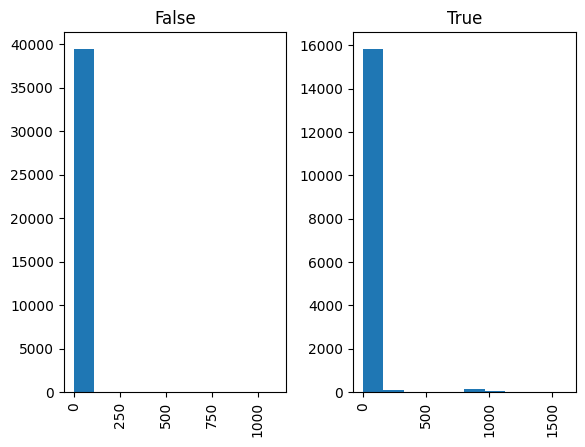

In [182]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_3MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_3MM_OVER_CNT', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         6.605110
std         69.194773
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1589.000000
Name: MLAC_5MM_OVER_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

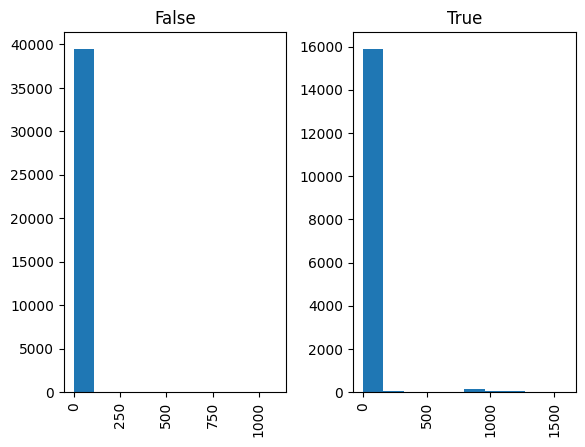

In [183]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_5MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_5MM_OVER_CNT', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         5.946955
std         68.605017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1584.000000
Name: MLAC_10MM_OVER_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

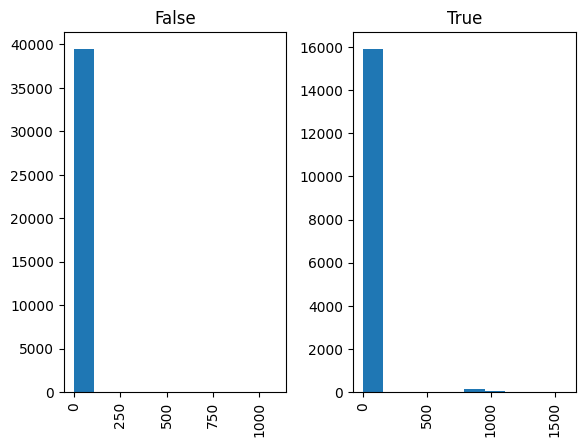

In [184]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_10MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_10MM_OVER_CNT', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         5.853215
std         68.265062
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1576.000000
Name: MLAC_20MM_OVER_CNT, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

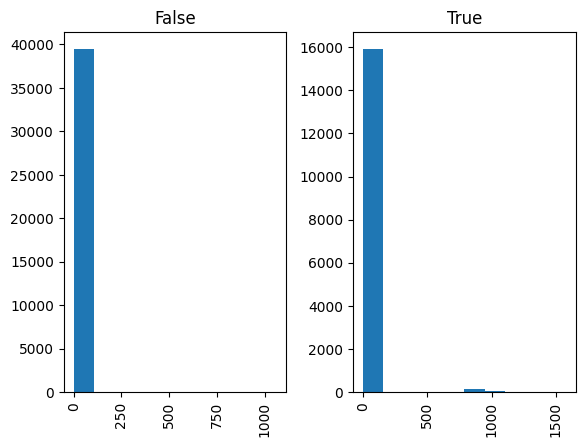

In [185]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_20MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_20MM_OVER_CNT', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       294.554271
std         50.399116
min          0.000000
25%        264.000000
50%        294.554271
75%        327.000000
max        807.000000
Name: SH_NZ_DIP_MAX_DEPTH, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

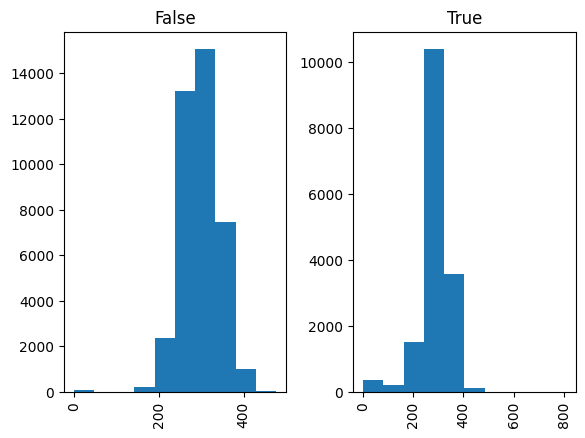

In [186]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_DIP_MAX_DEPTH'].describe(include='all')))
data_analysis.hist(column='SH_NZ_DIP_MAX_DEPTH', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       234.066887
std         99.051387
min          0.000000
25%        216.000000
50%        258.000000
75%        303.000000
max        460.000000
Name: SH_NZ_DIP_MIN_DEPTH, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

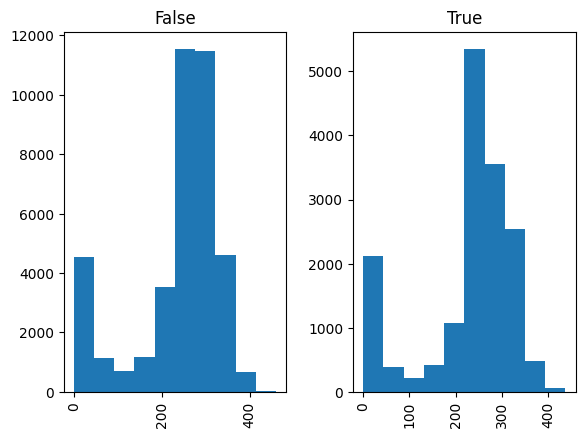

In [187]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_DIP_MIN_DEPTH'].describe(include='all')))
data_analysis.hist(column='SH_NZ_DIP_MIN_DEPTH', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       274.570092
std         56.425781
min          0.000000
25%        247.000000
50%        275.000000
75%        313.000000
max        968.000000
Name: SH_NZ_DIP_AVG_DEPTH, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

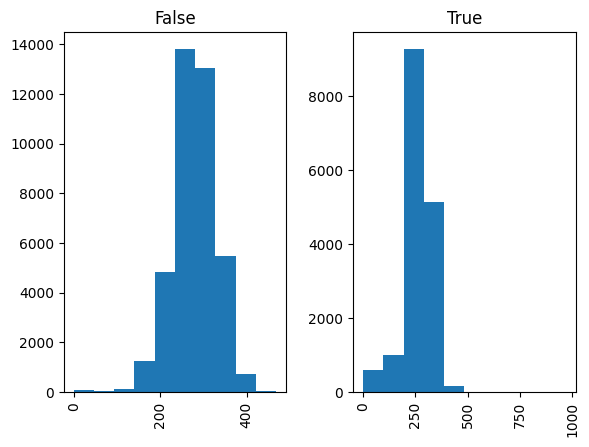

In [188]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_DIP_AVG_DEPTH'].describe(include='all')))
data_analysis.hist(column='SH_NZ_DIP_AVG_DEPTH', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       137.315557
std         29.120673
min          0.000000
25%        108.000000
50%        137.315557
75%        172.000000
max        174.000000
Name: SN_SETTLE_MIN_DEPTH, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

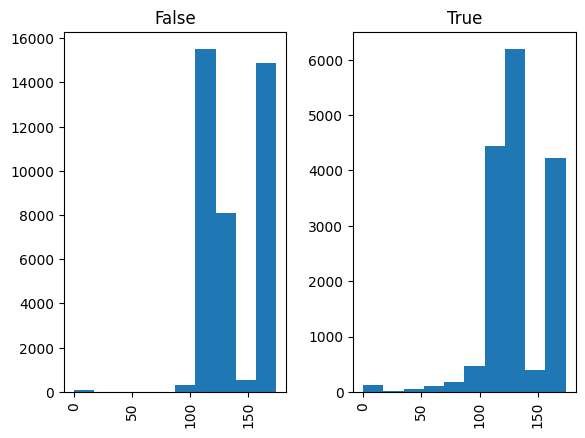

In [189]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SN_SETTLE_MIN_DEPTH'].describe(include='all')))
data_analysis.hist(column='SN_SETTLE_MIN_DEPTH', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       144.774694
std         28.537757
min          0.000000
25%        113.000000
50%        142.000000
75%        176.000000
max        201.000000
Name: SN_SETTLE_MAX_DEPTH, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

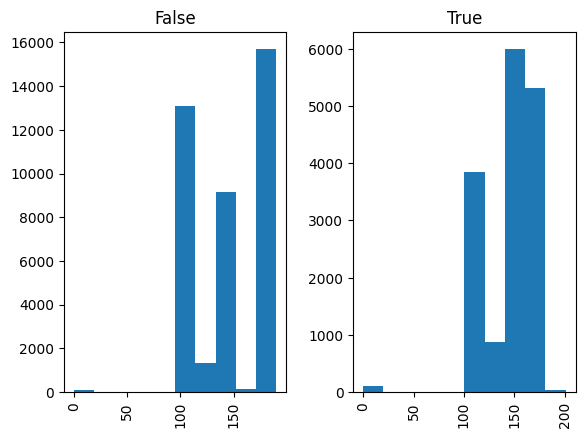

In [190]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SN_SETTLE_MAX_DEPTH'].describe(include='all')))
data_analysis.hist(column='SN_SETTLE_MAX_DEPTH', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       140.990043
std         28.351515
min          0.000000
25%        110.000000
50%        139.000000
75%        174.000000
max        175.000000
Name: SN_SETTLE_AVG_DEPTH, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

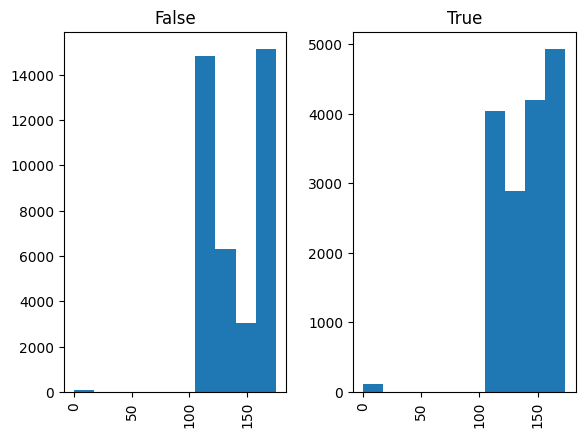

In [191]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SN_SETTLE_AVG_DEPTH'].describe(include='all')))
data_analysis.hist(column='SN_SETTLE_AVG_DEPTH', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       130.296643
std         44.124498
min          0.000000
25%        147.300000
50%        149.200000
75%        149.700000
max        150.000000
Name: SH_NZ_AR_FLW_MIN, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

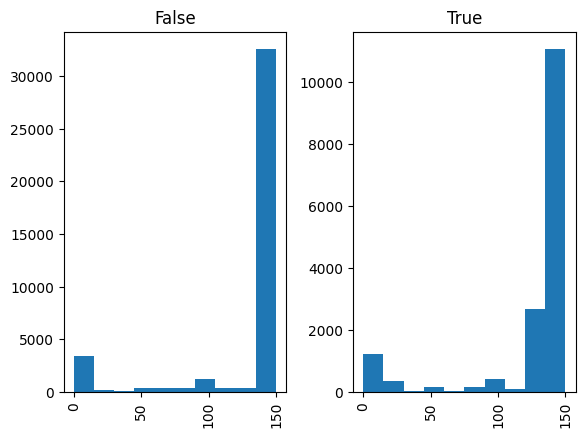

In [192]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_FLW_MIN'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_FLW_MIN', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       132.378591
std         42.642036
min          0.000000
25%        149.000000
50%        149.600000
75%        150.000000
max        150.000000
Name: SH_NZ_AR_FLW_MAX, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

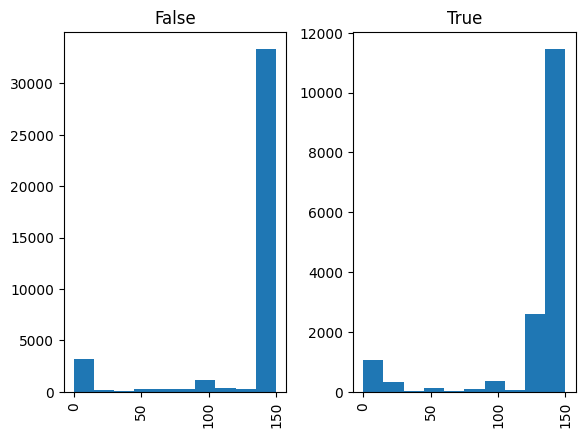

In [193]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_FLW_MAX'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_FLW_MAX', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       137.613519
std         29.161295
min          0.000000
25%        149.200000
50%        149.500000
75%        149.900000
max        150.000000
Name: SH_NZ_AR_PRS_MIN, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

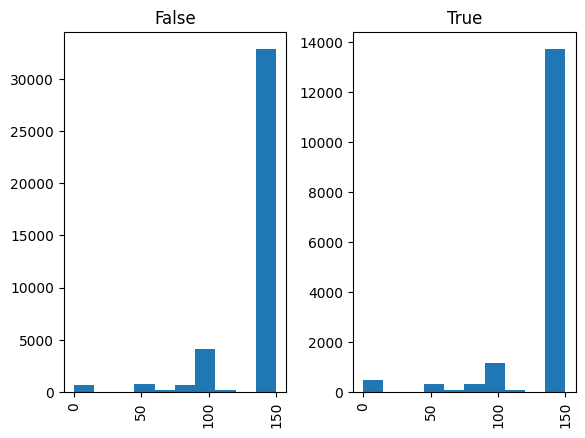

In [194]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_PRS_MIN'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_PRS_MIN', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean       138.962989
std         28.048428
min          0.000000
25%        149.400000
50%        149.800000
75%        150.000000
max        150.000000
Name: SH_NZ_AR_PRS_MAX, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

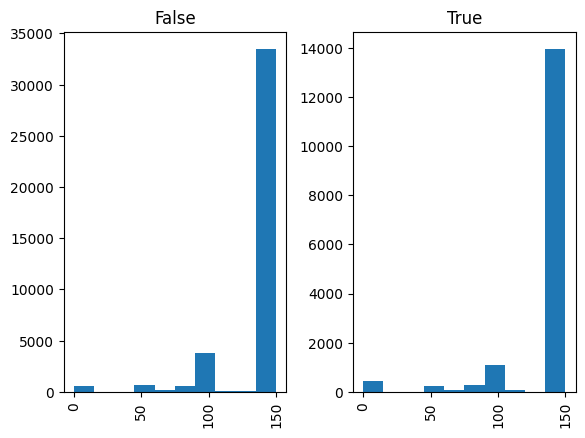

In [195]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_PRS_MAX'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_PRS_MAX', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean        19.946219
std          0.839316
min          0.000000
25%         20.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: TD_UP_NZ_AR_FLW_MAX, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

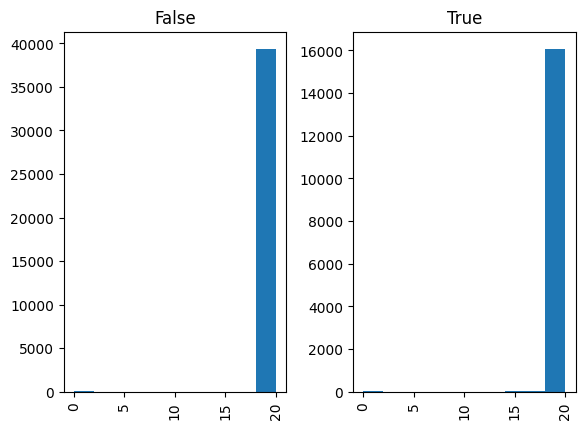

In [196]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_UP_NZ_AR_FLW_MAX'].describe(include='all')))
data_analysis.hist(column='TD_UP_NZ_AR_FLW_MAX', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean        19.692665
std          1.511506
min          0.000000
25%         20.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: TD_UP_NZ_AR_FLW_MIN, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

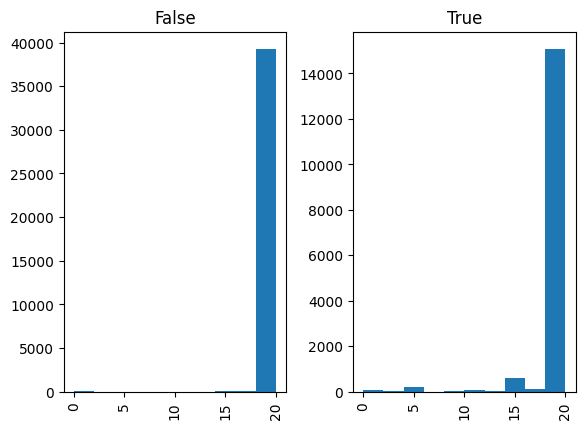

In [197]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_UP_NZ_AR_FLW_MIN'].describe(include='all')))
data_analysis.hist(column='TD_UP_NZ_AR_FLW_MIN', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean        19.908391
std          1.055727
min          0.000000
25%         20.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: TD_UP_NZ_AR_FLW_AVG, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

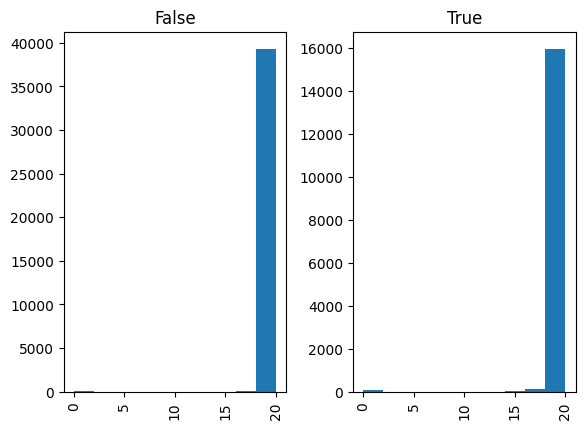

In [198]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_UP_NZ_AR_FLW_AVG'].describe(include='all')))
data_analysis.hist(column='TD_UP_NZ_AR_FLW_AVG', by='Defeitos')   

Formatação das variaveis: 
count    55631.000000
mean         7.478810
std          1.046692
min          0.000000
25%          7.000000
50%          7.478810
75%          8.000000
max         10.000000
Name: MLD_NARW_RGT_CW_TEMP_DIFF, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

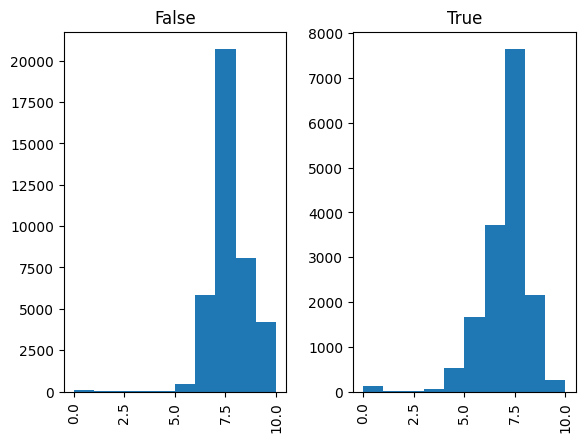

In [199]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_NARW_RGT_CW_TEMP_DIFF', by='Defeitos')   

##DADOS PARA MODELOS

In [200]:
#montando dataframe do modelo considerando as caracteristicas mais relevantes
model_data = pd.DataFrame()

model_data['Defeitos']          = data_analysis['Defeitos'].astype('bool')
model_data['chem_01']           = data_analysis['PDA1417101V07'].astype('bool')
model_data['chem_02']           = data_analysis['PDA1417101V01'].astype('bool')
model_data['chem_03']           = data_analysis['PDA1417101V36'].astype('bool')
model_data['HEAT_ACT_WGT']      = data_analysis['HEAT_ACT_WGT']
model_data['GAP_LARGURA_PLAN']  = data_analysis['GAP_LARGURA_PLAN']
model_data['GAP_LARGU_CABECA']  = data_analysis['GAP_LARGU_CABECA']
model_data['GAP_LARGU_CAUDA']   = data_analysis['GAP_LARGU_CAUDA']
model_data['BOF_NO']            = data_analysis['BOF_NO']
model_data['DESVIO_LF']         = data_analysis['DESVIO_LF']
model_data['DESVIO_ROTA']       = data_analysis['DESVIO_ROTA']
model_data['S150']              = data_analysis['S150']
model_data['S156']              = data_analysis['S156']
model_data['S162']              = data_analysis['S162']
model_data['HEAT_SEQ_POSITION'] = data_analysis['HEAT_SEQ_POSITION']
model_data['CC_WAIT_START_TIME']= data_analysis['CC_WAIT_START_TIME']
model_data['cod_posit_cut']= data_analysis['cod_posit_cut']
model_data['TAPER_REDUCAO']= data_analysis['TAPER_REDUCAO']
model_data['cod_taper']			= data_analysis['cod_taper']
model_data['TD_STEEL_WGT']		= data_analysis['TD_STEEL_WGT']
model_data['CAST_MIN_SPD']		= data_analysis['CAST_MIN_SPD']
model_data['CAST_AVG_SPD']		= data_analysis['CAST_AVG_SPD']
model_data['CAST_MAX_SPD']		= data_analysis['CAST_MAX_SPD']
model_data['MLD_OSCILL_GAP']	= data_analysis['MLD_OSCILL_GAP']
model_data['BAP_VOLUME_ARGONIO']= data_analysis['BAP_VOLUME_ARGONIO']
model_data['CAST_IN_LD_STEEL_WGT']= data_analysis['CAST_IN_LD_STEEL_WGT']
model_data['MLD_TAPR_RGT_CHG_VAL']= data_analysis['MLD_TAPR_RGT_CHG_VAL']
model_data['MLD_TAPR_LFT_CHG_VAL']= data_analysis['MLD_TAPR_LFT_CHG_VAL']
model_data['TD_SLID_NZ_MIN_OPEN']= data_analysis['TD_SLID_NZ_MIN_OPEN']
model_data['TD_SLID_GATE_OPEN_QTY']= data_analysis['TD_SLID_GATE_OPEN_QTY']
model_data['TD_SLID_NZ_OPEN_VAR_RATE']= data_analysis['TD_SLID_NZ_OPEN_VAR_RATE']
model_data['MLD_WIDE_IS_CW_TEMP_DIFF']= data_analysis['MLD_WIDE_IS_CW_TEMP_DIFF']
model_data['MLD_WIDE_OS_CW_TEMP_DIFF']= data_analysis['MLD_WIDE_OS_CW_TEMP_DIFF']
model_data['MLD_NARW_LFT_CW_TEMP_DIFF']= data_analysis['MLD_NARW_LFT_CW_TEMP_DIFF']
model_data['MLD_NARW_RGT_CW_TEMP_DIFF']= data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF']
model_data['SH_NZ_AR_PRS_MAX']= data_analysis['SH_NZ_AR_PRS_MAX']
model_data['SH_NZ_AR_PRS_MIN']=data_analysis['SH_NZ_AR_PRS_MIN']
model_data['SH_NZ_AR_FLW_MAX']=data_analysis['SH_NZ_AR_FLW_MAX']
model_data['SH_NZ_AR_FLW_MIN']=data_analysis['SH_NZ_AR_FLW_MIN']
model_data['SN_SETTLE_AVG_DEPTH']=data_analysis['SN_SETTLE_AVG_DEPTH']
model_data['SN_SETTLE_MAX_DEPTH']=data_analysis['SN_SETTLE_MAX_DEPTH']
model_data['SN_SETTLE_MIN_DEPTH']=data_analysis['SN_SETTLE_MIN_DEPTH']
model_data['SH_NZ_DIP_AVG_DEPTH']=data_analysis['SH_NZ_DIP_AVG_DEPTH']
model_data['SH_NZ_DIP_MIN_DEPTH']=data_analysis['SH_NZ_DIP_MIN_DEPTH']
model_data['SH_NZ_DIP_MAX_DEPTH']=data_analysis['SH_NZ_DIP_MAX_DEPTH']
model_data['MLAC_SCAN_TOT_CNT']=data_analysis['MLAC_SCAN_TOT_CNT']

model_data.shape


(55631, 46)

In [201]:
print("Formatação das variaveis: \n{0}\n".format(model_data.describe(include='all')))

Formatação das variaveis: 
       Defeitos chem_01 chem_02 chem_03  HEAT_ACT_WGT  GAP_LARGURA_PLAN  \
count     55631   55631   55631   55631  55631.000000      55631.000000   
unique        2       2       2       2           NaN               NaN   
top       False    True    True    True           NaN               NaN   
freq      39443   48386   52352   53943           NaN               NaN   
mean        NaN     NaN     NaN     NaN    345.040396        -10.298918   
std         NaN     NaN     NaN     NaN      5.092337        133.942281   
min         NaN     NaN     NaN     NaN    286.300000       -841.528843   
25%         NaN     NaN     NaN     NaN    342.000000          2.000000   
50%         NaN     NaN     NaN     NaN    345.820000         12.000000   
75%         NaN     NaN     NaN     NaN    348.600000         18.000000   
max         NaN     NaN     NaN     NaN    378.800000        462.000000   

        GAP_LARGU_CABECA  GAP_LARGU_CAUDA        BOF_NO DESVIO_LF DESVIO

###OUTLIERS

Colunas com outliers: Index(['BAP_VOLUME_ARGONIO', 'CAST_AVG_SPD', 'CAST_MAX_SPD', 'CAST_MIN_SPD',
       'CC_WAIT_START_TIME', 'GAP_LARGURA_PLAN', 'GAP_LARGU_CABECA',
       'GAP_LARGU_CAUDA', 'HEAT_ACT_WGT', 'MLAC_SCAN_TOT_CNT',
       'MLD_NARW_LFT_CW_TEMP_DIFF', 'MLD_NARW_RGT_CW_TEMP_DIFF',
       'MLD_OSCILL_GAP', 'MLD_TAPR_LFT_CHG_VAL', 'MLD_TAPR_RGT_CHG_VAL',
       'MLD_WIDE_IS_CW_TEMP_DIFF', 'MLD_WIDE_OS_CW_TEMP_DIFF', 'S150', 'S156',
       'S162', 'SH_NZ_AR_FLW_MAX', 'SH_NZ_AR_FLW_MIN', 'SH_NZ_AR_PRS_MAX',
       'SH_NZ_AR_PRS_MIN', 'SH_NZ_DIP_AVG_DEPTH', 'SH_NZ_DIP_MAX_DEPTH',
       'SH_NZ_DIP_MIN_DEPTH', 'SN_SETTLE_AVG_DEPTH', 'SN_SETTLE_MAX_DEPTH',
       'SN_SETTLE_MIN_DEPTH', 'TAPER_REDUCAO', 'TD_SLID_GATE_OPEN_QTY',
       'TD_SLID_NZ_MIN_OPEN', 'TD_SLID_NZ_OPEN_VAR_RATE', 'TD_STEEL_WGT',
       'cod_posit_cut', 'cod_taper'],
      dtype='object')


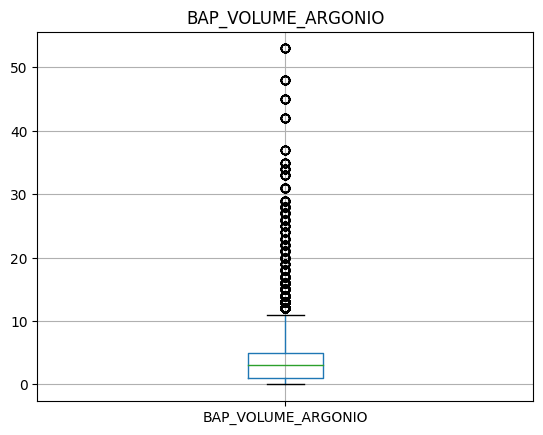

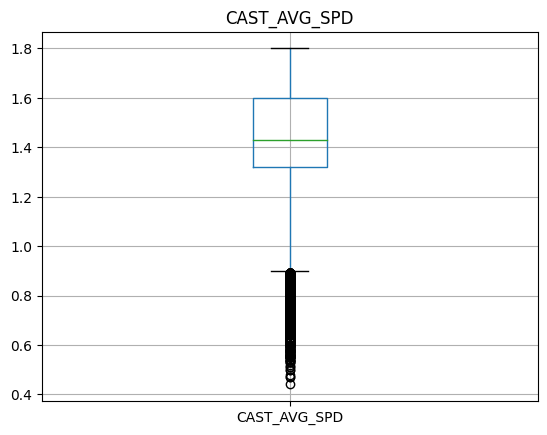

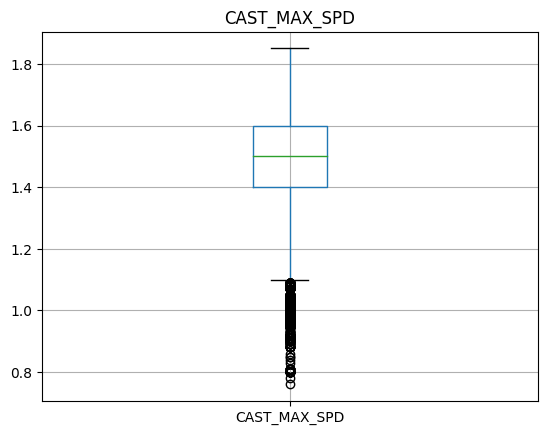

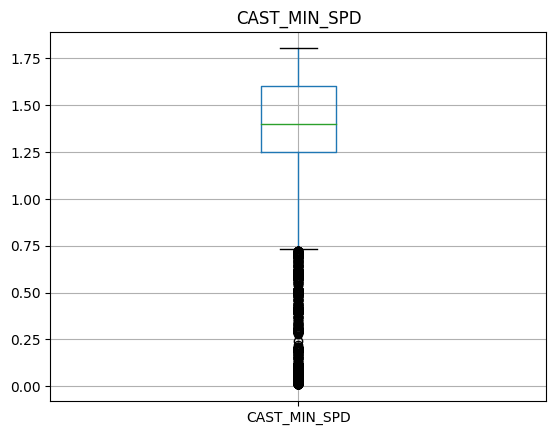

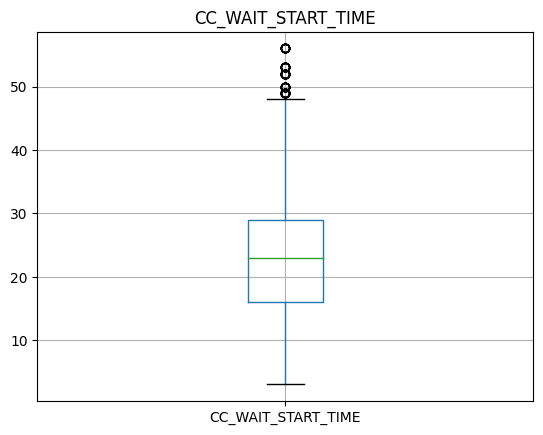

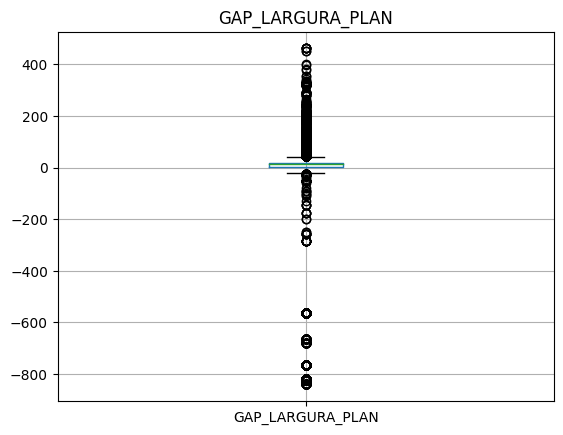

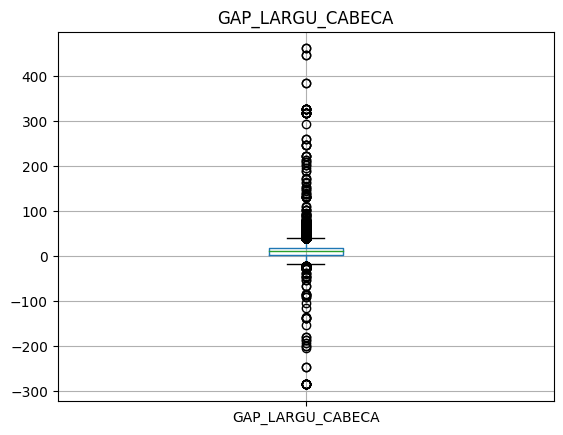

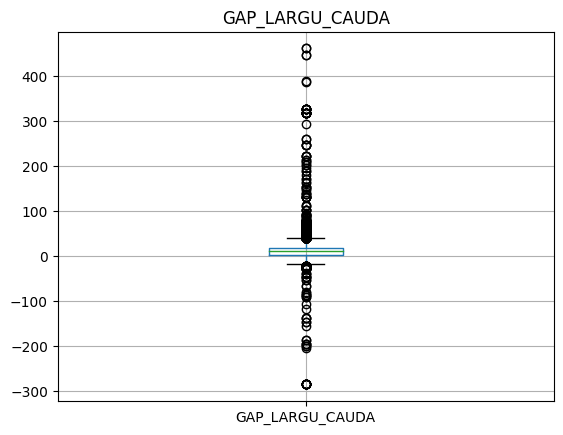

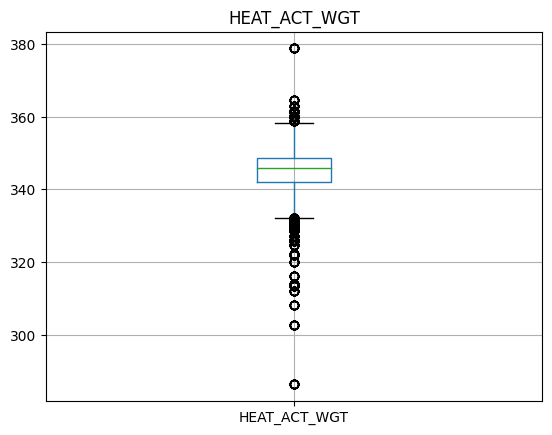

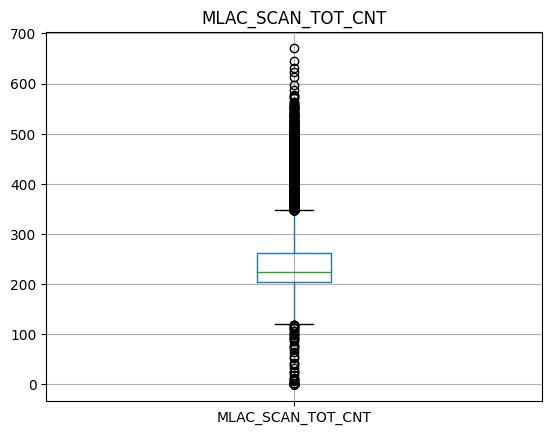

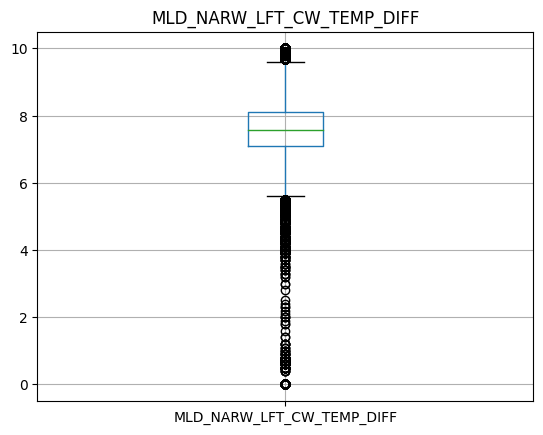

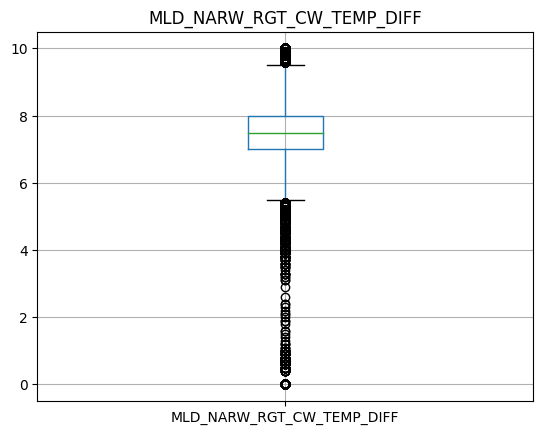

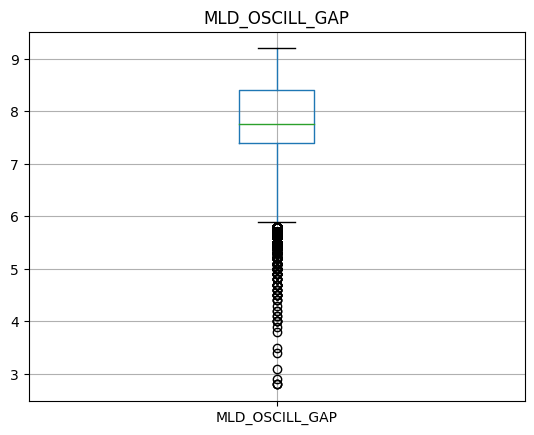

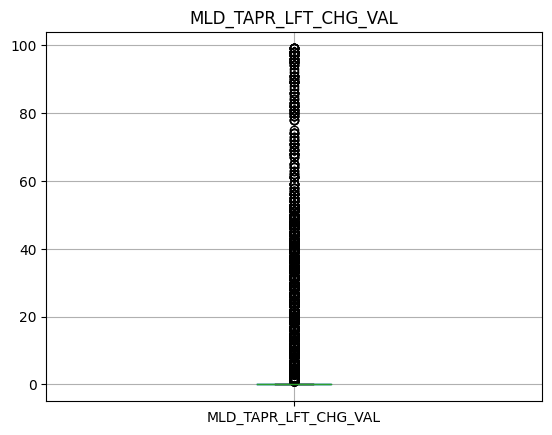

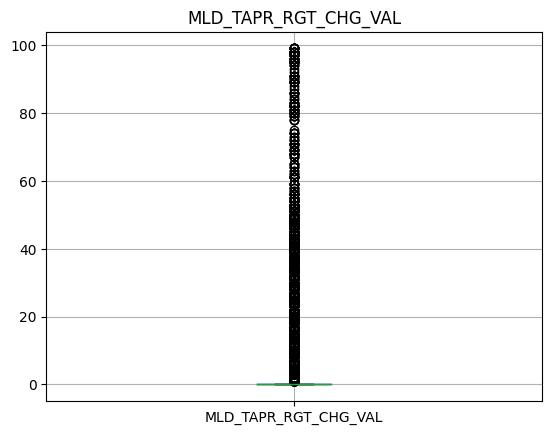

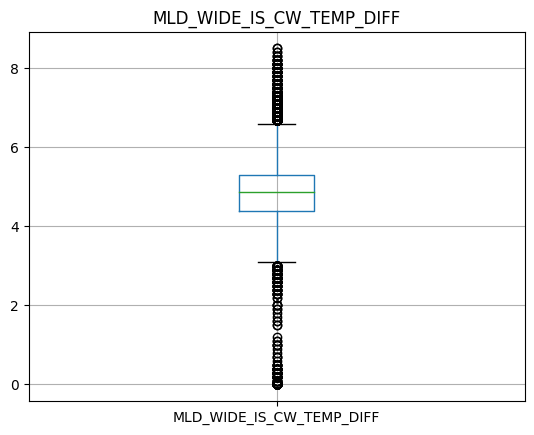

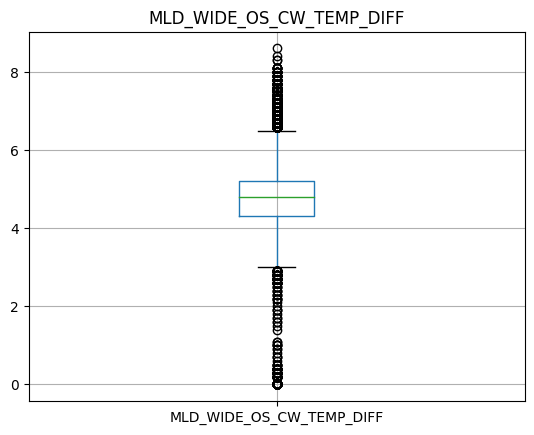

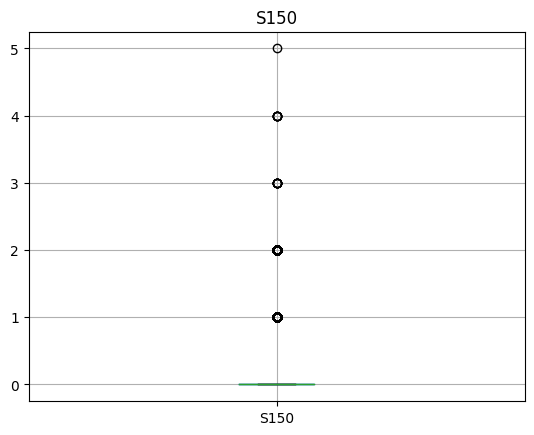

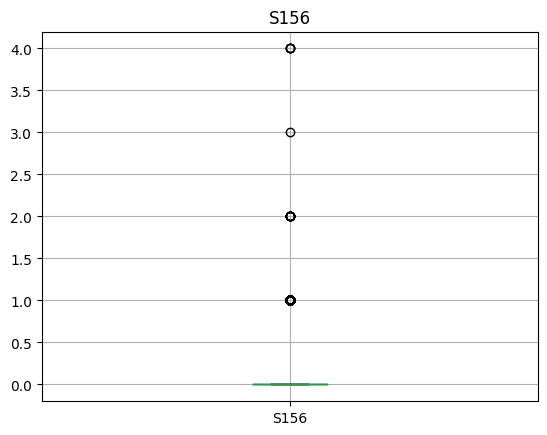

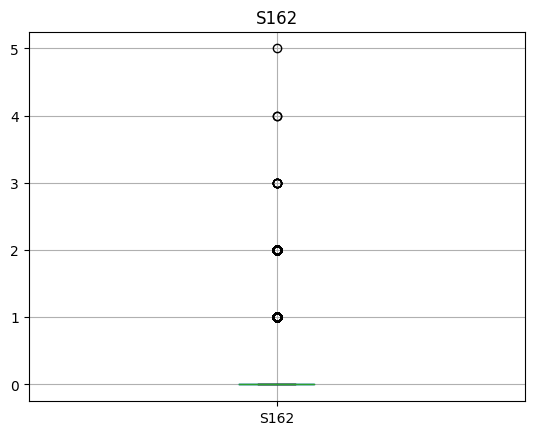

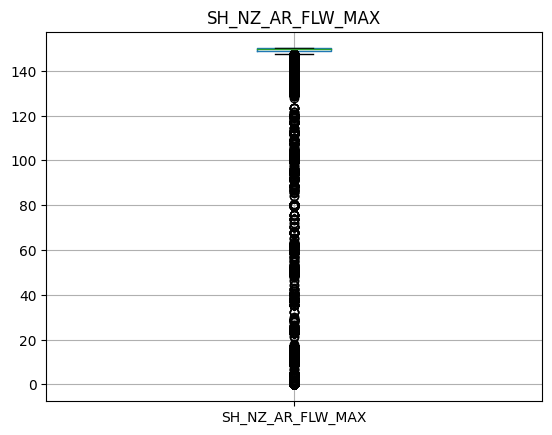

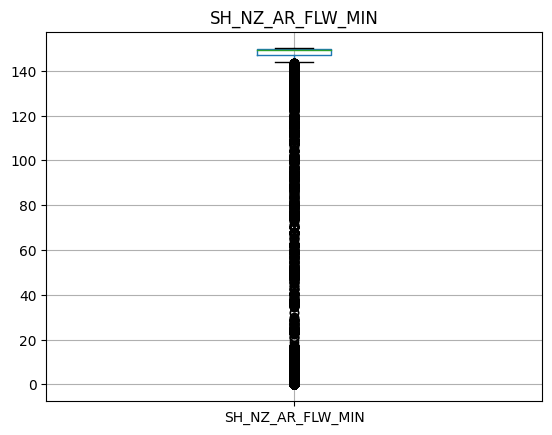

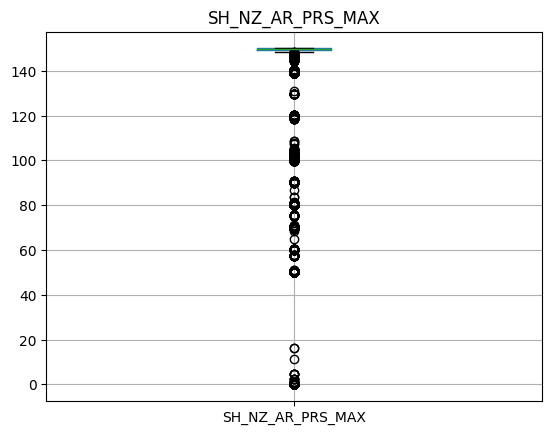

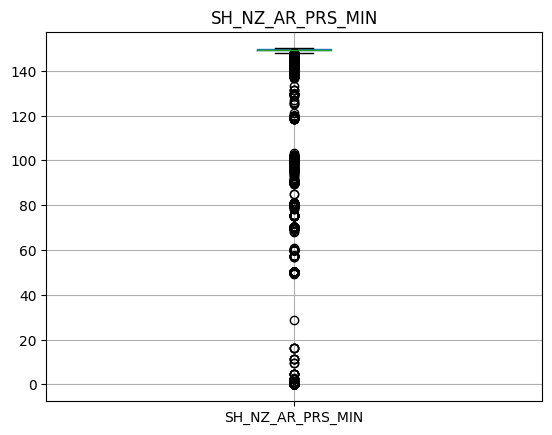

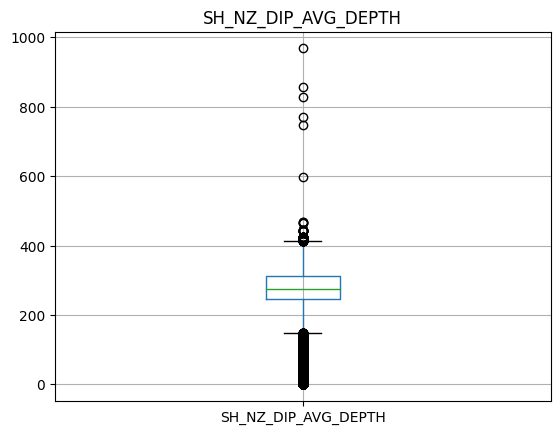

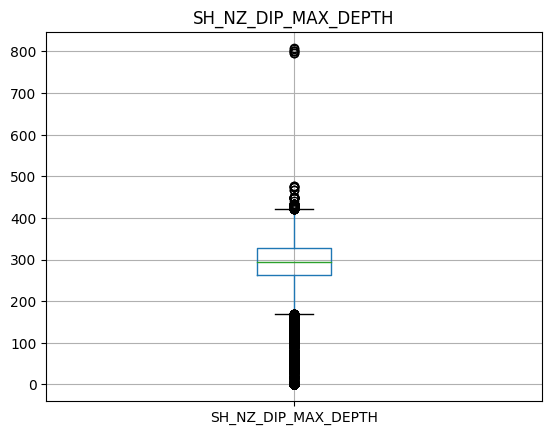

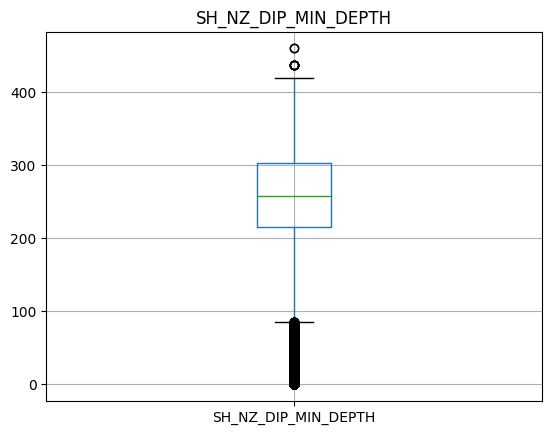

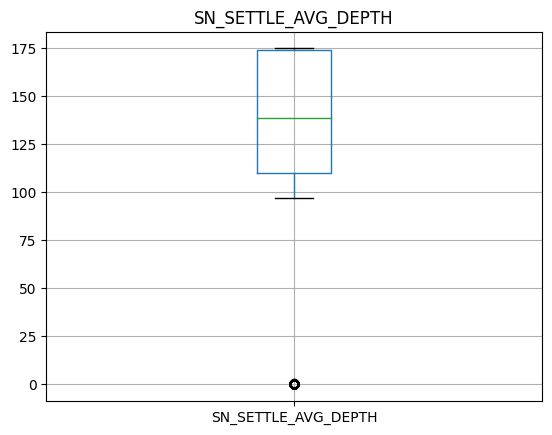

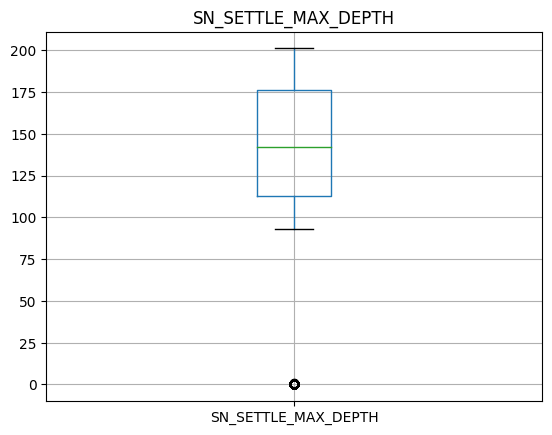

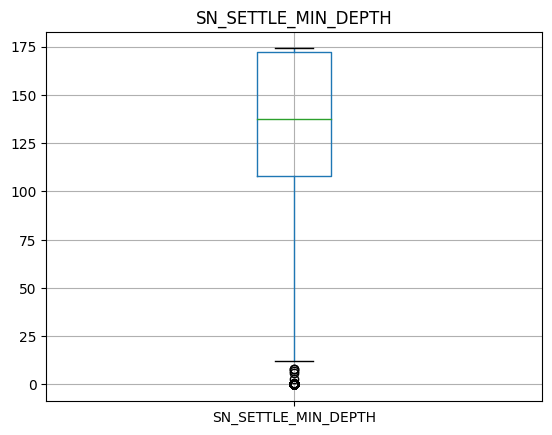

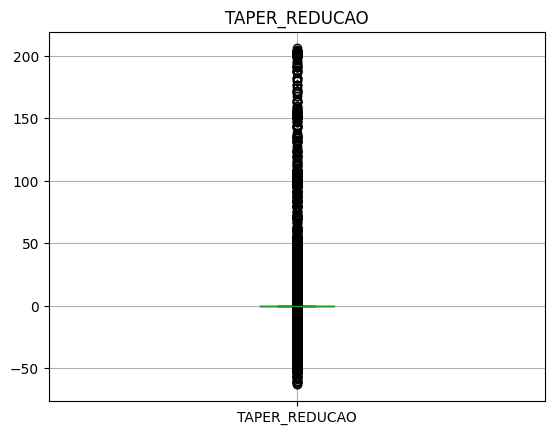

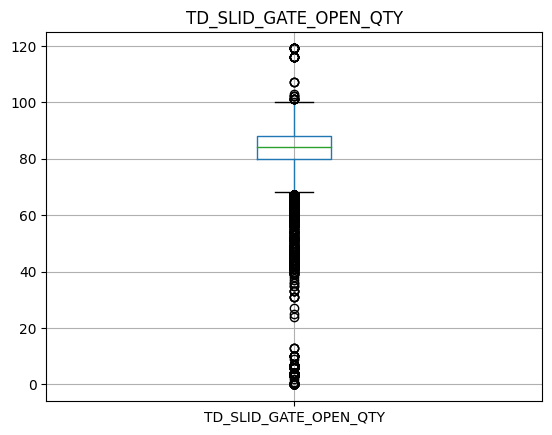

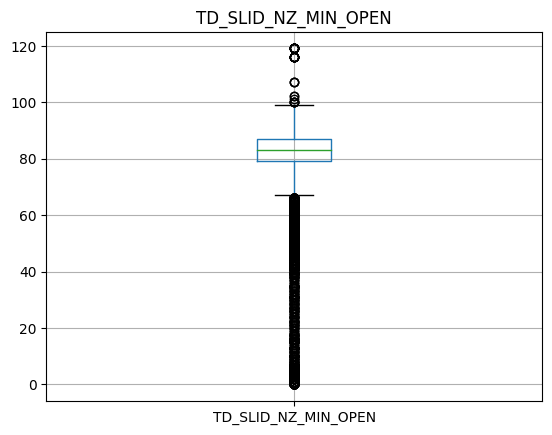

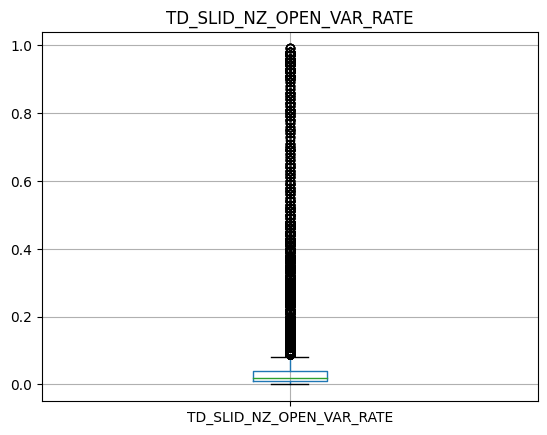

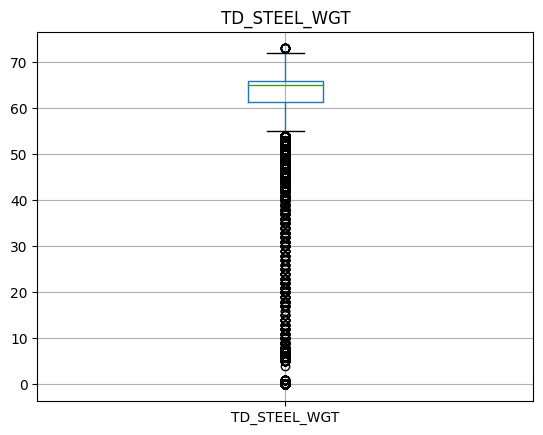

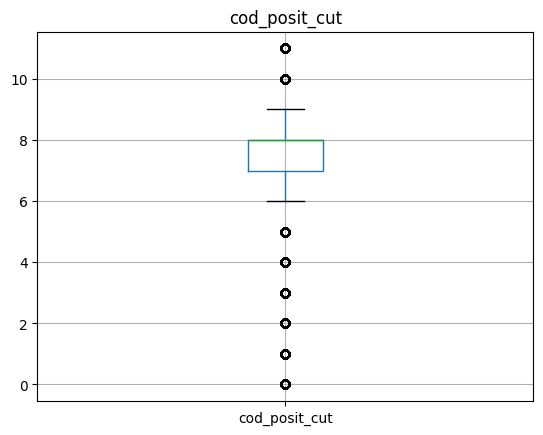

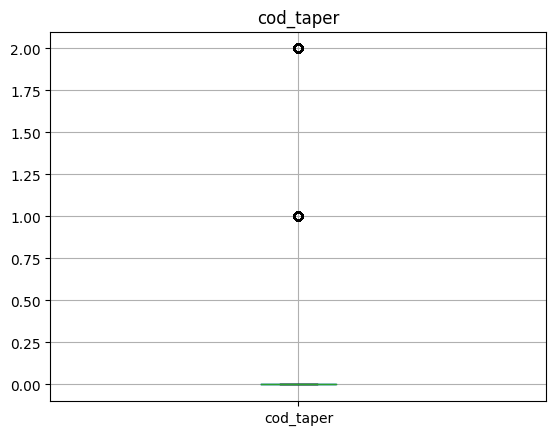

In [202]:
# Obtendo as estatísticas descritivas do DataFrame
descricao = model_data.describe()

# Discriminando os quartis
Q1 = descricao.loc['25%']
Q3 = descricao.loc['75%']
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = (model_data < limite_inferior) | (model_data > limite_superior)

# Contar o número de outliers em cada coluna
num_outliers = outliers.sum()

# Exibir as colunas com outliers
colunas_com_outliers = num_outliers[num_outliers > 0].index
print("Colunas com outliers:", colunas_com_outliers)

# Visualizar os boxplots das colunas com outliers
for coluna in colunas_com_outliers:
    model_data.boxplot(column=coluna)
    plt.title(coluna)
    plt.show()

In [203]:
model_data_tratado = model_data.copy()
for coluna in colunas_com_outliers:
    model_data_tratado[coluna] = np.where(model_data_tratado[coluna] < limite_inferior[coluna], limite_inferior[coluna], model_data_tratado[coluna])
    model_data_tratado[coluna] = np.where(model_data_tratado[coluna] > limite_superior[coluna], limite_superior[coluna], model_data_tratado[coluna])

model_data_tratado.describe()

HEAT_ACT_WGT  GAP_LARGURA_PLAN  GAP_LARGU_CABECA  GAP_LARGU_CAUDA  \
count  55631.000000      55631.000000      55631.000000     55631.000000   
mean     345.099262         10.560756         10.931088        10.978089   
std        4.715152         13.222034         10.893606        10.977077   
min      332.100000        -22.000000        -19.500000       -19.500000   
25%      342.000000          2.000000          3.000000         3.000000   
50%      345.820000         12.000000         12.000000        12.000000   
75%      348.600000         18.000000         18.000000        18.000000   
max      358.500000         42.000000         40.500000        40.500000   

             BOF_NO     S150     S156     S162  HEAT_SEQ_POSITION  \
count  55631.000000  55631.0  55631.0  55631.0       55631.000000   
mean       1.486977      0.0      0.0      0.0           0.548840   
std        0.499835      0.0      0.0      0.0           0.287643   
min        1.000000      0.0      0.0      0.0           0.020000   
25%        1.000000      0.0      0.0      0.0           0.300000   
50%        1.000000      0.0      0.0      0.0           0.560000   
75%        2.000000      0.0      0.0      0.0           0.800000   
max        2.000000      0.0      0.0      0.0           1.000000   

       CC_WAIT_START_TIME  cod_posit_cut  TAPER_REDUCAO  cod_taper  \
count        55631.000000   55631.000000        53097.0    55631.0   
mean            22.557171       7.724551            0.0        0.0   
std              8.368551       1.128025            0.0        0.0   
min              3.000000       5.500000            0.0        0.0   
25%             16.000000       7.000000            0.0        0.0   
50%             23.000000       8.000000            0.0        0.0   
75%             29.000000       8.000000            0.0        0.0   
max             48.500000       9.500000            0.0        0.0   

       TD_STEEL_WGT  CAST_MIN_SPD  CAST_AVG_SPD  CAST_MAX_SPD  MLD_OSCILL_GAP  \
count  55631.000000  55631.000000  55631.000000  55631.000000    55631.000000   
mean      63.066333      1.385372      1.431001      1.488817        7.767302   
std        4.489807      0.281071      0.240148      0.200929        0.913938   
min       54.636720      0.725000      0.900000      1.100000        5.900000   
25%       61.454688      1.250000      1.320000      1.400000        7.400000   
50%       65.000000      1.400000      1.427671      1.500000        7.754108   
75%       66.000000      1.600000      1.600000      1.600000        8.400000   
max       72.817968      1.800000      1.800000      1.850000        9.200000   

       BAP_VOLUME_ARGONIO  CAST_IN_LD_STEEL_WGT  MLD_TAPR_RGT_CHG_VAL  \
count        55631.000000          55631.000000               55631.0   
mean             3.385217            115.580385                   0.0   
std              3.205124             85.647113                   0.0   
min              0.000000              0.000000                   0.0   
25%              1.000000             34.400000                   0.0   
50%              3.000000            115.580385                   0.0   
75%              5.000000            186.000000                   0.0   
max             11.000000            344.200000                   0.0   

       MLD_TAPR_LFT_CHG_VAL  TD_SLID_NZ_MIN_OPEN  TD_SLID_GATE_OPEN_QTY  \
count               55631.0         55631.000000           55631.000000   
mean                    0.0            82.429265              83.642978   
std                     0.0             6.210692               5.774048   
min                     0.0            67.000000              68.000000   
25%                     0.0            79.000000              80.000000   
50%                     0.0            83.000000              84.000000   
75%                     0.0            87.000000              88.000000   
max                     0.0            99.000000             100.000000   

     

In [204]:
model_data_tratado.pop('S150')
model_data_tratado.pop('S156')
model_data_tratado.pop('S162')
model_data_tratado.pop('TAPER_REDUCAO')
model_data_tratado.pop('cod_taper')
model_data_tratado.pop('MLD_TAPR_RGT_CHG_VAL')
model_data_tratado.pop('MLD_TAPR_LFT_CHG_VAL')

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
55626    0.0
55627    0.0
55628    0.0
55629    0.0
55632    0.0
Name: MLD_TAPR_LFT_CHG_VAL, Length: 55631, dtype: float64

array([[<Axes: title={'center': 'HEAT_ACT_WGT'}>,
        <Axes: title={'center': 'GAP_LARGURA_PLAN'}>,
        <Axes: title={'center': 'GAP_LARGU_CABECA'}>],
       [<Axes: title={'center': 'GAP_LARGU_CAUDA'}>,
        <Axes: title={'center': 'BOF_NO'}>,
        <Axes: title={'center': 'HEAT_SEQ_POSITION'}>],
       [<Axes: title={'center': 'CC_WAIT_START_TIME'}>,
        <Axes: title={'center': 'cod_posit_cut'}>,
        <Axes: title={'center': 'TD_STEEL_WGT'}>],
       [<Axes: title={'center': 'CAST_MIN_SPD'}>,
        <Axes: title={'center': 'CAST_AVG_SPD'}>,
        <Axes: title={'center': 'CAST_MAX_SPD'}>],
       [<Axes: title={'center': 'MLD_OSCILL_GAP'}>,
        <Axes: title={'center': 'BAP_VOLUME_ARGONIO'}>,
        <Axes: title={'center': 'CAST_IN_LD_STEEL_WGT'}>],
       [<Axes: title={'center': 'TD_SLID_NZ_MIN_OPEN'}>,
        <Axes: title={'center': 'TD_SLID_GATE_OPEN_QTY'}>,
        <Axes: title={'center': 'TD_SLID_NZ_OPEN_VAR_RATE'}>],
       [<Axes: title={'center': '

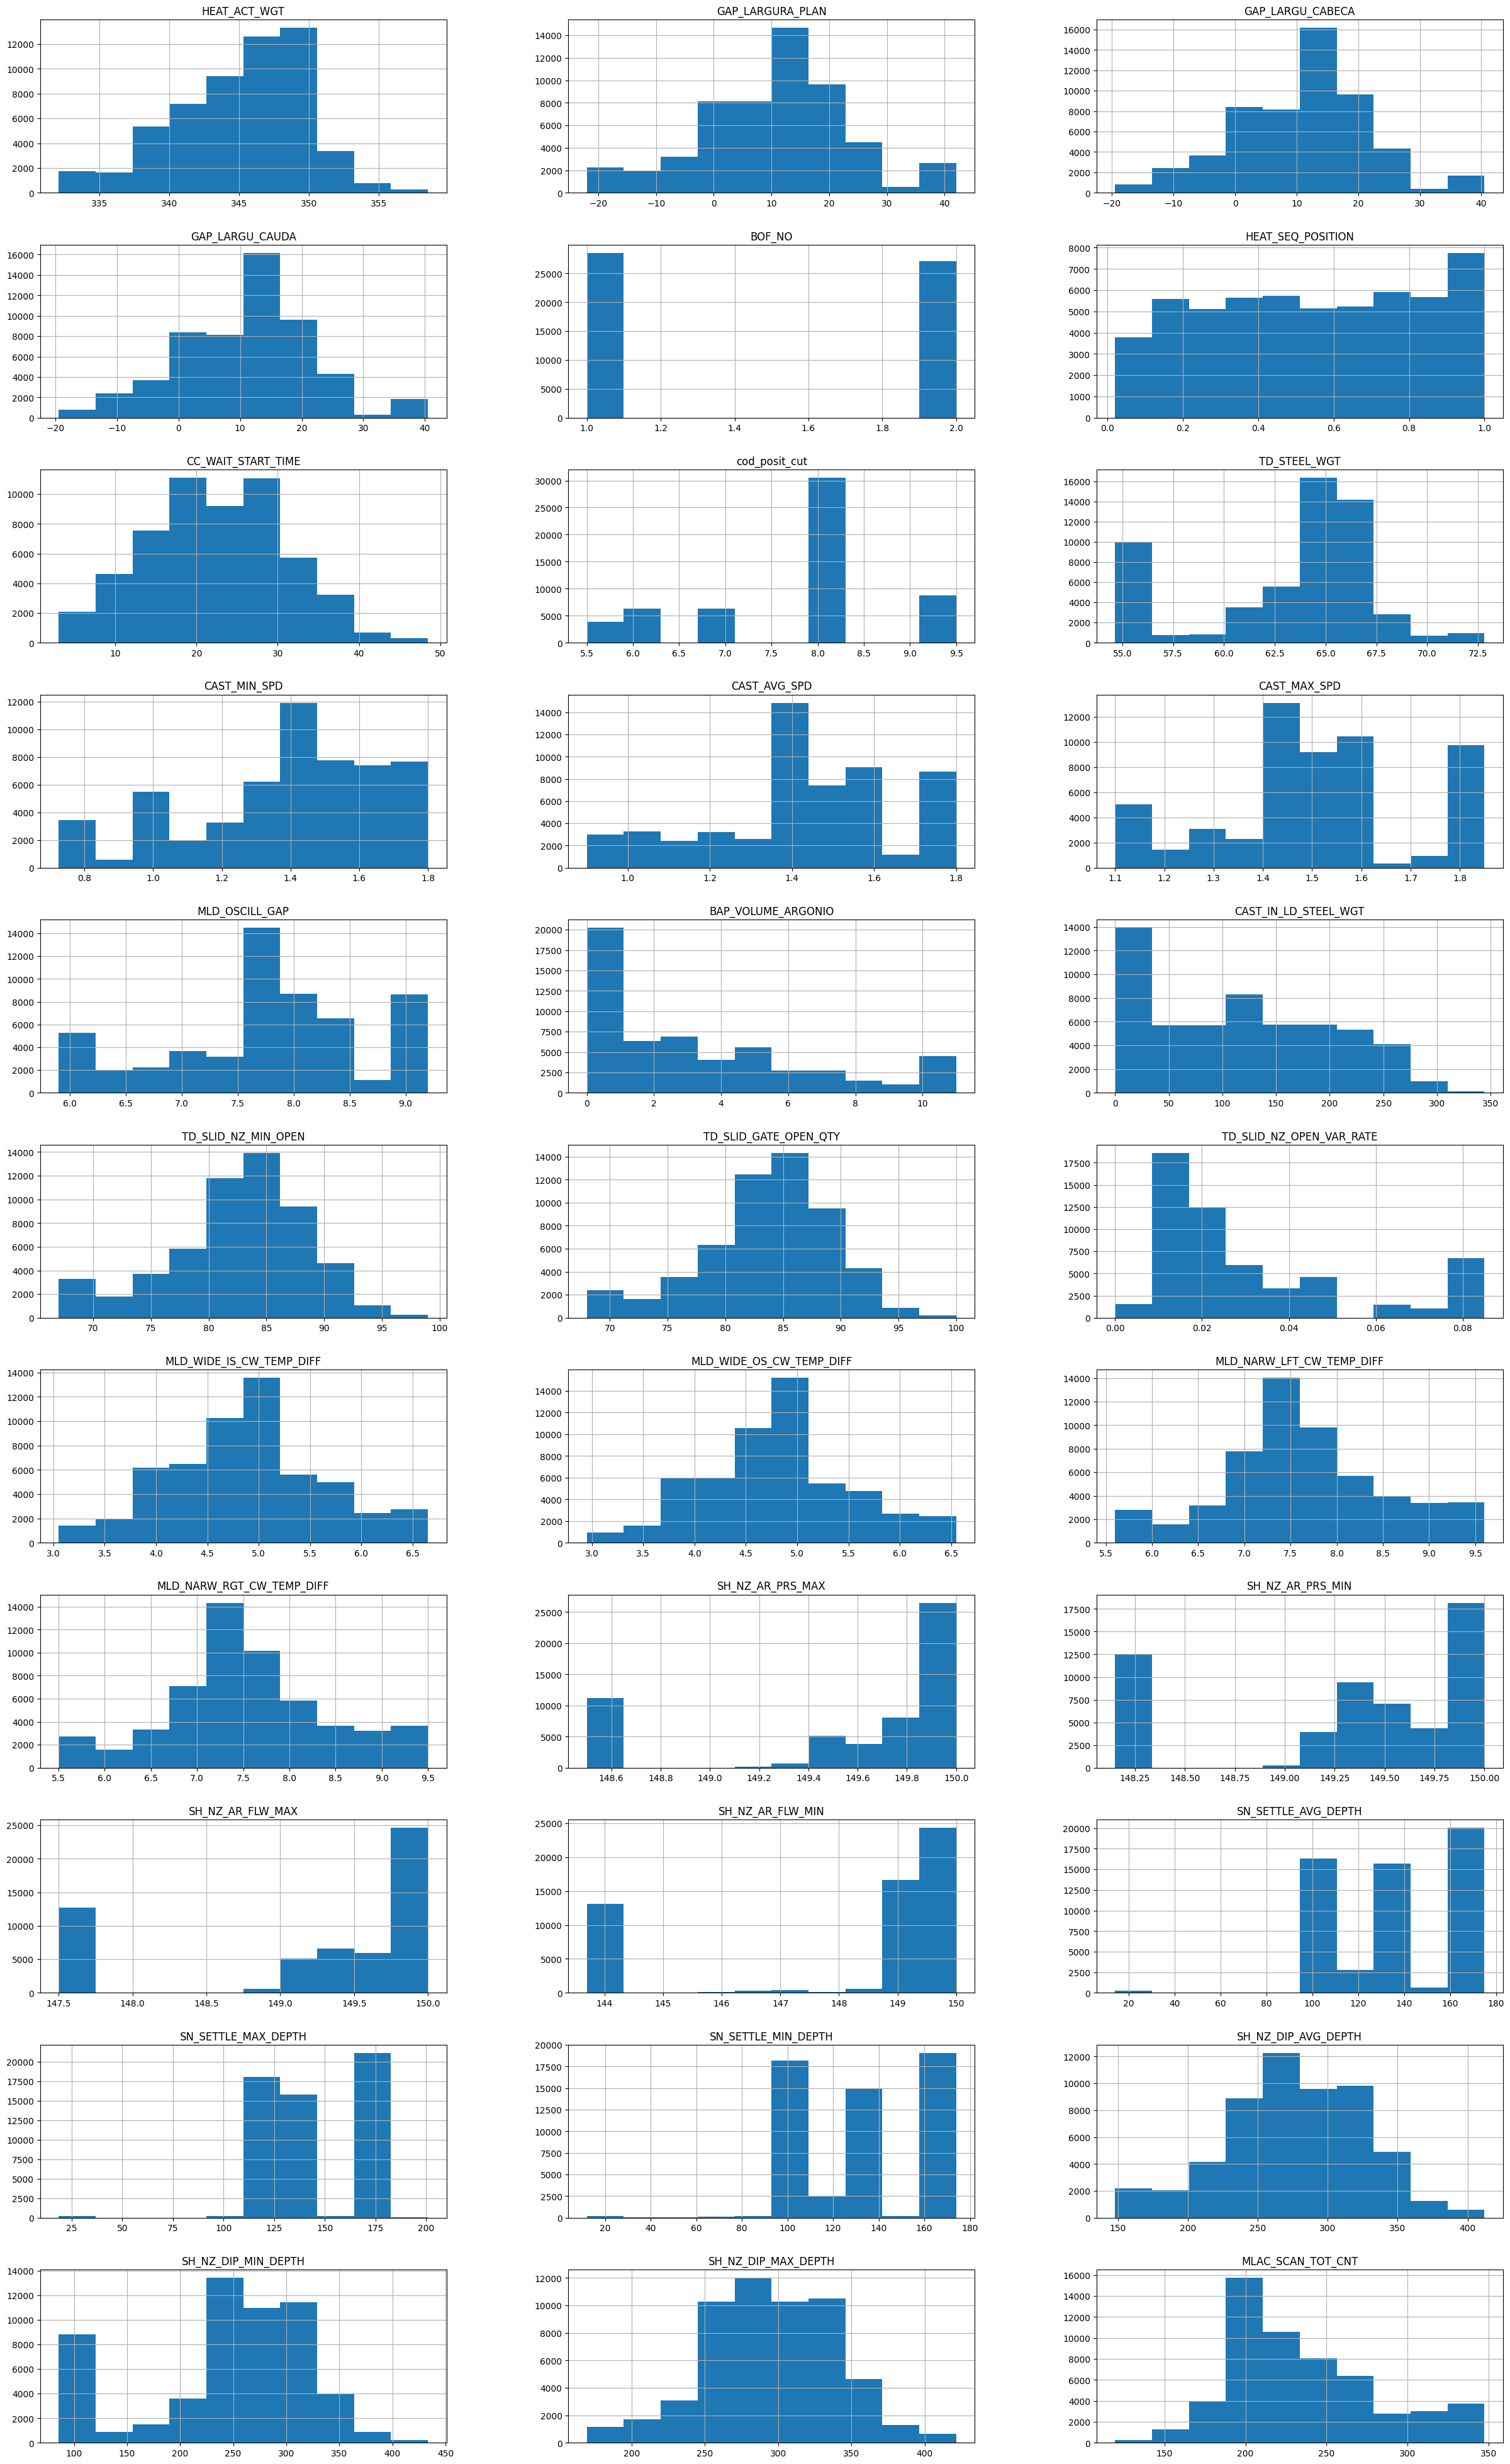

In [205]:
model_data_tratado.hist(figsize = (30, 50), layout=(11,3))

###NORMALIZAÇÃO DE DADOS DO MODELO

In [206]:
col = model_data_tratado.columns
scaler_std = StandardScaler()
model_data_std = pd.DataFrame(scaler_std.fit_transform(model_data_tratado), columns = col)
model_data_std.head()

Defeitos   chem_01   chem_02   chem_03  HEAT_ACT_WGT  GAP_LARGURA_PLAN  \
0 -0.640636  0.386954  0.250267  0.176896     -0.487637         -0.118043   
1 -0.640636  0.386954  0.250267  0.176896     -0.487637         -0.118043   
2 -0.640636  0.386954  0.250267  0.176896     -0.530054         -0.118043   
3 -0.640636  0.386954  0.250267  0.176896     -0.530054         -0.118043   
4 -0.640636  0.386954  0.250267  0.176896     -0.530054         -0.118043   

   GAP_LARGU_CABECA  GAP_LARGU_CAUDA    BOF_NO  DESVIO_LF  DESVIO_ROTA  \
0          -0.17727        -0.180203  1.026395  -0.595212    -0.798229   
1          -0.17727        -0.180203  1.026395  -0.595212    -0.798229   
2          -0.17727        -0.180203  1.026395  -0.595212    -0.798229   
3          -0.17727        -0.180203  1.026395  -0.595212    -0.798229   
4          -0.17727        -0.180203  1.026395  -0.595212    -0.798229   

   HEAT_SEQ_POSITION  CC_WAIT_START_TIME  cod_posit_cut  TD_STEEL_WGT  \
0          -0.795574            0.052916       1.573958     -0.682960   
1          -0.795574            0.052916      -1.528837      0.207954   
2          -0.656512           -0.186076      -1.528837      0.207954   
3          -0.656512           -0.186076      -0.642324      0.207954   
4          -0.656512           -0.186076       0.244189      0.207954   

   CAST_MIN_SPD  CAST_AVG_SPD  CAST_MAX_SPD  MLD_OSCILL_GAP  \
0     -0.268163     -0.378941      -0.69088       -0.401894   
1     -0.125849     -0.337299      -0.69088       -1.824322   
2     -0.125849     -0.337299      -0.69088       -0.401894   
3     -0.125849     -0.337299      -0.69088       -0.401894   
4     -0.125849     -0.337299      -0.69088       -0.401894   

   BAP_VOLUME_ARGONIO  CAST_IN_LD_STEEL_WGT  TD_SLID_NZ_MIN_OPEN  \
0           -1.056199              1.423524             0.896967   
1           -1.056199              1.960616            -0.552160   
2           -0.432192              1.051062             1.057981   
3           -0.432192              0.682103             1.057981   
4           -0.432192              0.311976             1.057981   

   TD_SLID_GATE_OPEN_QTY  TD_SLID_NZ_OPEN_VAR_RATE  MLD_WIDE_IS_CW_TEMP_DIFF  \
0               0.927784                 -0.414532                  0.821978   
1              -0.457738                  0.789862                 -0.500909   
2               1.100974                 -0.414532                  1.086555   
3               1.100974                 -0.414532                  1.086555   
4               0.927784                 -0.815997                  1.086555   

   MLD_WIDE_OS_CW_TEMP_DIFF  MLD_NARW_LFT_CW_TEMP_DIFF  \
0                  0.677383                  -0.563094   
1                 -0.290226                  -1.347761   
2                  0.953843                  -0.338903   
3                  0.815613                  -0.114712   
4                  0.815613                  -0.226808   

   MLD_NARW_RGT_CW_TEMP_DIFF  SH_NZ_AR_PRS_MAX  SH_NZ_AR_PRS_MIN  \
0                  -0.799201          0.767325         -0.172942   
1                  -1.472279          0.767325          0.713578   
2                  -0.462661          0.767325          0.861331   
3                  -0.462661          0.767325          0.861331   
4                  -0.462661          0.767325          0.713578   

   SH_NZ_AR_FLW_MAX  SH_NZ_AR_FLW_MIN  SN_SETTLE_AVG_DEPTH  \
0          0.828894          0.660984             1.173493   
1          0.828894          0.701438             1.173493   
2          0.828894          0.701438             1.173493   
3          0.828894          0.701438             1.173493   
4          0.828894          0.701438             1.173493   

   SN_SETTLE_MAX_DEPTH  SN_SETTLE_MIN_DEPTH  SH_NZ_DIP_AVG_DEPTH  \
0             1.103890             1.162955            -1.760322   
1             1.103890             1.232093            -0.942294   
2             1.139316             1.232093         

In [207]:
mn_mx_scal = MinMaxScaler()
dados_normalizados = pd.DataFrame(mn_mx_scal.fit_transform(model_data_std), columns = col)
dados_normalizados.head()

Defeitos  chem_01  chem_02  chem_03  HEAT_ACT_WGT  GAP_LARGURA_PLAN  \
0       0.0      1.0      1.0      1.0      0.405303          0.484375   
1       0.0      1.0      1.0      1.0      0.405303          0.484375   
2       0.0      1.0      1.0      1.0      0.397727          0.484375   
3       0.0      1.0      1.0      1.0      0.397727          0.484375   
4       0.0      1.0      1.0      1.0      0.397727          0.484375   

   GAP_LARGU_CABECA  GAP_LARGU_CAUDA  BOF_NO  DESVIO_LF  DESVIO_ROTA  \
0             0.475            0.475     1.0        0.0          0.0   
1             0.475            0.475     1.0        0.0          0.0   
2             0.475            0.475     1.0        0.0          0.0   
3             0.475            0.475     1.0        0.0          0.0   
4             0.475            0.475     1.0        0.0          0.0   

   HEAT_SEQ_POSITION  CC_WAIT_START_TIME  cod_posit_cut  TD_STEEL_WGT  \
0           0.306122            0.439560          1.000      0.294990   
1           0.306122            0.439560          0.125      0.514997   
2           0.346939            0.395604          0.125      0.514997   
3           0.346939            0.395604          0.375      0.514997   
4           0.346939            0.395604          0.625      0.514997   

   CAST_MIN_SPD  CAST_AVG_SPD  CAST_MAX_SPD  MLD_OSCILL_GAP  \
0      0.544186      0.488889      0.333333        0.454545   
1      0.581395      0.500000      0.333333        0.060606   
2      0.581395      0.500000      0.333333        0.454545   
3      0.581395      0.500000      0.333333        0.454545   
4      0.581395      0.500000      0.333333        0.454545   

   BAP_VOLUME_ARGONIO  CAST_IN_LD_STEEL_WGT  TD_SLID_NZ_MIN_OPEN  \
0            0.000000              0.690006              0.65625   
1            0.000000              0.823649              0.37500   
2            0.181818              0.597327              0.68750   
3            0.181818              0.505520              0.68750   
4            0.181818              0.413422              0.68750   

   TD_SLID_GATE_OPEN_QTY  TD_SLID_NZ_OPEN_VAR_RATE  MLD_WIDE_IS_CW_TEMP_DIFF  \
0                0.65625                  0.235294                  0.680556   
1                0.40625                  0.588235                  0.402778   
2                0.68750                  0.235294                  0.736111   
3                0.68750                  0.235294                  0.736111   
4                0.65625                  0.117647                  0.736111   

   MLD_WIDE_OS_CW_TEMP_DIFF  MLD_NARW_LFT_CW_TEMP_DIFF  \
0                  0.652778                      0.375   
1                  0.458333                      0.200   
2                  0.708333                      0.425   
3                  0.680556                      0.475   
4                  0.680556                      0.450   

   MLD_NARW_RGT_CW_TEMP_DIFF  SH_NZ_AR_PRS_MAX  SH_NZ_AR_PRS_MIN  \
0                      0.325               1.0          0.567568   
1                      0.175               1.0          0.891892   
2                      0.400               1.0          0.945946   
3                      0.400               1.0          0.945946   
4                      0.400               1.0          0.891892   

   SH_NZ_AR_FLW_MAX  SH_NZ_AR_FLW_MIN  SN_SETTLE_AVG_DEPTH  \
0               1.0          0.952381             0.993789   
1               1.0          0.968254             0.993789   
2               1.0          0.968254             0.993789   
3               1.0          0.968254             0.993789   
4               1.0          0.968254             0.993789   

   SN_SETTLE_MAX_DEPTH  SN_SETTLE_MIN_DEPTH  SH_NZ_DIP_AVG_DEPTH  \
0             0.863014             0.981481             0.151515   
1             0.863014             0.993827             0.306818   
2             0.868493             0.993827             0.018939   
3             

array([[<Axes: title={'center': 'Defeitos'}>,
        <Axes: title={'center': 'chem_01'}>,
        <Axes: title={'center': 'chem_02'}>,
        <Axes: title={'center': 'chem_03'}>],
       [<Axes: title={'center': 'HEAT_ACT_WGT'}>,
        <Axes: title={'center': 'GAP_LARGURA_PLAN'}>,
        <Axes: title={'center': 'GAP_LARGU_CABECA'}>,
        <Axes: title={'center': 'GAP_LARGU_CAUDA'}>],
       [<Axes: title={'center': 'BOF_NO'}>,
        <Axes: title={'center': 'DESVIO_LF'}>,
        <Axes: title={'center': 'DESVIO_ROTA'}>,
        <Axes: title={'center': 'HEAT_SEQ_POSITION'}>],
       [<Axes: title={'center': 'CC_WAIT_START_TIME'}>,
        <Axes: title={'center': 'cod_posit_cut'}>,
        <Axes: title={'center': 'TD_STEEL_WGT'}>,
        <Axes: title={'center': 'CAST_MIN_SPD'}>],
       [<Axes: title={'center': 'CAST_AVG_SPD'}>,
        <Axes: title={'center': 'CAST_MAX_SPD'}>,
        <Axes: title={'center': 'MLD_OSCILL_GAP'}>,
        <Axes: title={'center': 'BAP_VOLUME_ARGONI

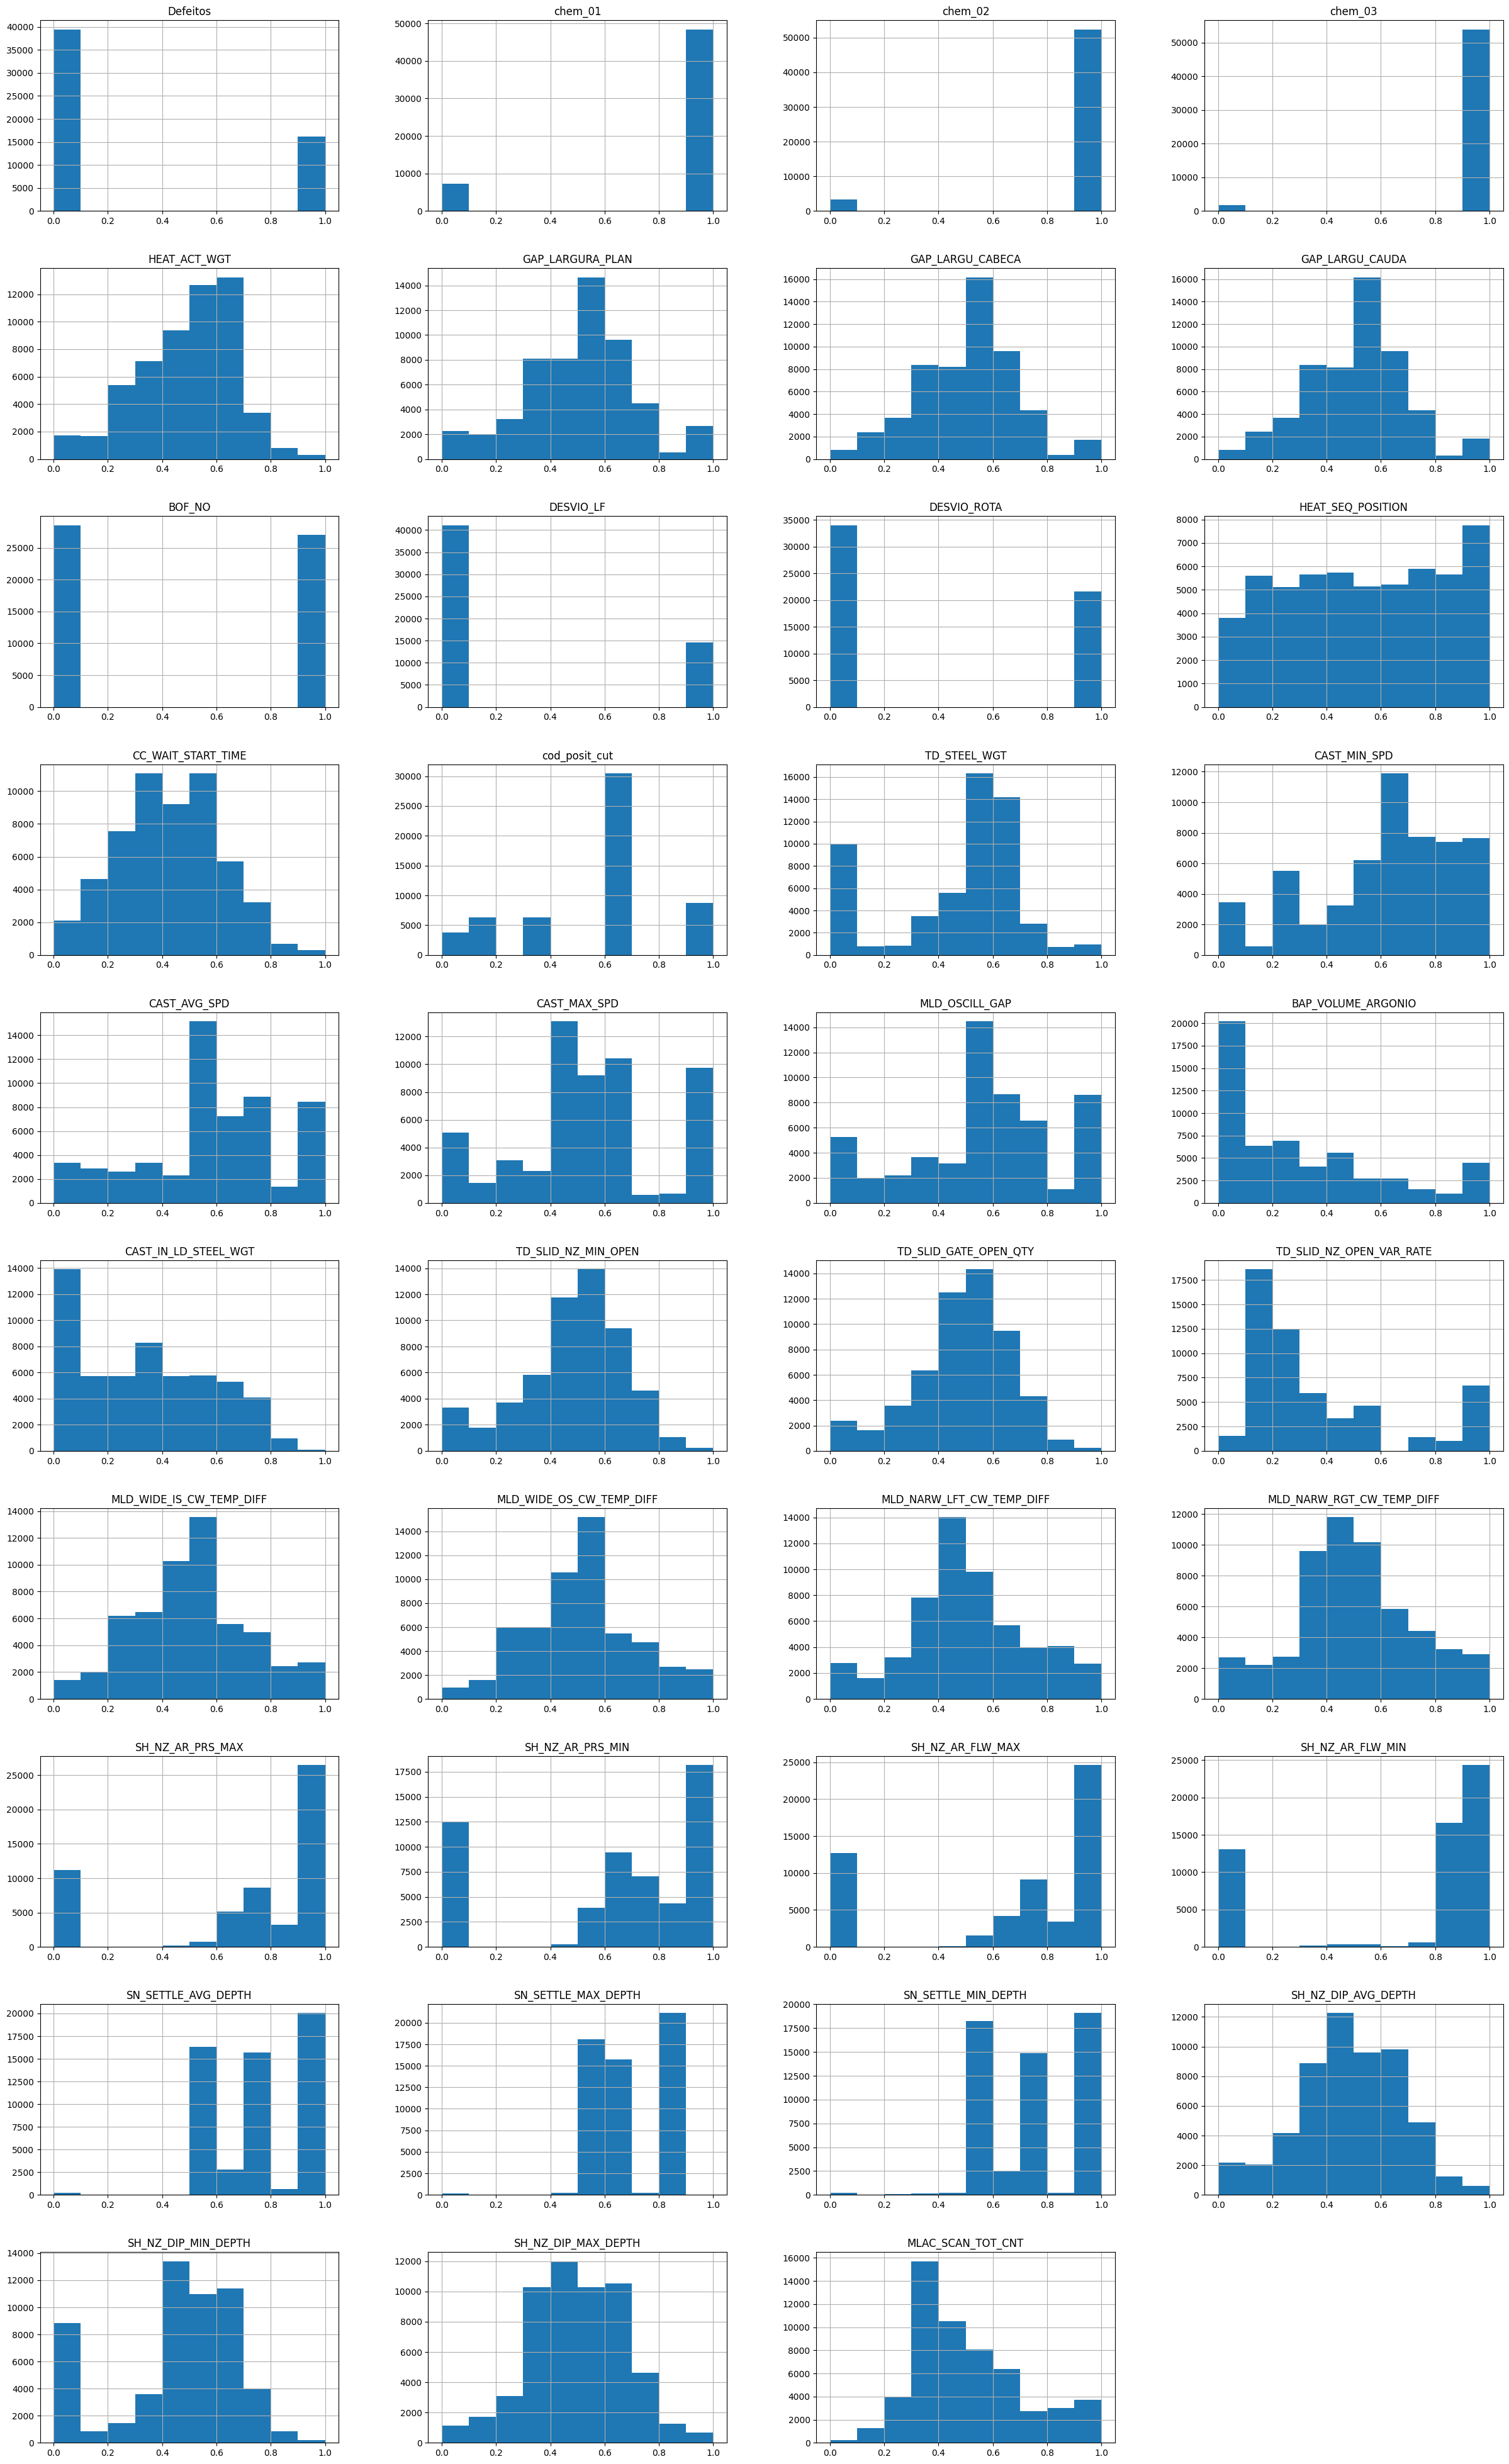

In [208]:
dados_normalizados.hist(figsize = (30, 50), layout=(10,4))

#>MODELOS

##LOGISTIC REGRESSION

In [209]:
model_data_log = dados_normalizados.copy(deep=True)
atributos = list(model_data_log)[1:(model_data_log.shape[1]-2)]
rotulos = list(model_data_log)[0]

def_class_names = ['Sem Defeitos', 'Com Defeitos']

x = model_data_log.iloc[:, 1:999]
y = model_data_log.loc[:, 'Defeitos']

x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x, y, test_size=0.2, random_state=0) 

print("Base de Treinamento: {0}".format(x_train_log.shape))
print("Base de Testes: {0}".format(x_test_log.shape))

log_regression_model = LogisticRegression(penalty='none', solver='lbfgs')

log_regression_model.fit(x_train_log, y_train_log)
y_prev = log_regression_model.predict(x_test_log)

print("Acuracia base treinamento: {:.2f}%".format(log_regression_model.score(x_train_log, y_train_log)*100))
print("Acuracia base testes: {:.2f}%".format(log_regression_model.score(x_test_log, y_test_log)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_prev, y_test_log) ))
print("Número de atributos usados: {}".format(np.sum(log_regression_model.coef_ != 0)))

Base de Treinamento: (44504, 38)
Base de Testes: (11127, 38)
Acuracia base treinamento: 81.65%
Acuracia base testes: 81.42%
R^2 Score: -0.111;
Número de atributos usados: 38


              precision    recall  f1-score   support

Sem Defeitos       0.83      0.92      0.88      7889
Com Defeitos       0.75      0.55      0.63      3238

    accuracy                           0.81     11127
   macro avg       0.79      0.73      0.75     11127
weighted avg       0.81      0.81      0.80     11127

Acurácia em cada fold: [0.815414   0.81608808 0.8118189  0.81811032 0.8211236 ]
Acurácia média: 0.82
Desvio padrão: 0.0031


Acurácia média: 81.65%
Intervalo de acurácia: [81.04% ~ 82.27%]


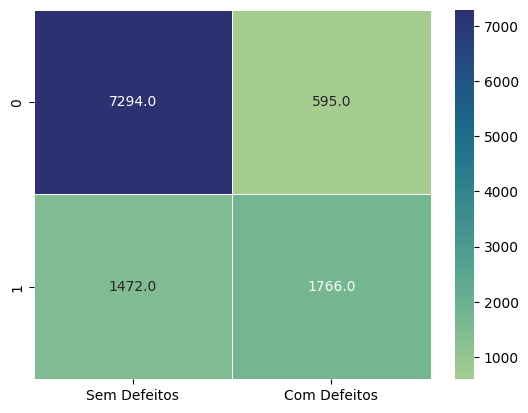

In [210]:
print(classification_report(y_test_log, y_prev, target_names=def_class_names))

cnf_matrix = confusion_matrix(y_test_log, y_prev)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )

sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

results = cross_val_score(log_regression_model, x_train_log, y_train_log, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('\n\nAcurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))

intervalo(results)

##DECISION TREE

In [211]:
model_data_dtree = dados_normalizados.copy(deep=True)
atributos_tree = list(model_data_dtree)[1:999]

x = model_data_dtree.iloc[:, 1:999]
y = model_data_dtree.loc[:, 'Defeitos']

x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x, y, test_size=0.2, random_state=0) 

print("Base de Treinamento: {0}".format(x_train_tree.shape))
print("Base de Testes: {0}".format(x_test_tree.shape))

def_class_names = ['Sem Defeitos', 'Com Defeitos']

dtree_model = DecisionTreeClassifier (random_state=0)

dtree_model.fit(x_train_tree, y_train_tree)
y_tree_predict = dtree_model.predict(x_test_tree)

print("Acuracia base treinamento: {:.2f}%".format(dtree_model.score(x_train_tree, y_train_tree)*100))
print("Acuracia base testes: {:.2f}%".format(dtree_model.score(x_test_tree, y_test_tree)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_tree_predict, y_test_tree) ))

Base de Treinamento: (44504, 38)
Base de Testes: (11127, 38)
Acuracia base treinamento: 99.99%
Acuracia base testes: 91.19%
R^2 Score: 0.573;


              precision    recall  f1-score   support

Sem Defeitos       0.94      0.94      0.94      7889
Com Defeitos       0.85      0.85      0.85      3238

    accuracy                           0.91     11127
   macro avg       0.89      0.89      0.89     11127
weighted avg       0.91      0.91      0.91     11127

Acurácia em cada fold: [0.90293225 0.89731491 0.90708909 0.90989776 0.90314607]
Acurácia média: 0.90
Desvio padrão: 0.0043


Acurácia média: 90.41%
Intervalo de acurácia: [89.56% ~ 91.26%]


<Axes: >

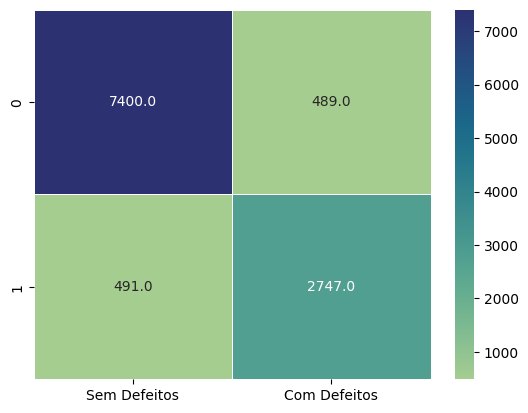

In [212]:
print(classification_report(y_test_tree, y_tree_predict, target_names=def_class_names))

results = cross_val_score(dtree_model, x_train_tree, y_train_tree, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('\n\nAcurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))

intervalo(results)

cnf_matrix = confusion_matrix(y_test_tree, y_tree_predict)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

####ARVORE DE DECISÃO

In [213]:
from sklearn.tree import export_text, export_graphviz
#r = export_text(dtree_model, feature_names=atributos_tree)

tree.export_graphviz(dtree_model)

'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="x[14] <= 0.599\\ngini = 0.413\\nsamples = 44504\\nvalue = [31554, 12950]"] ;\n1 [label="x[22] <= 0.496\\ngini = 0.485\\nsamples = 16707\\nvalue = [6925, 9782]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="x[14] <= 0.312\\ngini = 0.478\\nsamples = 7592\\nvalue = [4592, 3000]"] ;\n1 -> 2 ;\n3 [label="x[4] <= 0.289\\ngini = 0.486\\nsamples = 2407\\nvalue = [999, 1408]"] ;\n2 -> 3 ;\n4 [label="x[3] <= 0.113\\ngini = 0.48\\nsamples = 1202\\nvalue = [721, 481]"] ;\n3 -> 4 ;\n5 [label="x[36] <= 0.373\\ngini = 0.33\\nsamples = 115\\nvalue = [24, 91]"] ;\n4 -> 5 ;\n6 [label="x[34] <= 0.347\\ngini = 0.413\\nsamples = 24\\nvalue = [17, 7]"] ;\n5 -> 6 ;\n7 [label="x[12] <= 0.375\\ngini = 0.469\\nsamples = 8\\nvalue = [3, 5]"] ;\n6 -> 7 ;\n8 [label="x[5] <= 0.217\\ngini = 0.375\\nsamples = 4\\nvalue = [3, 1]"] ;\n7 -> 8 ;\n9 [label="gini = 0.0\\nsamples = 3\\nvalue = [

##RANDOM FOREST

In [214]:
model_data_rf = dados_normalizados.copy(deep=True)
atributos = list(model_data_rf)[1:(model_data_log.shape[1]-2)]
rotulos = list(model_data_rf)[0]

x_rf = model_data_rf.iloc[:, 1:999]
y_rf = model_data_rf.loc[:, 'Defeitos']

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=0) 

random_forest_model = RandomForestClassifier(random_state=4, n_jobs=-1, n_estimators=20, min_samples_leaf=5, criterion='gini', max_depth=8)
random_forest_model.fit(x_train_rf, y_train_rf)
y_pred_rf = random_forest_model.predict(x_test_rf)

print("Acuracia base treinamento: {:.2f}%".format(random_forest_model.score(x_train_rf, y_train_rf)*100))
print("Acuracia base testes: {:.2f}%".format(random_forest_model.score(x_test_rf, y_test_rf)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred_rf, y_test_rf) ))

Acuracia base treinamento: 89.49%
Acuracia base testes: 88.90%
R^2 Score: 0.326;


              precision    recall  f1-score   support

Sem Defeitos       0.88      0.98      0.93      7889
Com Defeitos       0.93      0.67      0.78      3238

    accuracy                           0.89     11127
   macro avg       0.91      0.82      0.85     11127
weighted avg       0.89      0.89      0.88     11127

Acurácia em cada fold: [0.88810246 0.88417032 0.88574317 0.88226042 0.8952809 ]
Acurácia média: 0.89
Desvio padrão: 0.0045
Acurácia média: 88.71%
Intervalo de acurácia: [87.81% ~ 89.61%]


<Axes: >

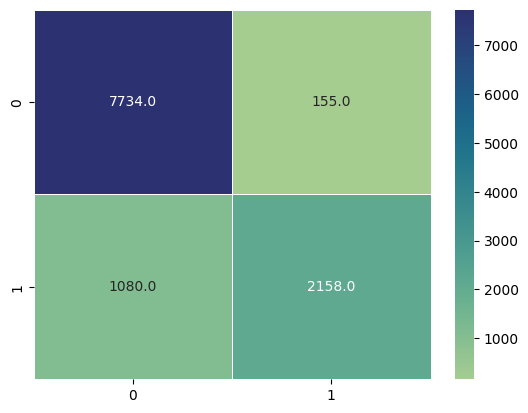

In [215]:
print(classification_report(y_test_rf, y_pred_rf, target_names = def_class_names) )

from sklearn.model_selection import cross_val_score
results = cross_val_score(random_forest_model, x_train_rf, y_train_rf, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test_rf, y_pred_rf)
cnf_table = pd.DataFrame(data=cnf_matrix)
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

##XGBOOST

In [216]:
model_data_xg = dados_normalizados.copy(deep=True)
atributos = list(model_data_xg)[1:(model_data_xg.shape[1]-2)]
rotulos = list(model_data_xg)[0]

x = model_data_xg.iloc[:, 1:999]
y = model_data_xg.loc[:, 'Defeitos']

x_train, x_test, y_train, y_test = train_test_split(x_rf, y_rf, test_size=0.2, random_state=0) 

model = XGBClassifier(eval_metric='mlogloss', booster='dart')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Acuracia base treinamento: {:.2f}%".format(model.score(x_train, y_train)*100))
print("Acuracia base testes: {:.2f}%".format(model.score(x_test, y_test)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred, y_test) ))

Acuracia base treinamento: 96.83%
Acuracia base testes: 94.19%
R^2 Score: 0.695;


              precision    recall  f1-score   support

Sem Defeitos       0.94      0.98      0.96      7889
Com Defeitos       0.95      0.84      0.89      3238

    accuracy                           0.94     11127
   macro avg       0.95      0.91      0.93     11127
weighted avg       0.94      0.94      0.94     11127

Acurácia em cada fold: [0.94225368 0.93877092 0.94034378 0.94180429 0.94595506]
Acurácia média: 0.94
Desvio padrão: 0.0024
Acurácia média: 94.18%
Intervalo de acurácia: [93.70% ~ 94.66%]


<Axes: >

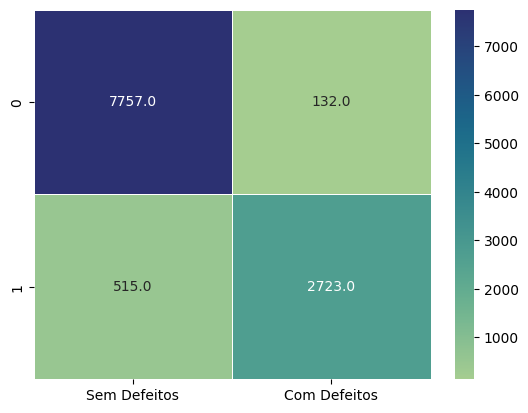

In [217]:
print(classification_report(y_test, y_pred, target_names = def_class_names) )

results = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

##KNN

In [218]:
model_data_knn = dados_normalizados.copy(deep=True)
x = model_data_knn.iloc[:, 1:999]
y = model_data_knn.loc[:, 'Defeitos']

x_train, x_test, y_train, y_test = train_test_split(x_rf, y_rf, test_size=0.2, random_state=0) 
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', leaf_size=50)
knn.fit(x_train, y_train)

y_pred =knn.predict(x_test)

print("Acuracia base treinamento: {:.2f}%".format(model.score(x_train, y_train)*100))
print("Acuracia base testes: {:.2f}%".format(model.score(x_test, y_test)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred, y_test) ))

Acuracia base treinamento: 96.83%
Acuracia base testes: 94.19%
R^2 Score: 0.542;


              precision    recall  f1-score   support

Sem Defeitos       0.91      0.99      0.95      7889
Com Defeitos       0.97      0.75      0.85      3238

    accuracy                           0.92     11127
   macro avg       0.94      0.87      0.90     11127
weighted avg       0.92      0.92      0.92     11127

Acurácia em cada fold: [0.94225368 0.93877092 0.94034378 0.94180429 0.94595506]
Acurácia média: 0.94
Desvio padrão: 0.0024
Acurácia média: 94.18%
Intervalo de acurácia: [93.70% ~ 94.66%]


<Axes: >

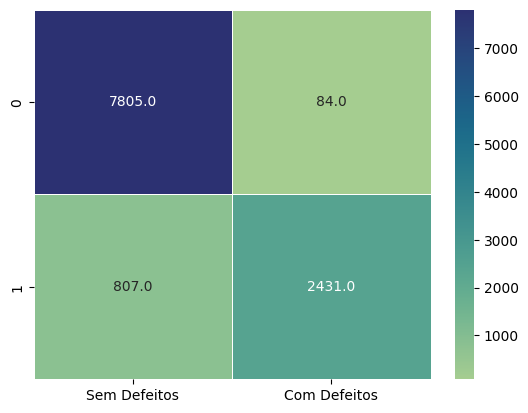

In [219]:
print(classification_report(y_test, y_pred, target_names = def_class_names) )

results = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

##SVM

In [220]:
model_data_SVM = dados_normalizados.copy(deep=True)
x = model_data_SVM.iloc[:, 1:999]
y = model_data_SVM.loc[:, 'Defeitos']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 

# Criar o modelo SVM
svm = SVC(kernel='poly', C=1.0, random_state=0)  # Usar kernel linear e parâmetro de regularização C=1.0

# Treinar o modelo SVM
svm.fit(x_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = svm.predict(x_test)

# Calcular a acurácia do modelo
print("Acuracia base treinamento: {:.2f}%".format(svm.score(x_train, y_train)*100))
print("Acuracia base testes: {:.2f}%".format(svm.score(x_test, y_test)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred, y_test) ))


Acuracia base treinamento: 91.47%
Acuracia base testes: 90.28%
R^2 Score: 0.441;


              precision    recall  f1-score   support

Sem Defeitos       0.89      0.98      0.93      7889
Com Defeitos       0.93      0.72      0.81      3238

    accuracy                           0.90     11127
   macro avg       0.91      0.85      0.87     11127
weighted avg       0.91      0.90      0.90     11127

Acurácia em cada fold: [0.94225368 0.93877092 0.94034378 0.94180429 0.94595506]
Acurácia média: 0.94
Desvio padrão: 0.0024
Acurácia média: 94.18%
Intervalo de acurácia: [93.70% ~ 94.66%]


<Axes: >

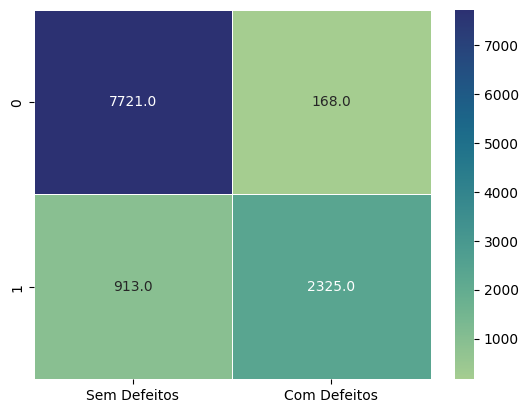

In [221]:
print(classification_report(y_test, y_pred, target_names = def_class_names) )

results = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")